# Re-analysis of PXD014414: Metaplastic breast cancer

## Sabra I. Djomehri, et al.

## [Nature Communications (2020) 11:1723](https://doi.org/10.1038/s41467-020-15283-z)


### Data re-analysis performed by Phil Wilmarth, PSR Core OHSU

### This notebook will be using voom-limma instead of edgeR

#### July 26, 2020

---

- [Overview](#overview) 
- [Library and data loading](#load_data) 
- [Clustering and normalization](#TMM)
- [1. Normal versus Triple Negative](#N_TN) 
- [2. Normal versus Metaplastic](#N_MBC) 
- [3. Triple Negative versus Metaplastic](#TN_MBC) 
- [Summary](#summary)

---

## <a name="overview"></a>Overview

The data were first presented in this publication:

> Djomehri, S.I., Gonzalez, M.E., da Veiga Leprevost, F., Tekula, S.R., Chang, H.Y., White, M.J., Cimino-Mathews, A., Burman, B., Basrur, V., Argani, P. and Nesvizhskii, A.I., 2020. Quantitative proteomic landscape of metaplastic breast carcinoma pathological subtypes and their relationship to triple-negative tumors. Nature communications, 11(1), pp.1-15.

The IRS adjusted reporter ion intensities from the PAW pipeline were analyzed with [Jupyter notebooks](www.jupyter.org), an R kernel, the Bioconductor package edgeR, and its TMM normalization method. This notebook format allows rich data visualization and quality control checks.

## Load the necessary R libraries

In [1]:
# library imports
library(tidyverse)
library(scales)
library(limma)
library(edgeR)
library(psych)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘psych’


The following objects are masked from ‘package:scales’:

    alpha, rescale


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




## Define common functions for notebook use

In [2]:
# ============== CV function ===================================================
CV <- function(df) {
    # Computes CVs of data frame rows
        # df - data frame, 
        # returns vector of CVs (%)
    ave <- rowMeans(df)    # compute averages
    sd <- apply(df, 1, sd) # compute standard deviations
    cv <- 100 * sd / ave   # compute CVs in percent (last thing gets returned)
}

# =========== Boxplot with median label ========================================
labeled_boxplot <- function(df, ylim, title) {
    # Makes a box plot with the median value labeled
        # df - data frame with data to compute CVs of
        # ylim - upper limit for y-axis
        # title - plot title
    cv = CV(df)
    boxplot(cv, ylim = c(0, ylim), notch = TRUE, main = title)
    text(x = 0.65, y = boxplot.stats(cv)$stats[3], 
         labels = round(boxplot.stats(cv)$stats[3], 1))
}

# ================== TMM normalization from DGEList object =====================
apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute and print "Sample loading" normalization factors
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size
    cat("\nLibrary size factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), lib_facs))
    
    # compute and print TMM normalization factors
    tmm_facs <- 1/y$samples$norm.factors
    cat("\nTrimmed mean of M-values (TMM) factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), tmm_facs))
    
    # compute and print the final correction factors
    norm_facs <- lib_facs * tmm_facs
    cat("\nCombined (lib size and TMM) normalization factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    tmt_tmm
}

# ================= reformat edgeR test results ================================
collect_results_limma <- function(df, tt, x, xlab, y, ylab, genes) {
    # Computes new columns and extracts some columns to make results frame
        # df - data in data.frame
        # tt - top tags table from edgeR test
        # x - columns for first condition
        # xlab - label for x
        # y - columns for second condition
        # ylab - label for y
        # returns a new dataframe
    
    # condition average vectors
    ave_x <- rowMeans(df[x])
    ave_y <- rowMeans(df[y])
    
    # FC, direction, candidates
    fc <- ifelse(ave_y > ave_x, (ave_y / ave_x), (-1 * ave_x / ave_y))
    direction <- ifelse(ave_y > ave_x, "up", "down")
    candidate <- cut(tt$adj.P.Val, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                     labels = c("high", "med", "low", "no"))
    
    # make data frame
    temp <- cbind(df[c(x, y)], data.frame(logFC = tt$logFC, FC = fc, 
                                          PValue = tt$P.Value, FDR = tt$adj.P.Val, 
                                          ave_x = ave_x, ave_y = ave_y, 
                                          direction = direction, candidate = candidate, 
                                          Acc = genes)) 
    
    # fix column headers for averages
    names(temp)[names(temp) %in% c("ave_x", "ave_y")]  <- str_c("ave_", c(xlab, ylab))    
    
    temp # return the data frame
}

# =============== p-value plots ================================================
pvalue_plots <- function(results, ylim, title) {
    # Makes p-value distribution plots
        # results - results data frame
        # ylim - ymax for expanded view
        # title - plot title
    p_plot <- ggplot(results, aes(PValue)) + 
        geom_histogram(bins = 100, fill = "white", color = "black") +
        geom_hline(yintercept = mean(hist(results$PValue, breaks = 100, 
                                     plot = FALSE)$counts[26:100]))

    # we will need an expanded plot
    p1 <- p_plot + ggtitle(str_c(title, " p-value distribution"))
    p2 <- p_plot + coord_cartesian(xlim = c(0, 1.0), ylim = c(0, ylim)) + ggtitle("p-values expanded")
    grid.arrange(p1, p2, nrow = 2) # from gridExtra package
}

# ============= log2 fold-change distributions =================================
log2FC_plots <- function(results, range, title) {
    # Makes faceted log2FC plots by candidate
        # results - results data frame
        # range - plus/minus log2 x-axis limits
        # title - plot title
    ggplot(results, aes(x = logFC, fill = candidate)) +
        geom_histogram(binwidth=0.1, color = "black") +
        facet_wrap(~candidate) +
        ggtitle(title) + 
        coord_cartesian(xlim = c(-range, range))
}

# ========== Setup for MA and volcano plots ====================================
transform <- function(results, x, y) {
    # Make data frame with some transformed columns
        # results - results data frame
        # x - columns for x condition
        # y - columns for y condition
        # return new data frame
    df <- data.frame(log10((results[x] + results[y])/2), 
                     log2(results[y] / results[x]), 
                     results$candidate,
                     -log10(results$FDR))
    colnames(df) <- c("A", "M", "candidate", "P")
    
    df # return the data frame
}

# ========== MA plots using ggplot =============================================
MA_plots <- function(results, x, y, title) {
    # makes MA-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots 
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # 2-fold change lines
    ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                     geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                     geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    # make main MA plot
    ma <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
        scale_x_continuous("Ave_intensity") +
        ggtitle(title) + 
        ma_lines
    
    # make separate MA plots
    ma_facet <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
        scale_x_continuous("log10 Ave_intensity") +
        ma_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)"))

    # make the plots visible
    print(ma)
    print(ma_facet)
}    

# ========== Scatter plots using ggplot ========================================
scatter_plots <- function(results, x, y, title) {
    # makes scatter-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots
    
    # 2-fold change lines
    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())

    # make main scatter plot
    scatter <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        ggtitle(title) + 
        scatter_lines

    # make separate scatter plots
    scatter_facet <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scatter_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)")) 

    # make the plots visible
    print(scatter)
    print(scatter_facet)
}

# ========== Volcano plots using ggplot ========================================
volcano_plot <- function(results, x, y, title) {
    # makes a volcano plot
        # results - a data frame with edgeR results
        # x - string for the x-axis column
        # y - string for y-axis column
        # title - plot title string
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # build the plot
    ggplot(temp, aes(x = M, y = P)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        xlab("log2 FC") +
        ylab("-log10 FDR") +
        ggtitle(str_c(title, " Volcano Plot"))
}

# ============== individual protein expression plots ===========================
# function to extract the identifier part of the accesssion
get_identifier <- function(accession) {
    identifier <- str_split(accession, "\\|", simplify = TRUE)
    identifier[,3]
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

plot_top_tags <- function(results, nleft, nright, top_tags) {
    # results should have data first, then test results (two condition summary table)
    # nleft, nright are number of data points in each condition
    # top_tags is number of up and number of down top DE candidates to plot
    # get top ipregulated
    up <- results %>% 
        filter(logFC >= 0) %>%
        arrange(FDR)
    up <- up[1:top_tags, ]
    
    # get top down regulated
    down <- results %>% 
        filter(logFC < 0) %>%
        arrange(FDR)
    down <- down[1:top_tags, ]
    
    # pack them
    proteins <- rbind(up, down)
        
    color = c(rep("red", nleft), rep("blue", nright))
    for (row_num in 1:nrow(proteins)) {
        row <- proteins[row_num, ]
        vec <- as.vector(unlist(row[1:(nleft + nright)]))
        names(vec) <- colnames(row[1:(nleft + nright)])
        title <- str_c(get_identifier(row$Acc), ", int: ", scientific(mean(vec), 2), 
                       ", FDR: ", scientific(row$FDR, digits = 3), 
                       ", FC: ", round(row$FC, digits = 1),
                       ", ", row$candidate)
        barplot(vec, col = color, main = title,
                cex.main = 1.0, cex.names = 0.7, cex.lab = 0.7)
    }    
}

## <a name="load_data"></a>Load the IRS-normalized TMT intensity data

The pandas Python script that does the IRS normalization arranges the tab-delimited table so that importing into R is relatively straightforward. Note than this experimental design has only a single reference channel per plex instead of two.

We need to drop contaminant and decoy proteins, and proteins with missing sets of reporter ions. We extract the accessions column, the SL and IRS normed data columns, and collect channels by biological condition. We also grab the reference channels to check the IRS procedure.

In [3]:
# load the IRS-normalized data and check the table
data_import <- read_tsv("labeled_grouped_protein_summary_TMT_9_IRS_normalized.txt", guess_max = 5250)

# "Filter" column flags contams and decoys
# "Missing" column flags proteins without reporter ion intensities (full sets missing)
# the table from pandas is sorted so the rows we want come first
data_all <- filter(data_import, is.na(Filter), is.na(Missing))
data_sl <- data_all %>% select(., contains("SLNorm_")) %>% 
  select(., -contains("_Unused")) %>% 
  select(., -contains("_Pool"))
data_irs <- data_all %>% select(., contains("IRSNorm_")) %>% 
  select(., -contains("_Unused")) %>% 
  select(., -contains("_Pool"))
data_pool <- data_all %>% select(., contains("_Pool_"))

Parsed with column specification:
cols(
  .default = col_double(),
  Accession = col_character(),
  Identical = col_character(),
  Similar = col_character(),
  OtherLoci = col_character(),
  Filter = col_character(),
  Missing = col_character(),
  Description = col_character()
)

See spec(...) for full column specifications.



In [4]:
# save a few columns for the results table
all_results <- data_all %>% select(., ProtGroup, Counter, Accession, Description, starts_with("PSMs_Used"))

# save gene names for edgeR so we can double check that results line up
accessions <- data_all$Accession

# see how many rows of data we have
length(accessions)

[1] 4132

### Group samples into the three types of tissue

We will lump all the metaplastic breast cancer (MBC) samples together to contrast to triple negative breast cancer and normal tissue samples. There will be 14 mbc, 6 triple negative, and 7 normal samples.

In [5]:
# all categories of metaplastic breast cancer tissue
mbc_sl <- select(data_sl, contains("_C"), contains("_SP"), contains("_SQ"))
mbc_irs <- select(data_irs, contains("_C"), contains("_SP"), contains("_SQ"))

# triple negative breast cancer tissue
tn_sl <- select(data_sl, contains("_TN"))
tn_irs <- select(data_irs, contains("_TN"))

# Normal tissue
n_sl <- select(data_sl, contains("_N"))
n_irs <- select(data_irs, contains("_N"))

In [6]:
# collect the biological replicate channels
bio_sl <- cbind(n_sl, tn_sl, mbc_sl)
bio_irs <- cbind(n_irs, tn_irs, mbc_irs)

# set a color vector for plots
color <- c(rep("red", 7), rep("blue", 6), rep("green", 14))

set_plot_dimensions(9, 9)

## <a name="TMM"></a>Normalize the data

Run TMM normalization on the IRS data so we have a starting point for limma.


Library size factors:
 IRSNorm_N1_1 -> 1.008535
 IRSNorm_N2_1 -> 1.011973
 IRSNorm_Nx_2 -> 0.989973
 IRSNorm_N3_2 -> 1.005097
 IRSNorm_N4_2 -> 0.997700
 IRSNorm_N5_3 -> 1.015249
 IRSNorm_N6_3 -> 1.008969
 IRSNorm_TN1_1 -> 1.001659
 IRSNorm_TN2_1 -> 1.001914
 IRSNorm_TN3_2 -> 1.016278
 IRSNorm_TN4_2 -> 0.993309
 IRSNorm_TN5_3 -> 1.001864
 IRSNorm_TN6_3 -> 1.004372
 IRSNorm_C1_1 -> 0.992717
 IRSNorm_C2_1 -> 0.999395
 IRSNorm_C4_2 -> 0.997888
 IRSNorm_C5_3 -> 0.997909
 IRSNorm_SP1_1 -> 0.999110
 IRSNorm_SP2_2 -> 0.998050
 IRSNorm_SP3_2 -> 0.995285
 IRSNorm_SP4_3 -> 0.988267
 IRSNorm_SP5_3 -> 0.988331
 IRSNorm_SP6_3 -> 0.993169
 IRSNorm_SQ1_1 -> 0.994292
 IRSNorm_SQ2_1 -> 1.003056
 IRSNorm_SQ3_2 -> 1.001224
 IRSNorm_SQ4_3 -> 0.995877

Trimmed mean of M-values (TMM) factors:
 IRSNorm_N1_1 -> 1.152091
 IRSNorm_N2_1 -> 1.299722
 IRSNorm_Nx_2 -> 1.578921
 IRSNorm_N3_2 -> 1.167884
 IRSNorm_N4_2 -> 1.016422
 IRSNorm_N5_3 -> 1.182453
 IRSNorm_N6_3 -> 0.991036
 IRSNorm_TN1_1 -> 0.927147
 IRSNorm_

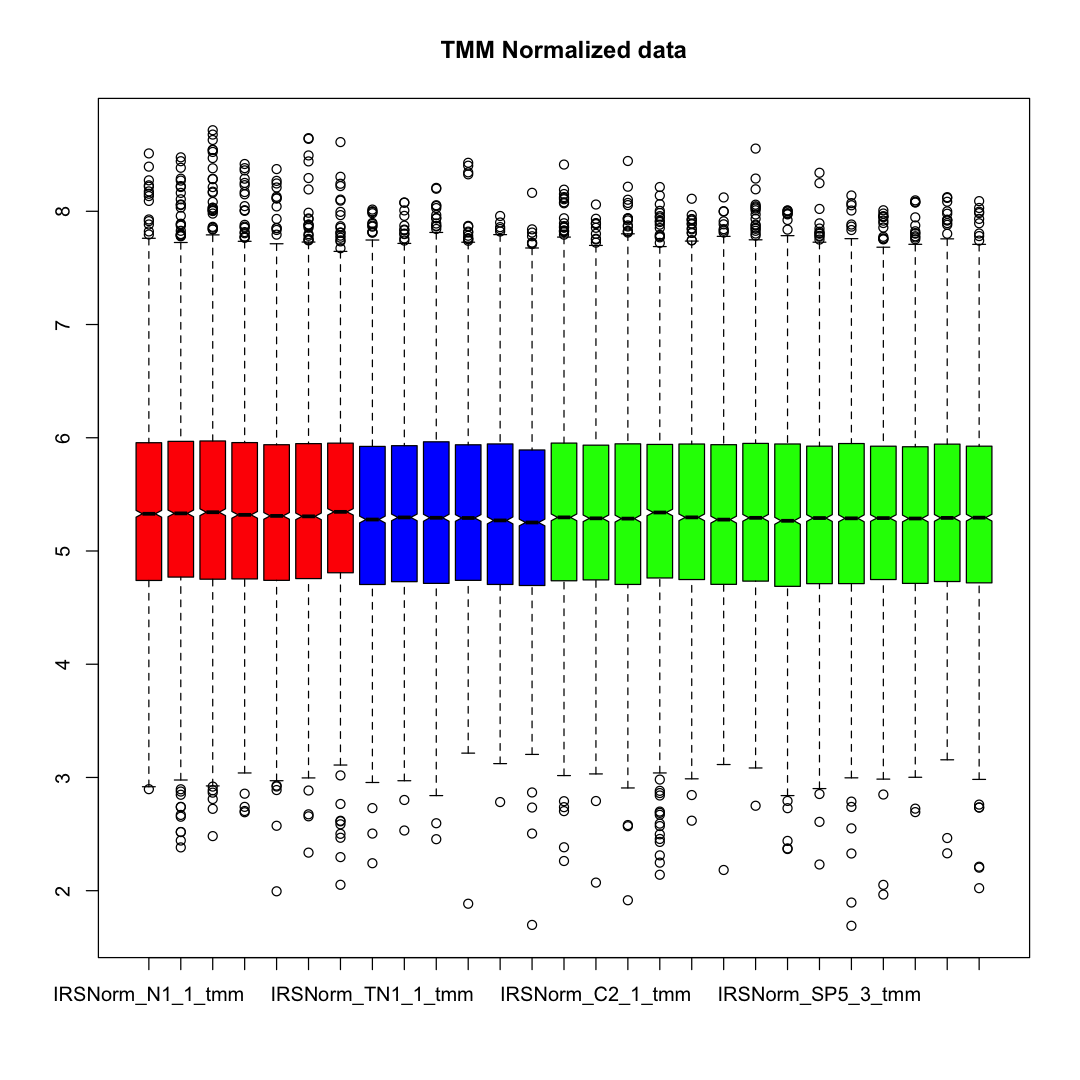

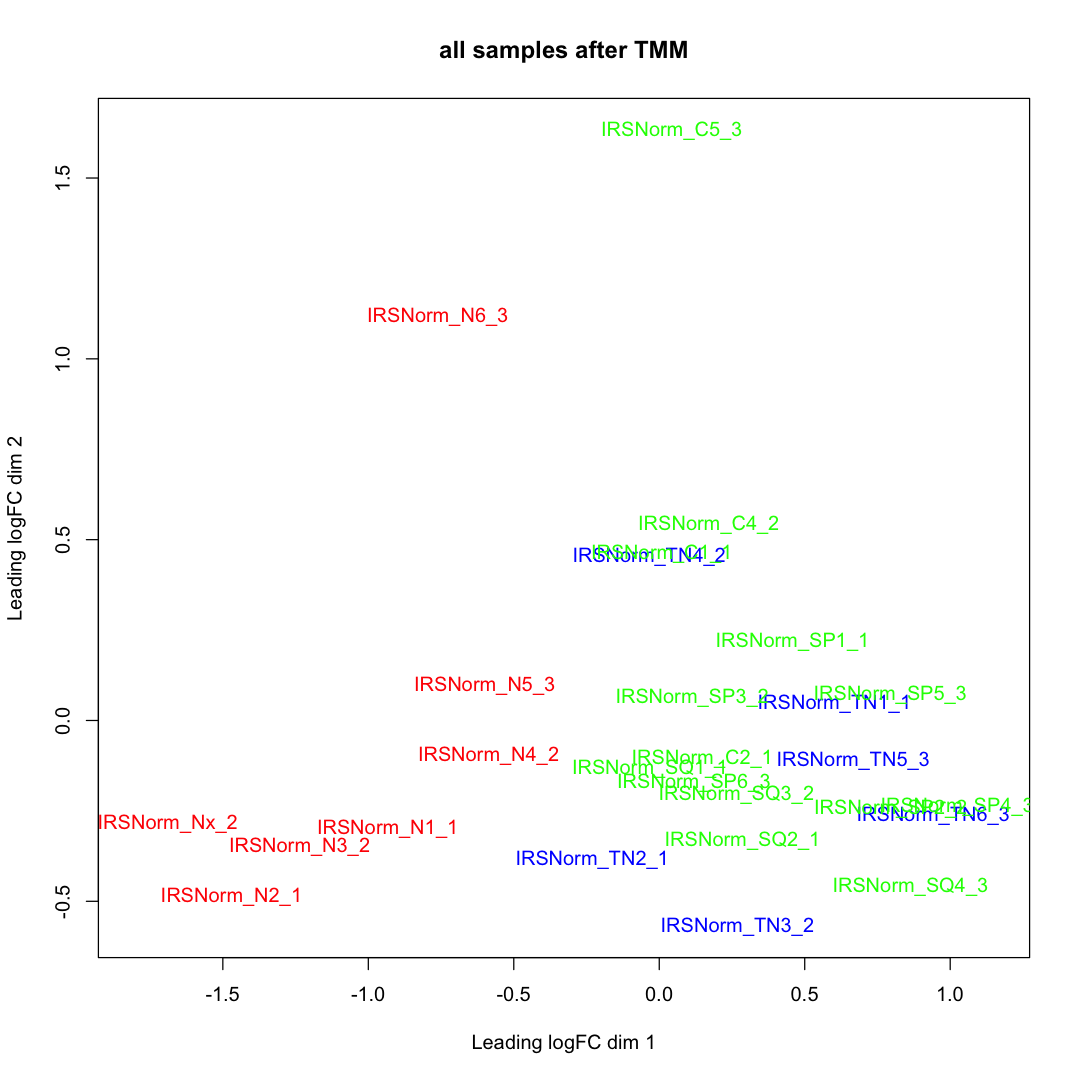

In [7]:
# put groups together into a single data frame
tmt_sl <- bio_sl
tmt_irs <- bio_irs

# define the positions of the groups
N <- 1:7
TN <- 8:13
MP <- 14:27

# set some colors by condition
group <- c(rep("N", 7), rep("TN", 6), rep("MBC", 14))

# get the biological sample data into a DGEList object
y <- DGEList(counts = tmt_irs, group = group, genes = accessions)

# run TMM normalization (also includes a library size factor)
y <- calcNormFactors(y)

tmt_tmm <- apply_tmm_factors(y, color = color)

# check the clustering
plotMDS(y, col = color, main = "all samples after TMM")

## Statistical testing starts here

We will do the variance modeling in edgeR with voom and then do the statistical testing with limma.

## <a name="N_TN"></a>(1) Normal versus Triple Negative

### Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data) and also accumulate all of the three comparisons into `all_results`.

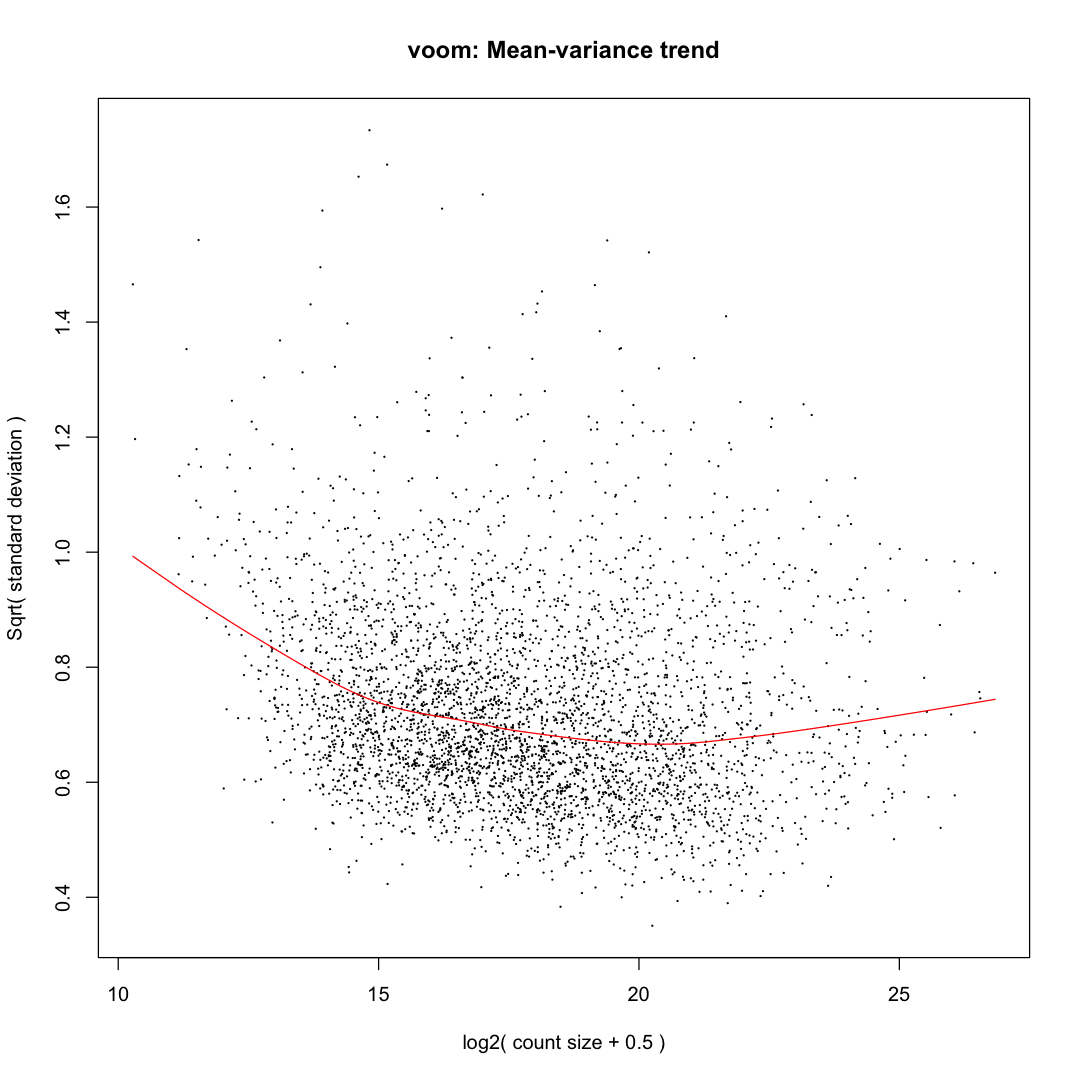

In [8]:
# copy the data
limma_PAW <- log2(tmt_tmm)
row.names(limma_PAW) <- accessions # add accessions as row names

# set up the design matrix
group <- as.factor(c(rep("N", length(N)), rep("TN", length(TN)), rep("MP", length(MP))))
group <- factor(group, levels = c("N", "TN", "MP")) # set the factor order
design <- model.matrix(~ 0 + group)
colnames(design) <- c("N", "TN", "MP")

# run voom to get model weights for each intensity value
v <- voom(y, design, plot = TRUE)

In [9]:
# do the linear model fitting
vfit <- lmFit(v, design)

# make the contrast
contrast <- makeContrasts(N-TN, levels = design)
contrast

# get the fit for the contrast of interest
vfit2 <- contrasts.fit(vfit, contrast)

# do the empirical Bayes moderation of the test statistic (with trended variance)
efit2 <- eBayes(vfit2)

# grab the information in topTable so we can get the data to plot candidates
# the coef parameter has to do with the contrast of interest
# specify no sorting of results and a number that is longer than the data table
tt_limma <- topTable(efit2, coef = 1, sort.by = "none", number = Inf)

# let's see how many up and down candidates, and the top tags
summary(decideTests(efit2, p.value = 0.05))
topTable(efit2)

Contrasts
Levels N - TN
    N   1    
    TN -1    
    MP  0

       N - TN
Down      184
NotSig   3617
Up        331

genes                 logFC    AveExpr   t        P.Value     
2311 sp|P02750|A2GL_HUMAN  2.257117  4.734294 6.620521 3.439123e-07
1720 sp|P15088|CBPA3_HUMAN 2.770307  5.390333 6.414209 5.941712e-07
2195 sp|P23946|CMA1_HUMAN  2.901383  4.613247 6.328754 7.460935e-07
3688 sp|P28906|CD34_HUMAN  2.379166  2.137906 6.217901 1.003447e-06
1671 sp|O14558|HSPB6_HUMAN 2.990620  4.922487 6.165664 1.154261e-06
111  sp|P12109|CO6A1_HUMAN 2.470617 10.909437 6.136391 1.248608e-06
45   sp|P07585|PGS2_HUMAN  3.695318 11.221895 6.032129 1.652735e-06
1833 sp|P04275|VWF_HUMAN   1.324323  5.572382 5.980687 1.898557e-06
2686 sp|Q9UEY8|ADDG_HUMAN  1.246384  4.047938 5.982466 1.889468e-06
971  sp|Q13642|FHL1_HUMAN  2.912533  6.863765 5.920943 2.230858e-06
     adj.P.Val    B       
2311 0.0008598747 6.637226
1720 0.0008598747 6.138828
2195 0.0008598747 5.917482
3688 0.0008598747 5.566993
1671 0.0008598747 5.514080
111  0.0008598747 5.427547
45   0.0008619564 5.154139
1833 0.0008619564 5.050117
2686 0.0008619564 5.040312
971  0.0008619564 4.900234

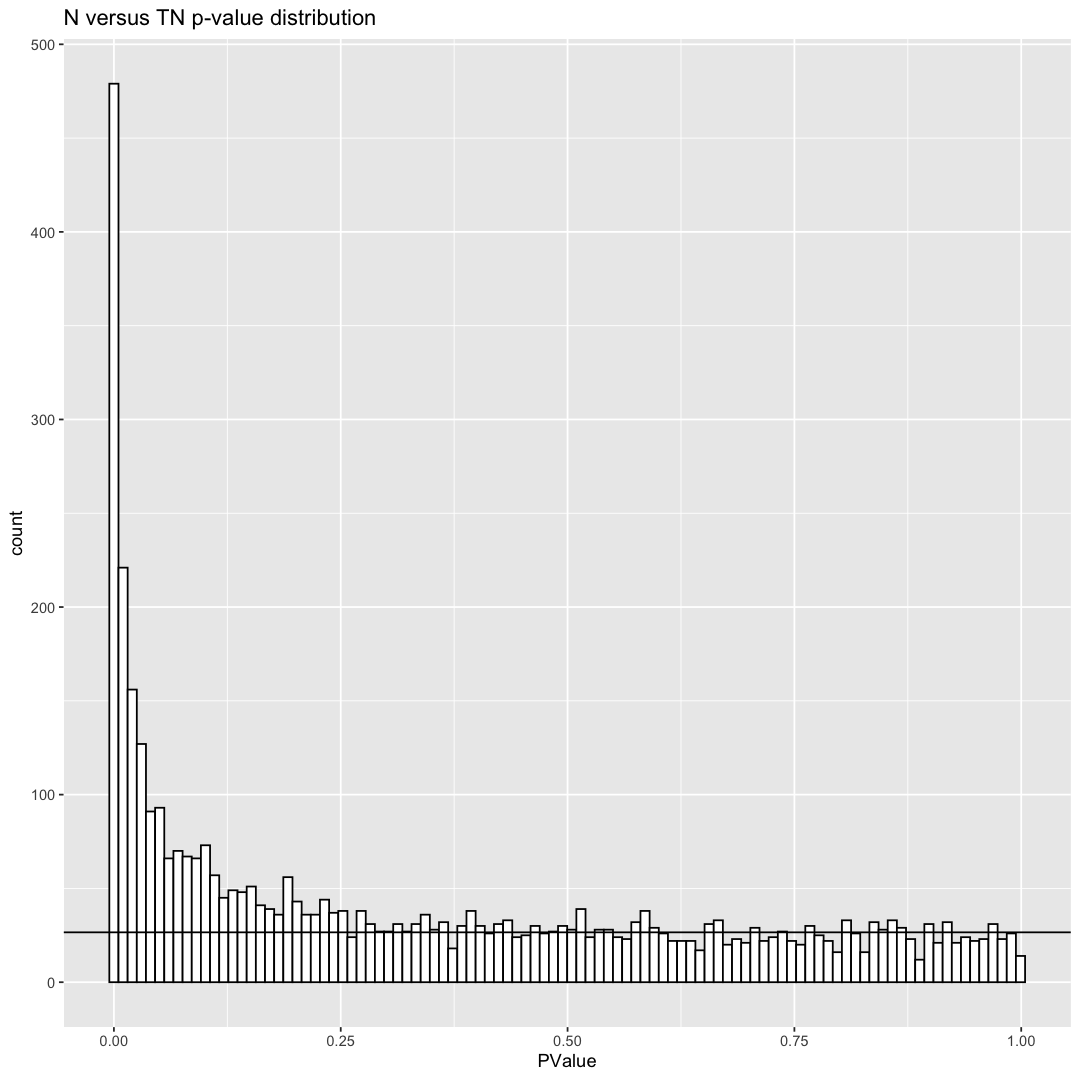

In [10]:
# get the results summary
results <- collect_results_limma(tmt_tmm, tt_limma, N, "N", TN, "TN", accessions)

# check the p-value distribution
ggplot(results, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(results$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("N versus TN p-value distribution")

### We have 515 DE candidates

We have a modest number of DE candidates. The p-value distribution suggests that the low p-value candidates are "soft" (not really small p-values) because the "spike" is more of a narrow distribution.  

In [11]:
# make column names unique by adding comparison (for the accumulated frame)
results_temp  <- results
colnames(results_temp) <- str_c(colnames(results), "_N_TN")

# accumulate the testing results
all_results <- cbind(all_results, results_temp)

### Count candidates and look at fold-change distributions

We will still make the MA plots, scatter plots, and volcano plot using ggplot2. We will also look at the distribution of log2 expression ratios separated by differential expression (DE) category. The Benjamini-Hochberg corrected edgeR p-values are used to categorize the DE candidates: no > 0.10 > low > 0.05 > med > 0.01 > high.

candidate n   
1 high       152
2 med        363
3 low        248
4 no        3369

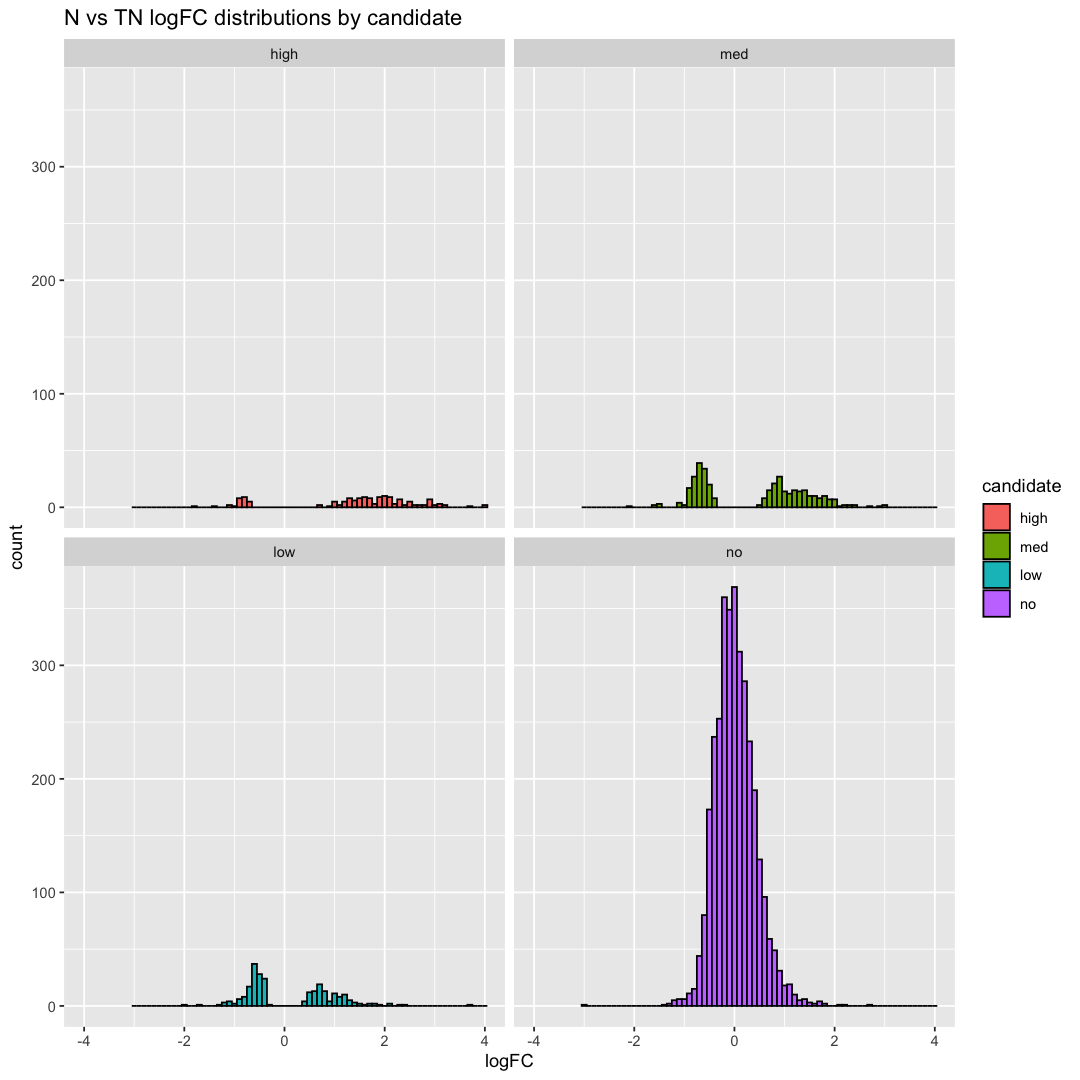

In [12]:
# see how many candidates by category
results %>% count(candidate)

# plot log2 fold-changes by category
ggplot(results, aes(x = logFC, fill = candidate)) +
  geom_histogram(binwidth=0.1, color = "black") +
  facet_wrap(~candidate) +
  coord_cartesian(xlim = c(-4, 4)) +
  ggtitle("N vs TN logFC distributions by candidate")

## Main summary plots

We have many comparisons to visualize, so we will use functions to generate a series of plots. We will make: an MA plot with candidates highlighted by color, faceted MA plots separated by candidate status, a scatter plot with candidates highlighted by color, faceted scatter plots separated by candidate status, and a volcano plot with candidates highlighted by color. The solid black lines in the MA and scatter plots are the 1-to-1 lines; the dotted lines are 2-fold change lines.

### MA plots

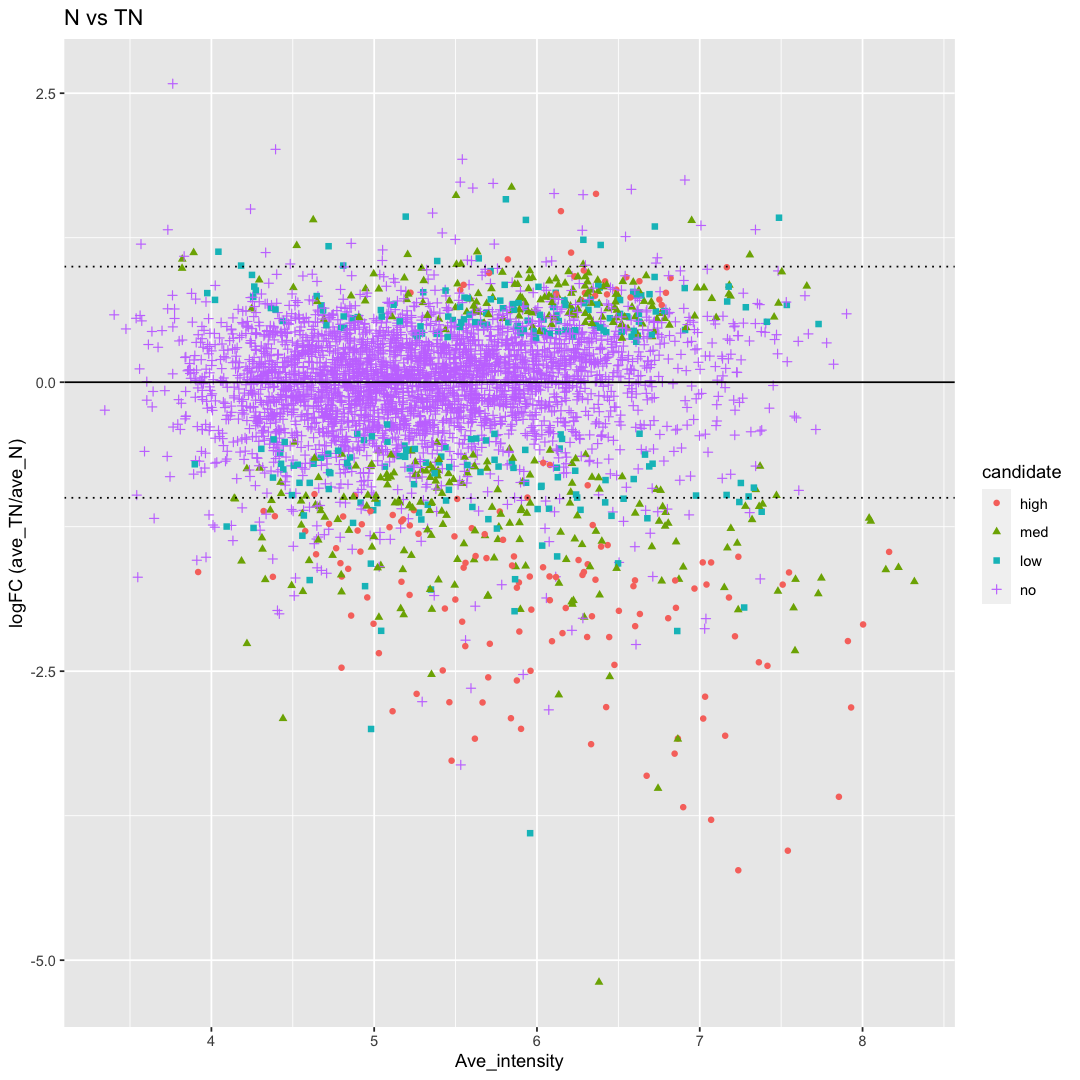

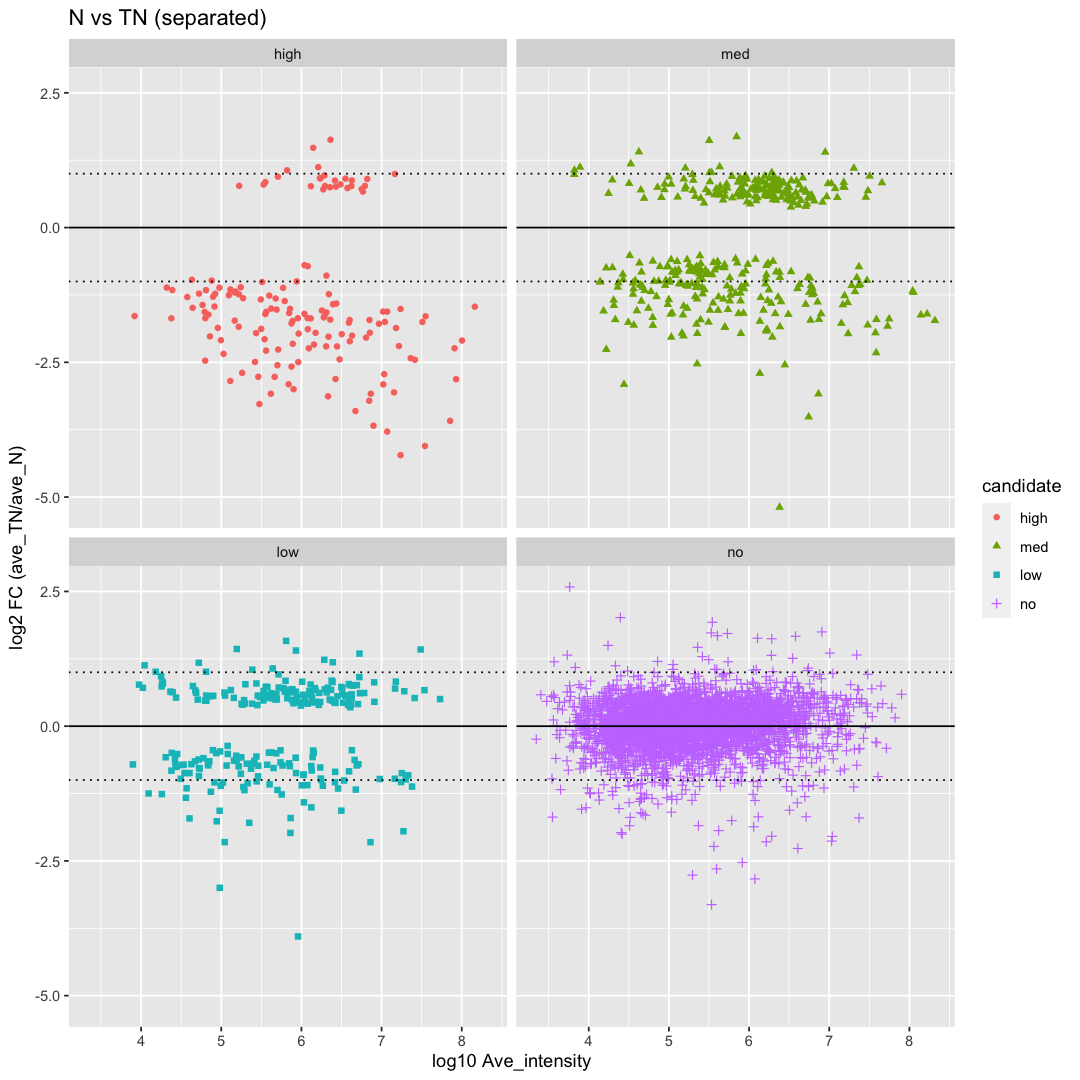

In [13]:
# make MA plots
MA_plots(results, "ave_N", "ave_TN", "N vs TN")

#### Pattern of non-DE candidates is qualitatively different than high DE candidates

We do have differences in the expression pattern for the highly-significant candidates (orange) and the non-DE candidates (purple).

### Scatter plots

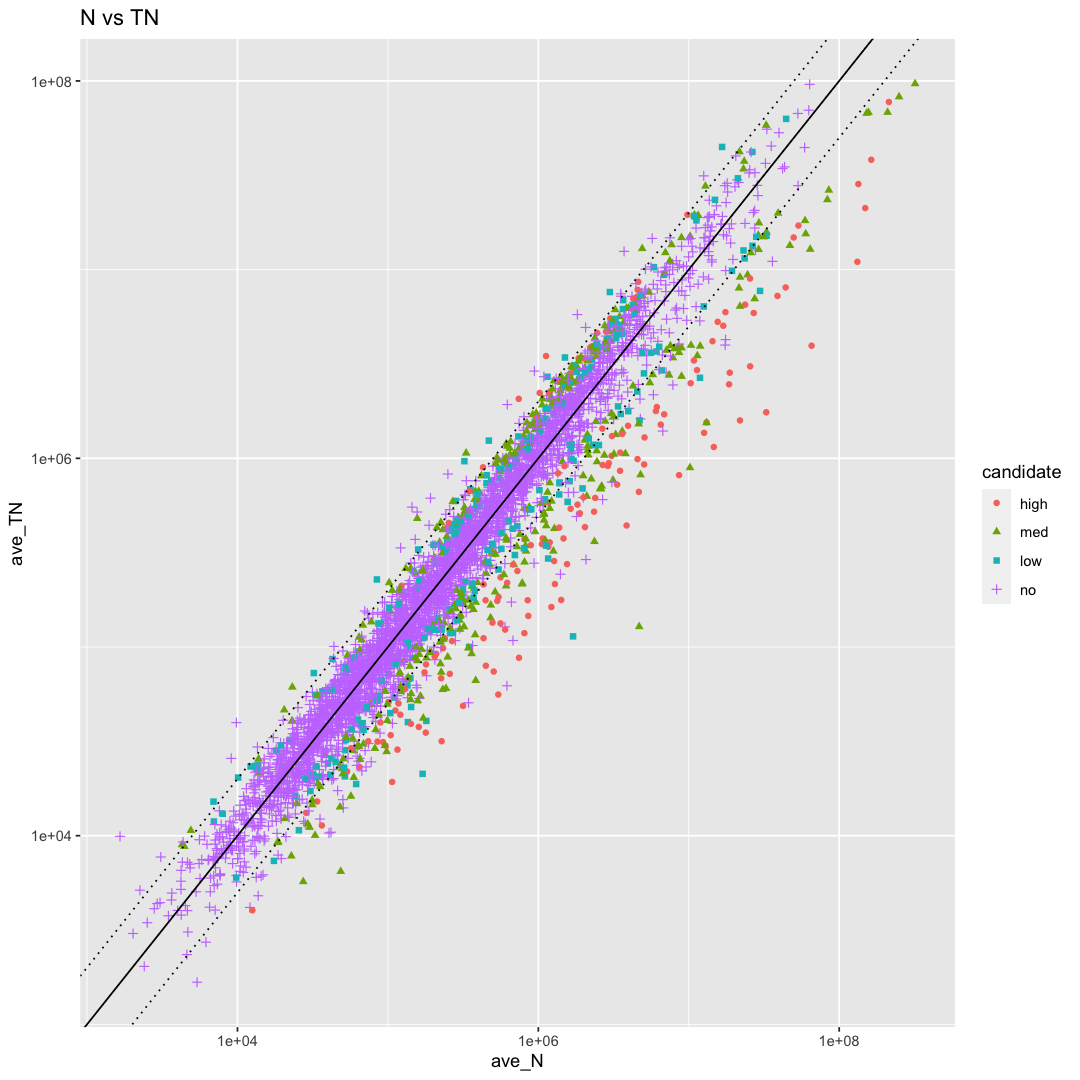

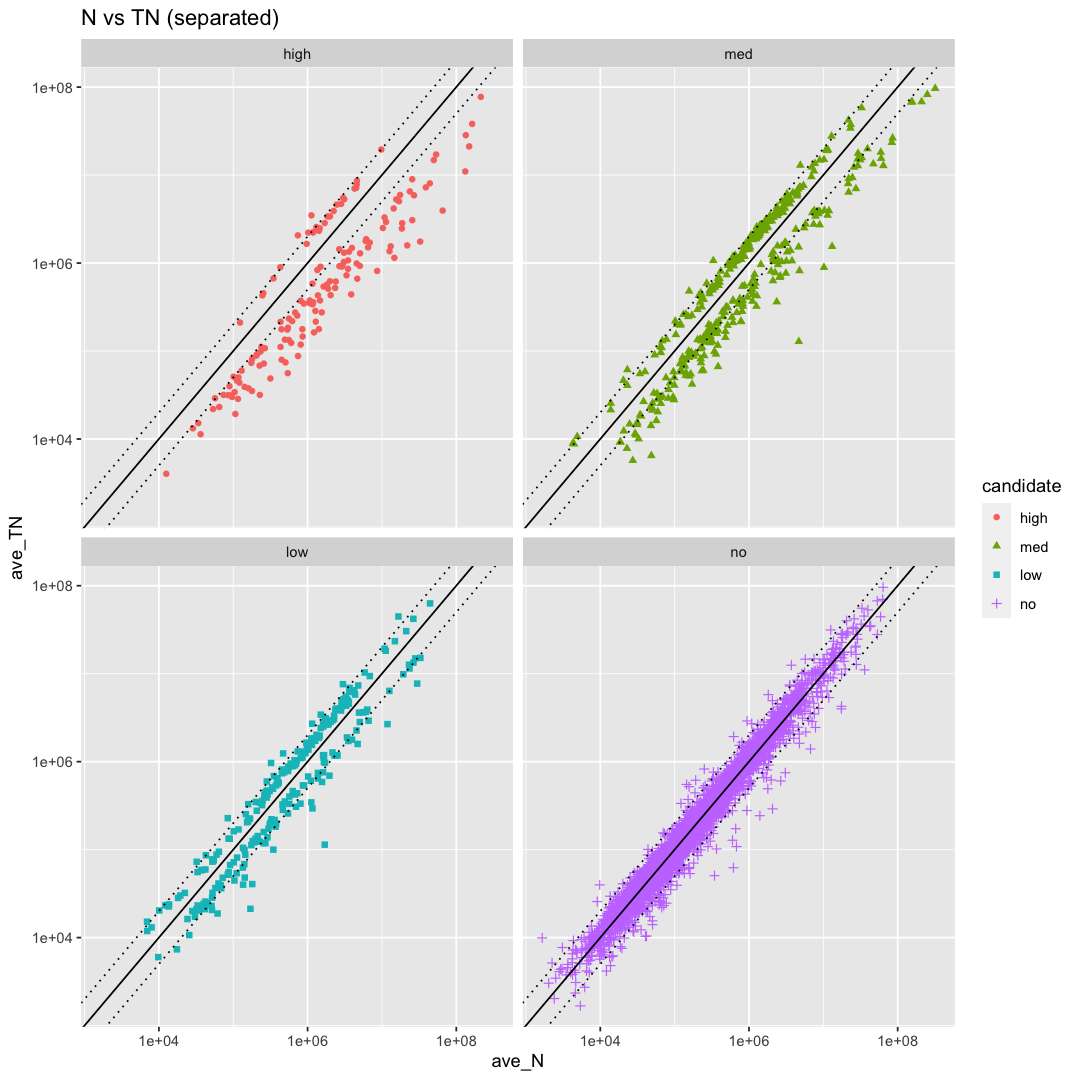

In [14]:
# make scatter plots
scatter_plots(results, "ave_N", "ave_TN", "N vs TN")

### Volcano plot

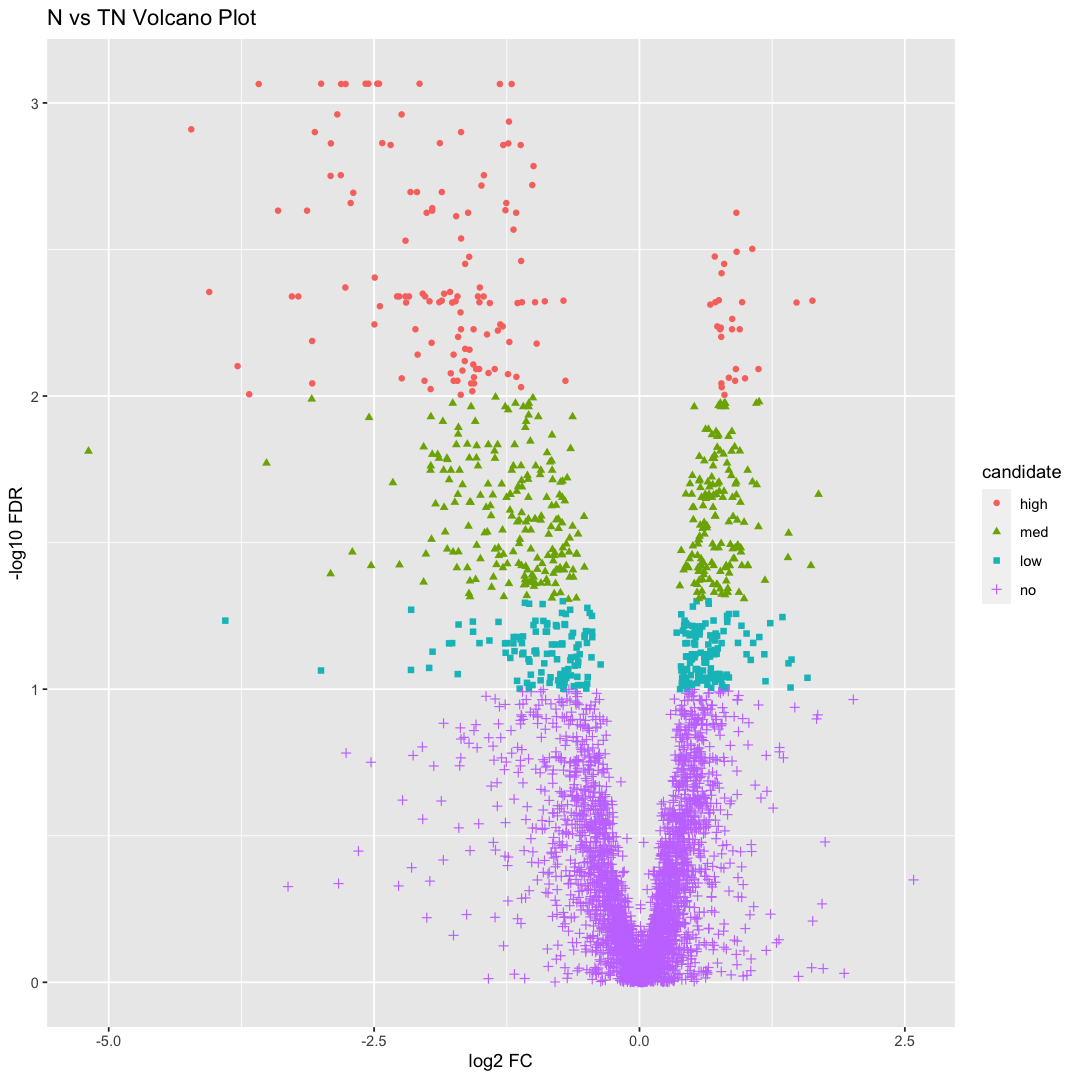

In [15]:
# make a volcano plot
volcano_plot(results, "ave_N", "ave_TN", "N vs TN")

### Candidates look okay

The magnitude of the p-values are not all that small, but the DE candidate patterns look okay.

### Check some individual protein expression

We can look at the data for the top 20 (by BH-corrected p-values) up and down regulated proteins.

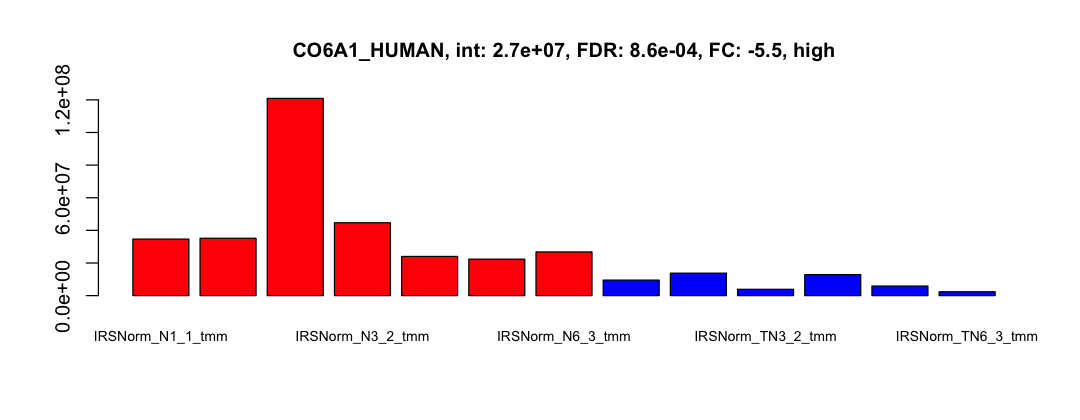

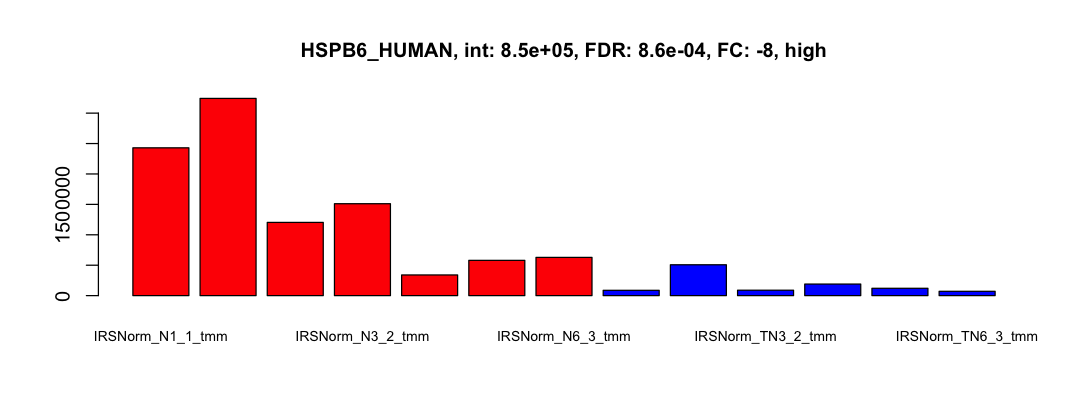

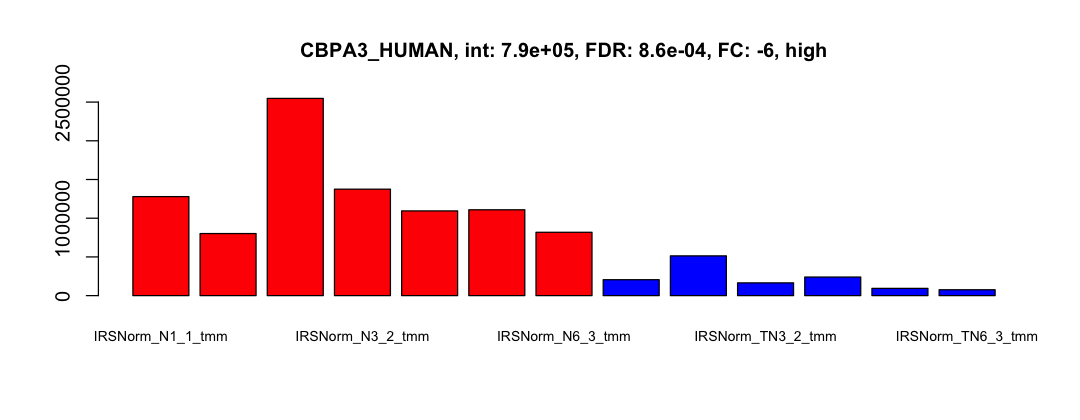

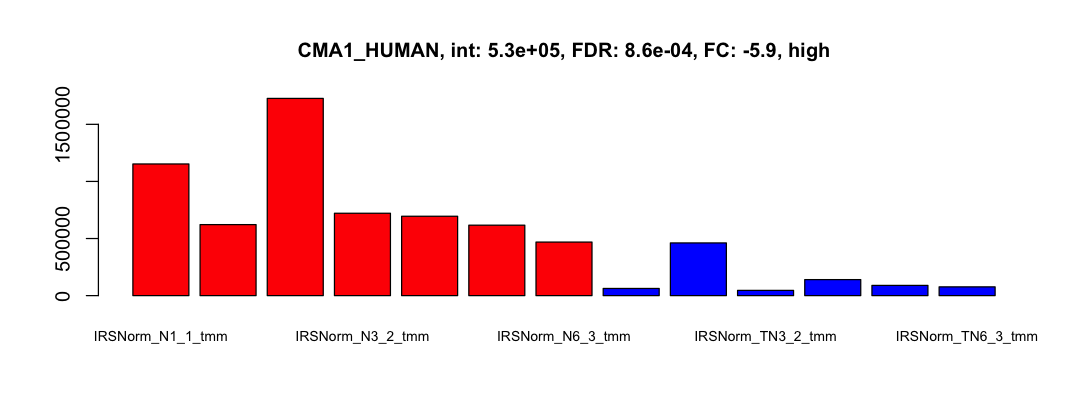

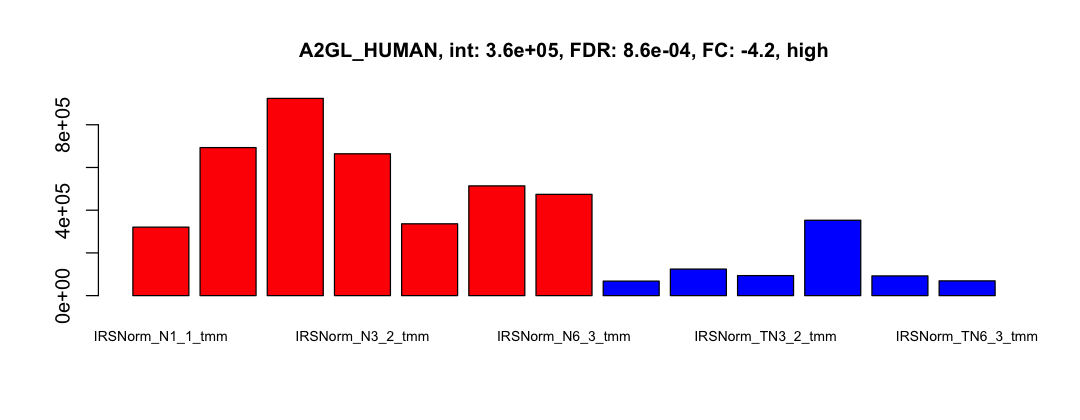

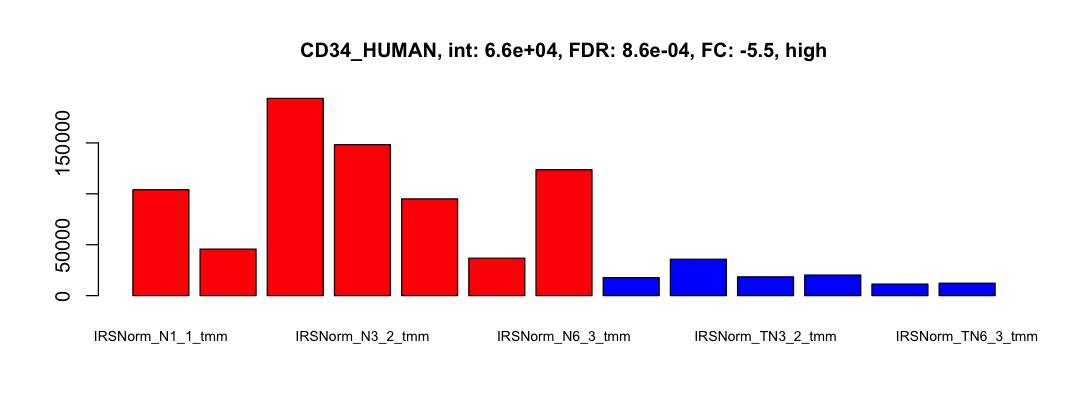

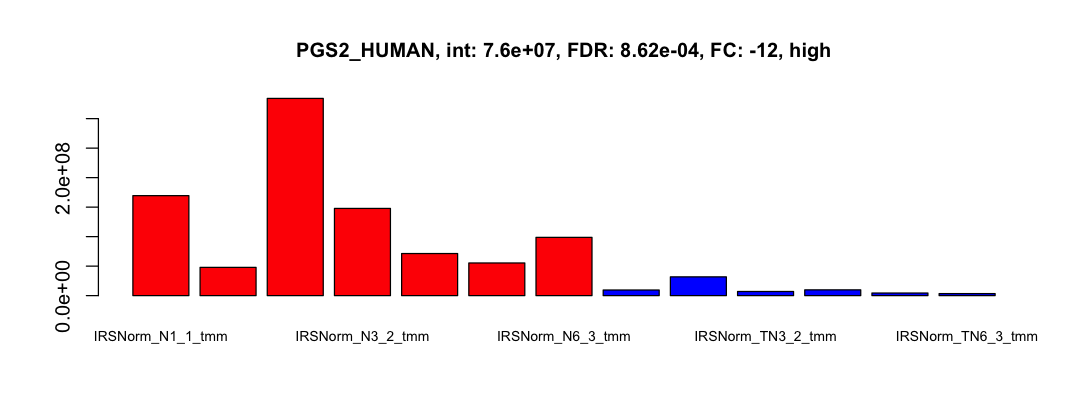

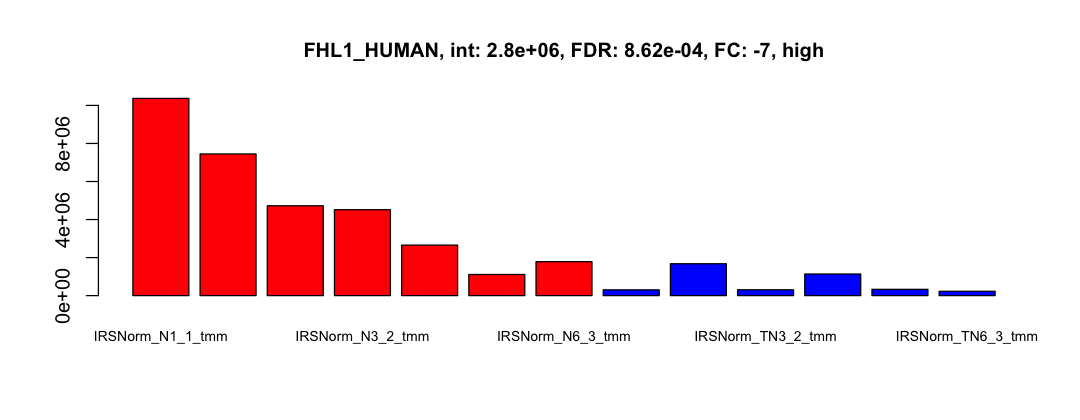

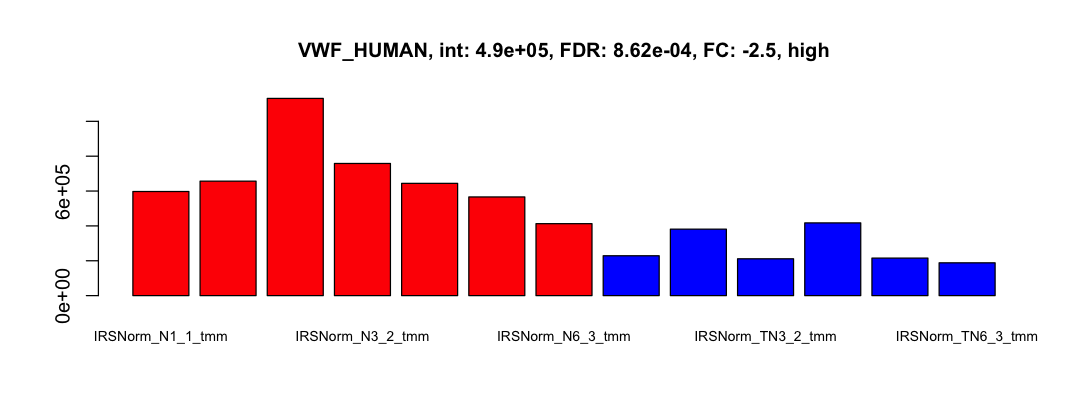

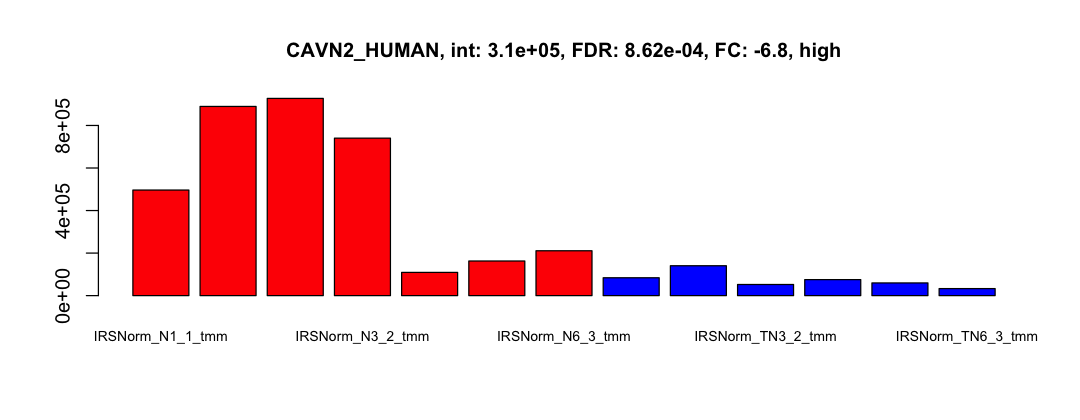

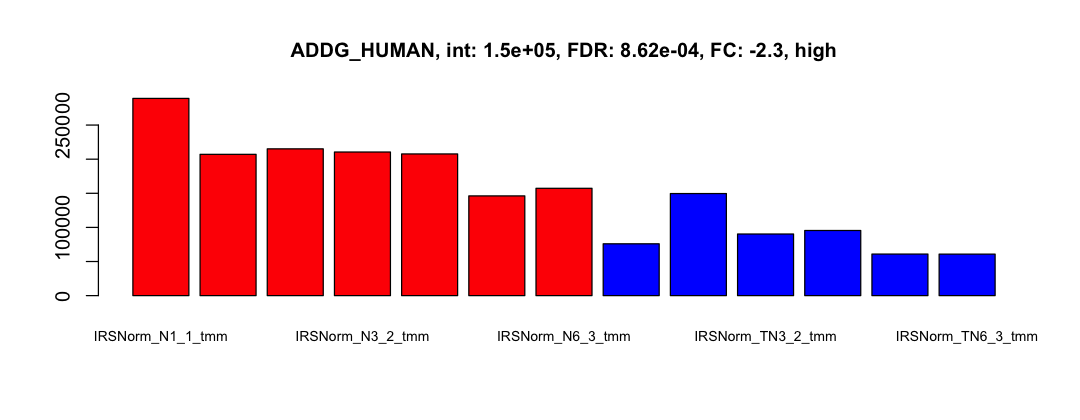

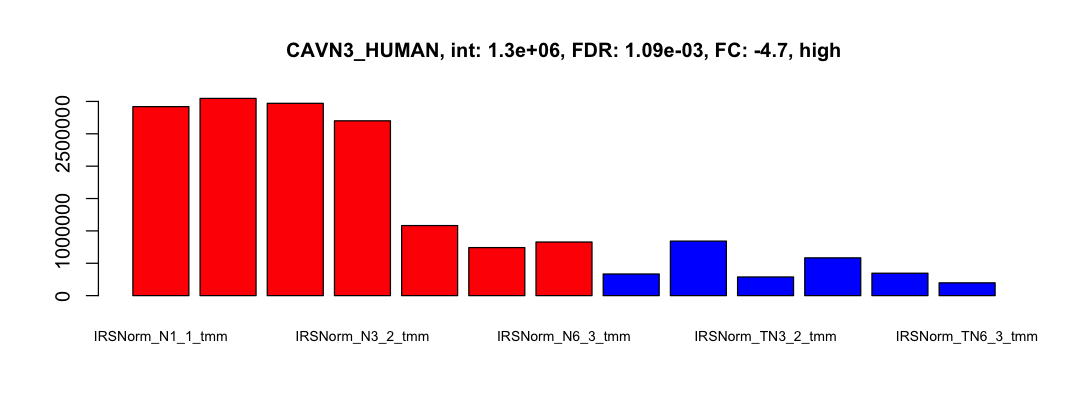

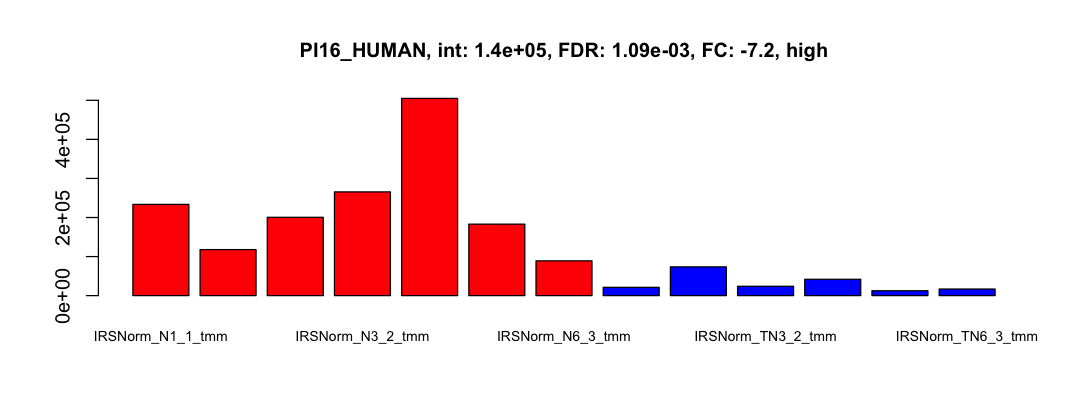

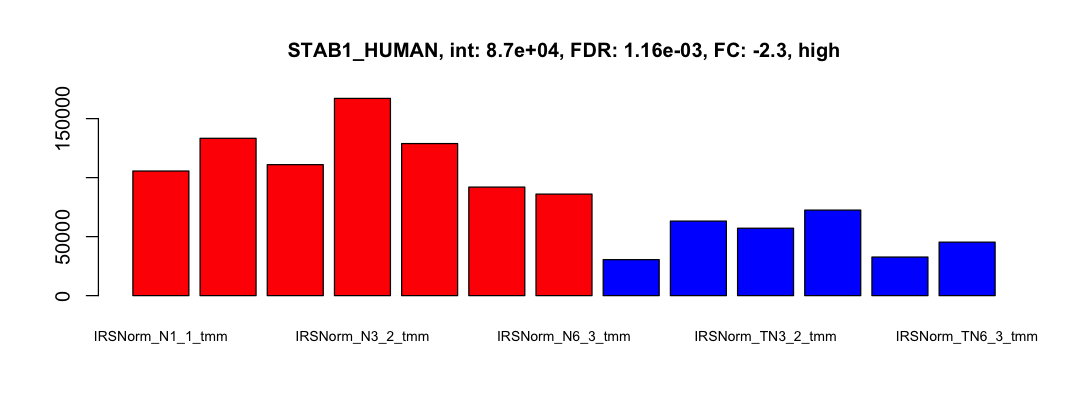

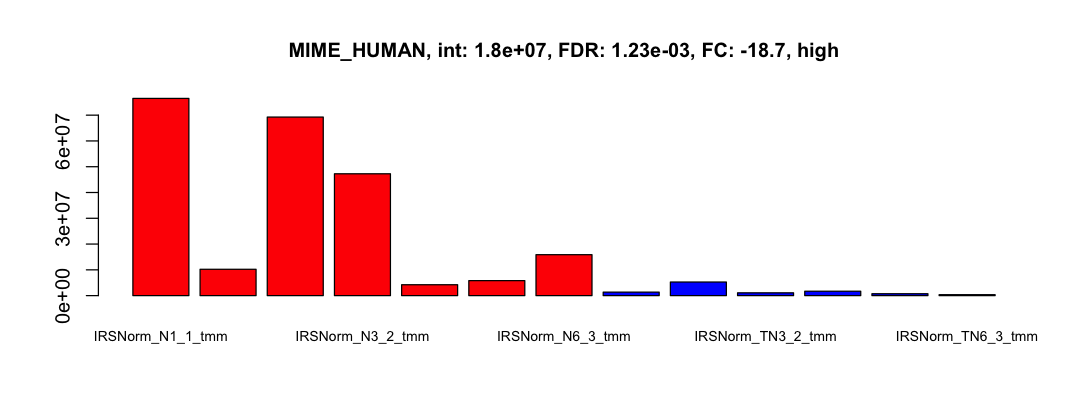

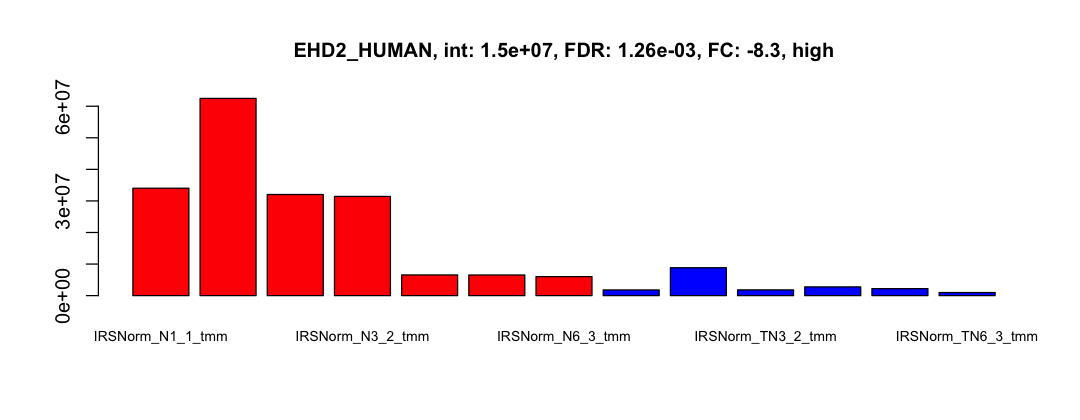

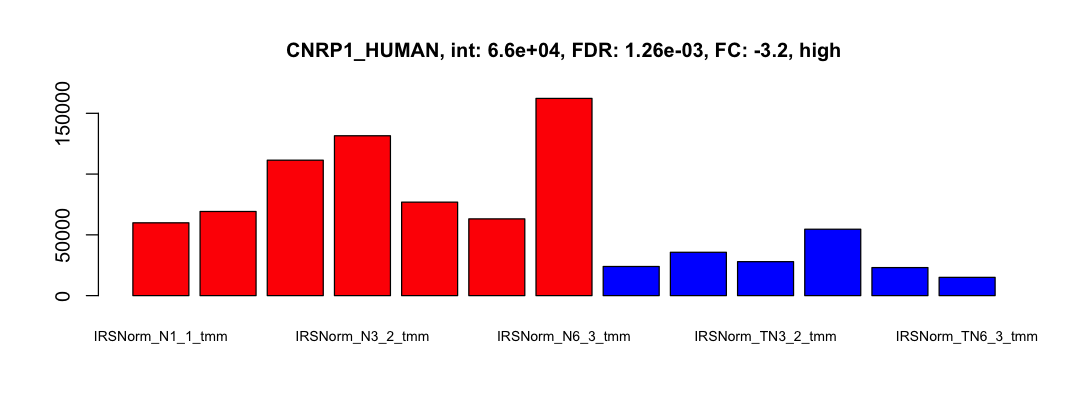

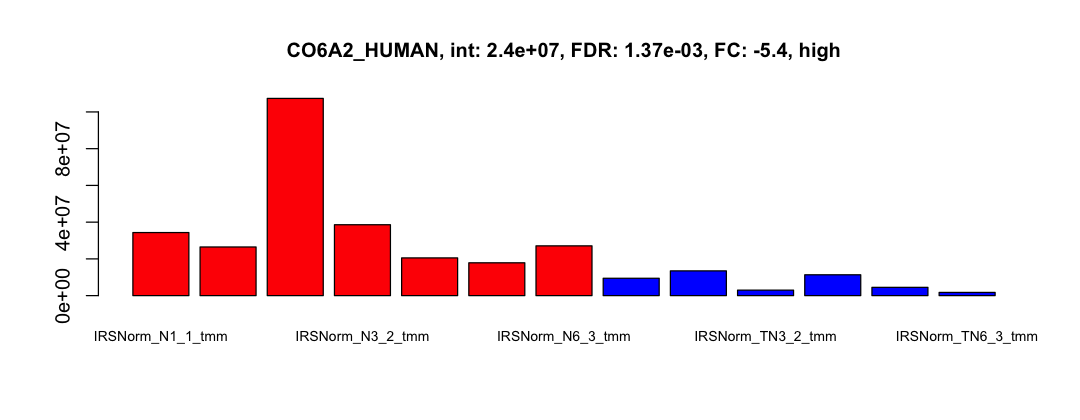

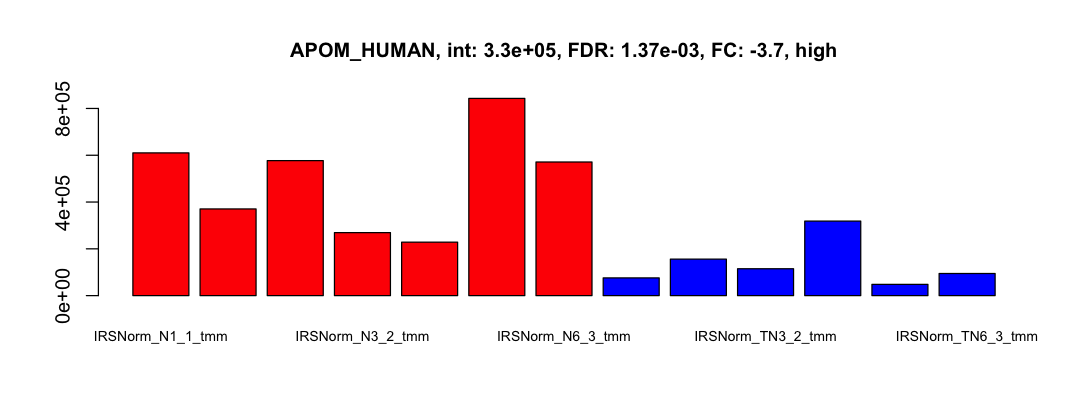

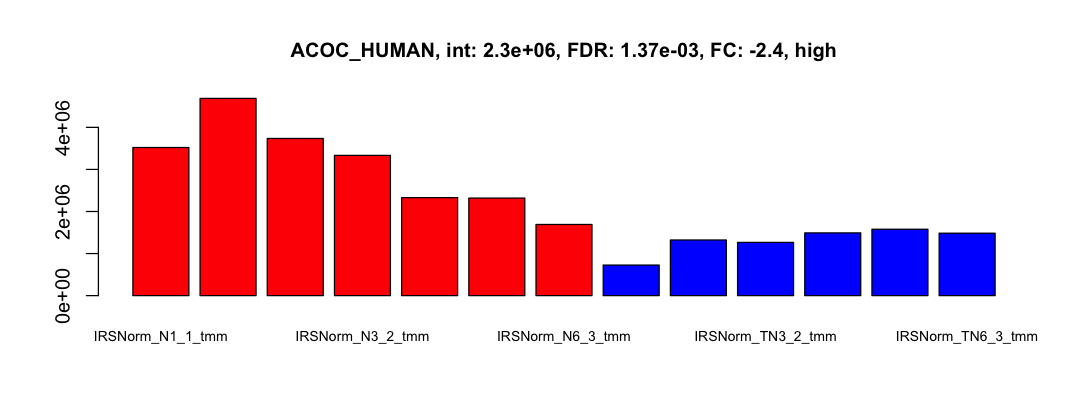

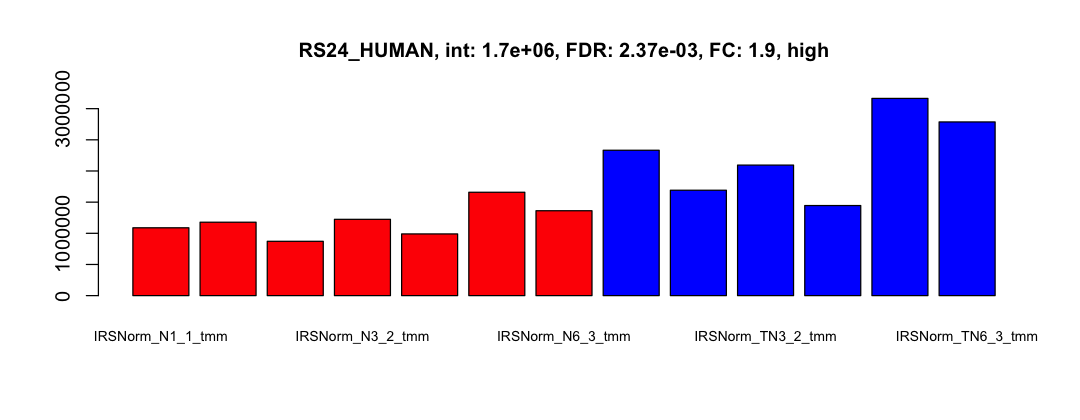

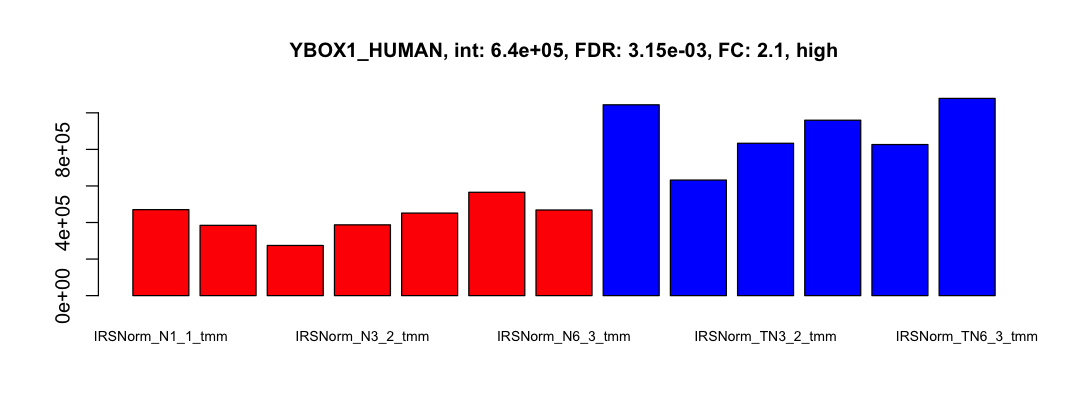

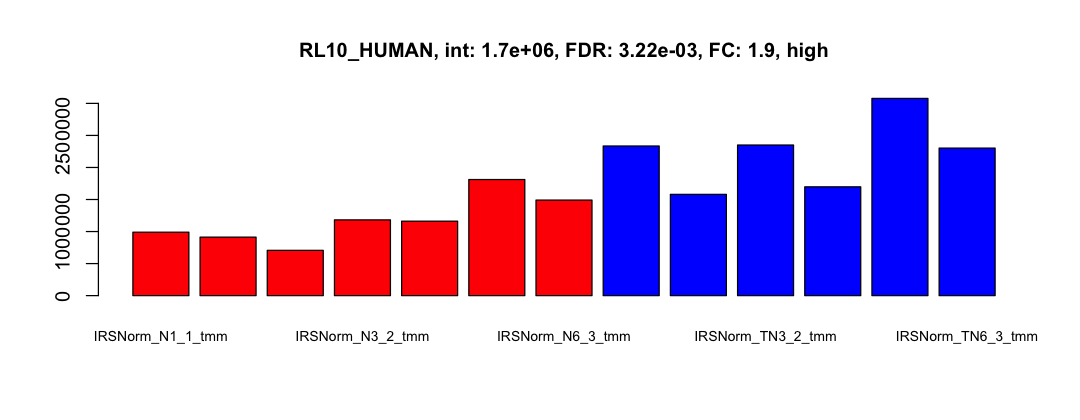

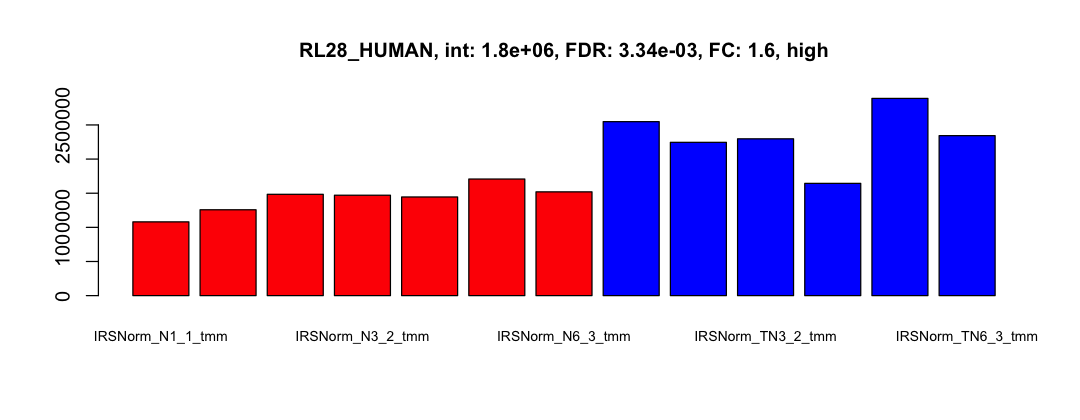

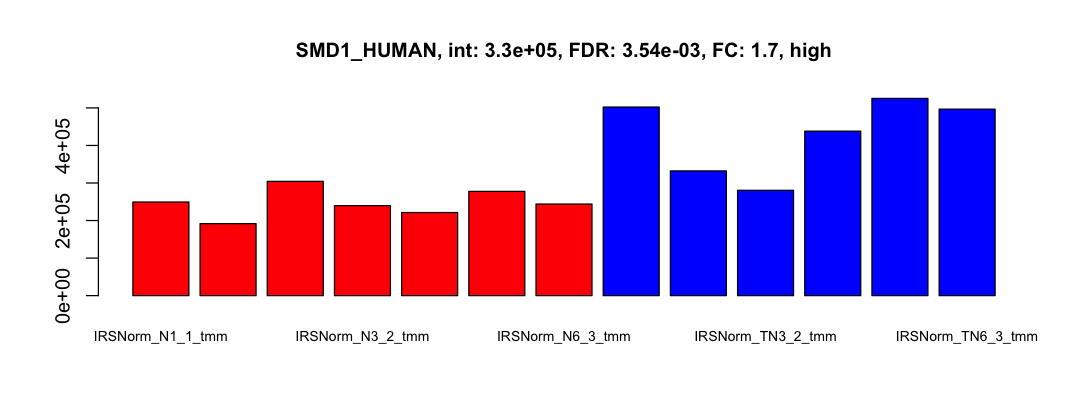

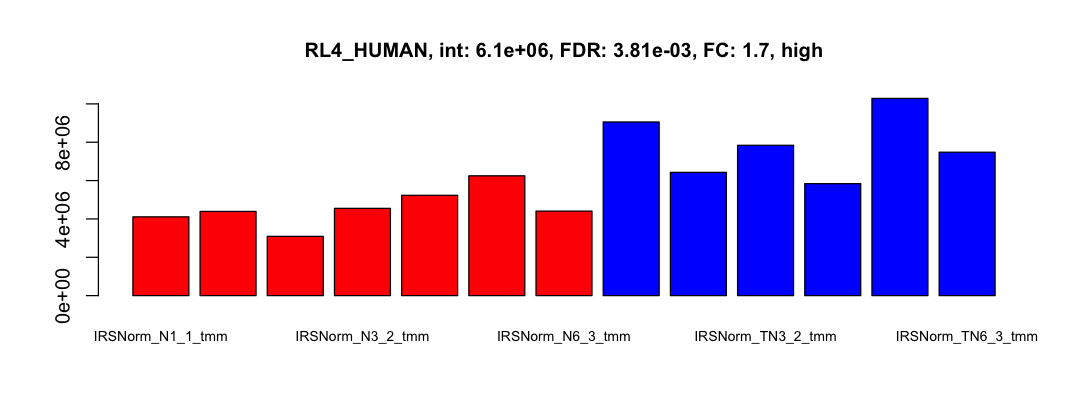

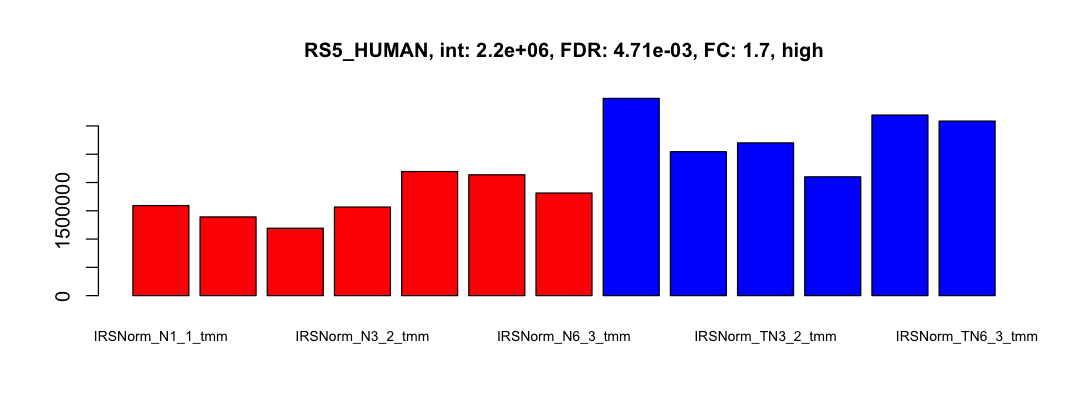

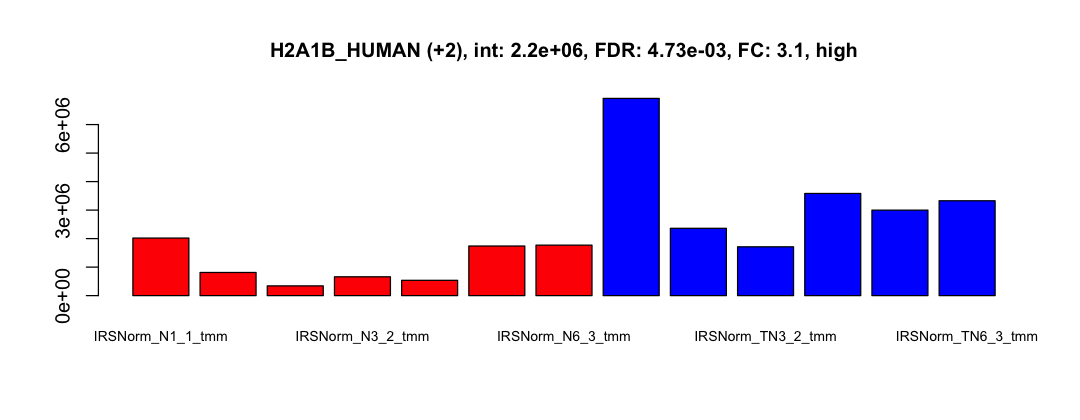

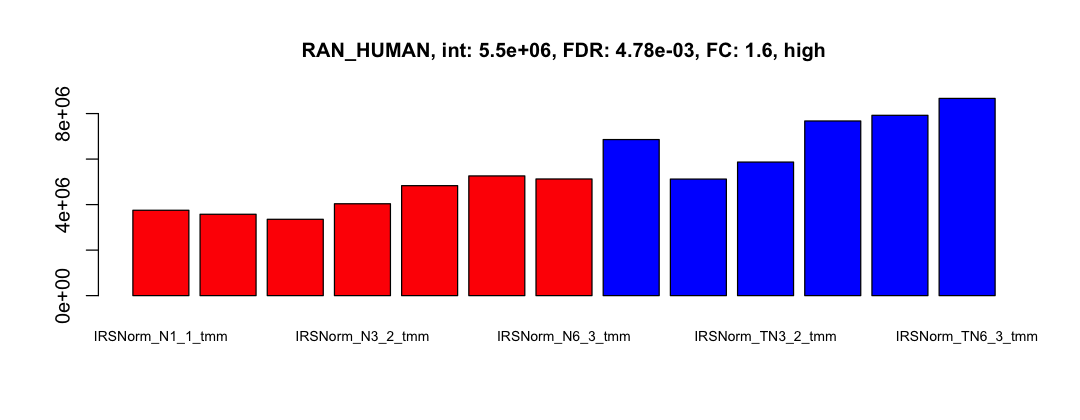

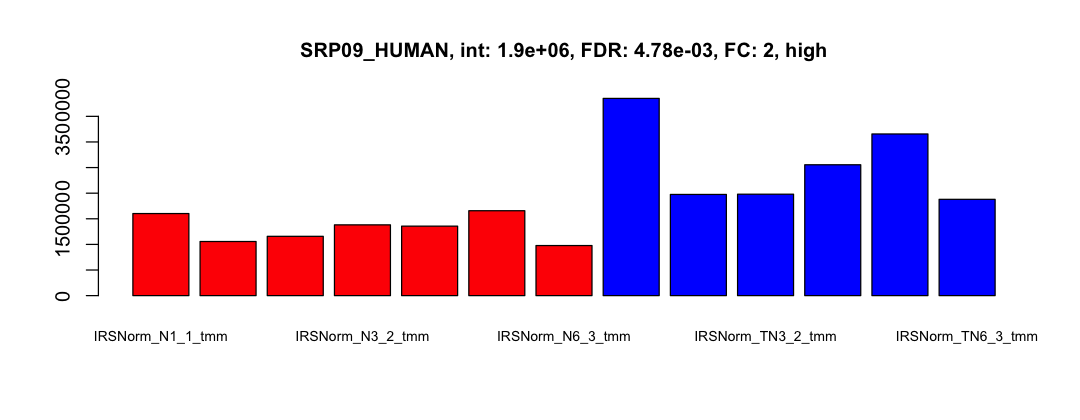

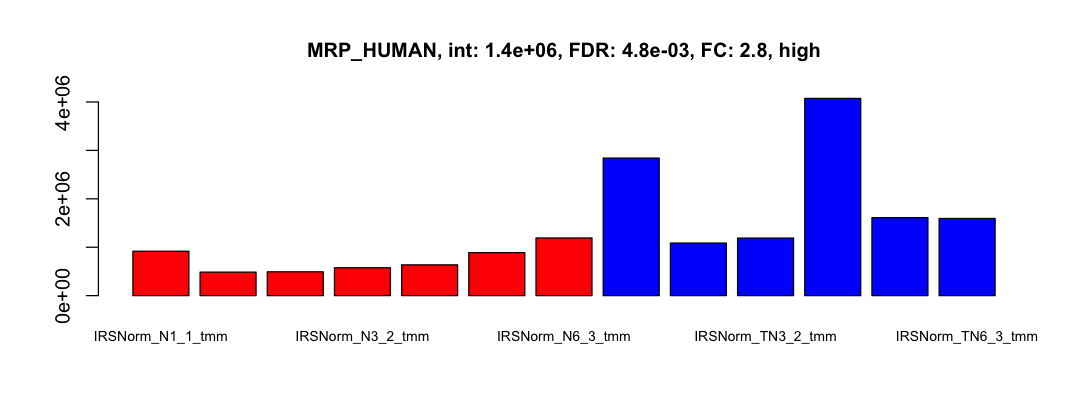

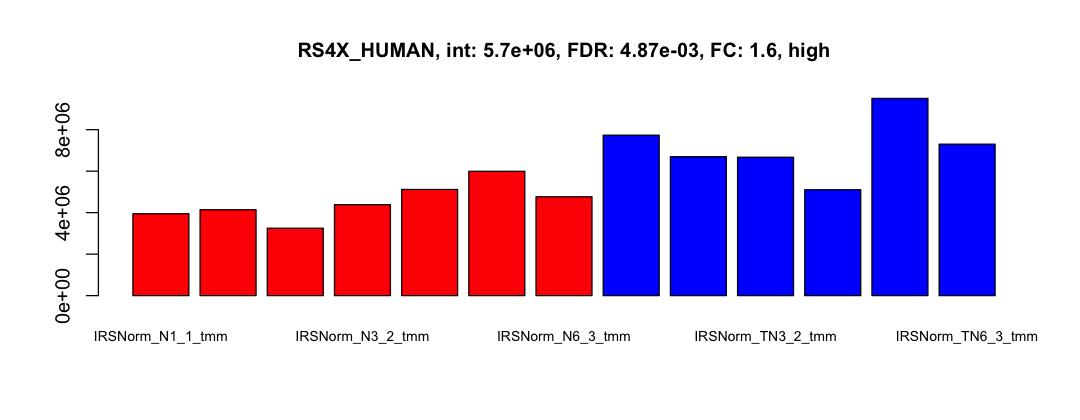

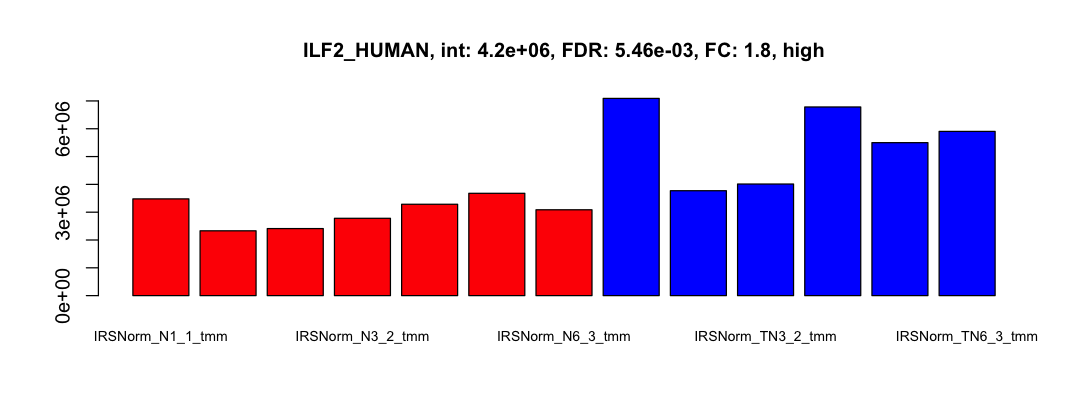

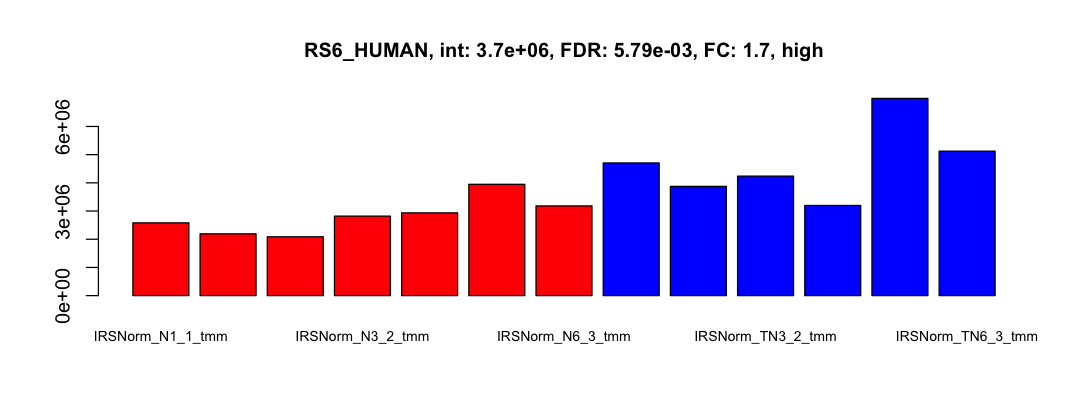

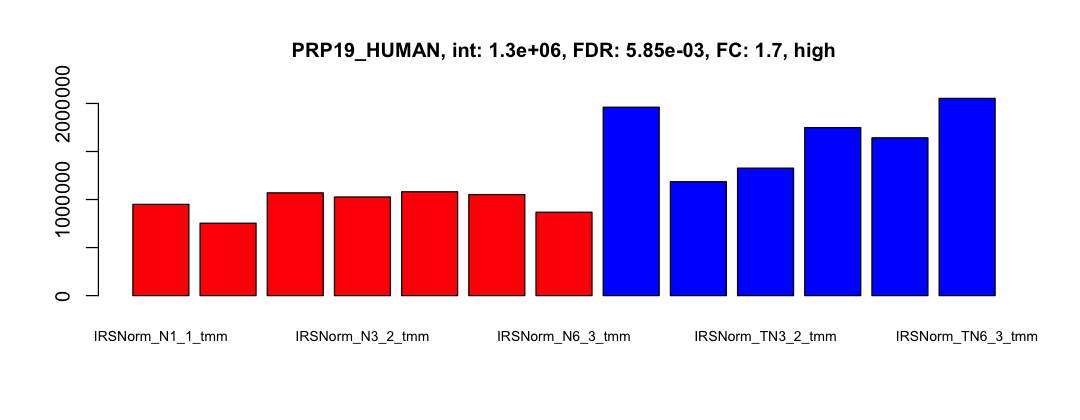

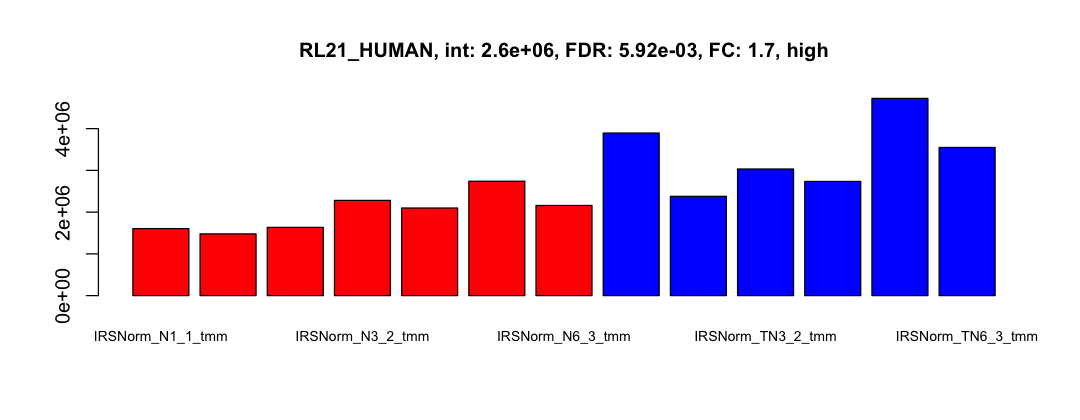

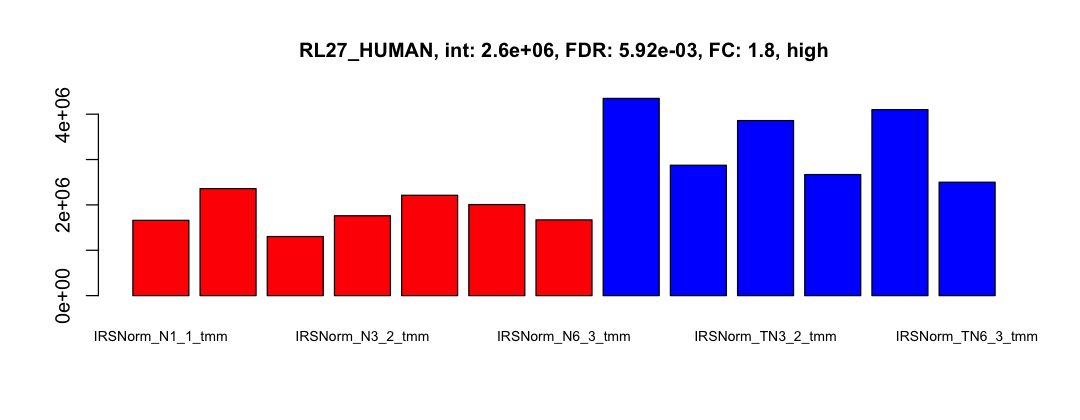

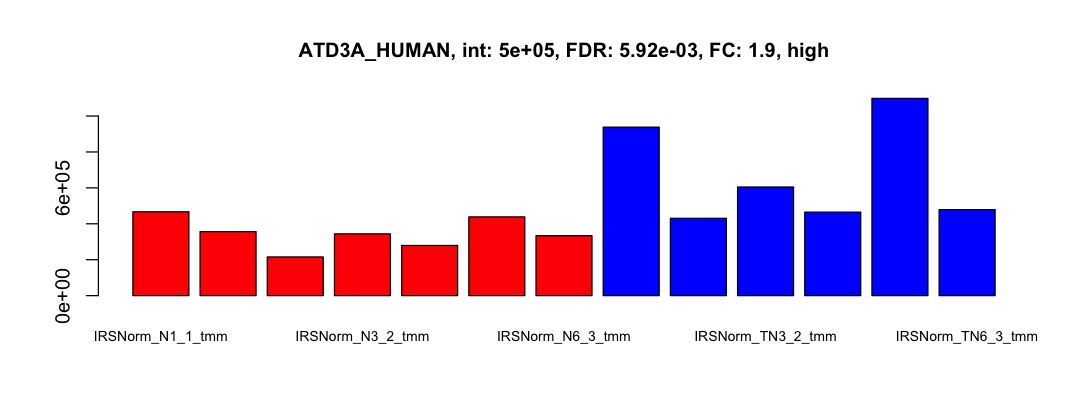

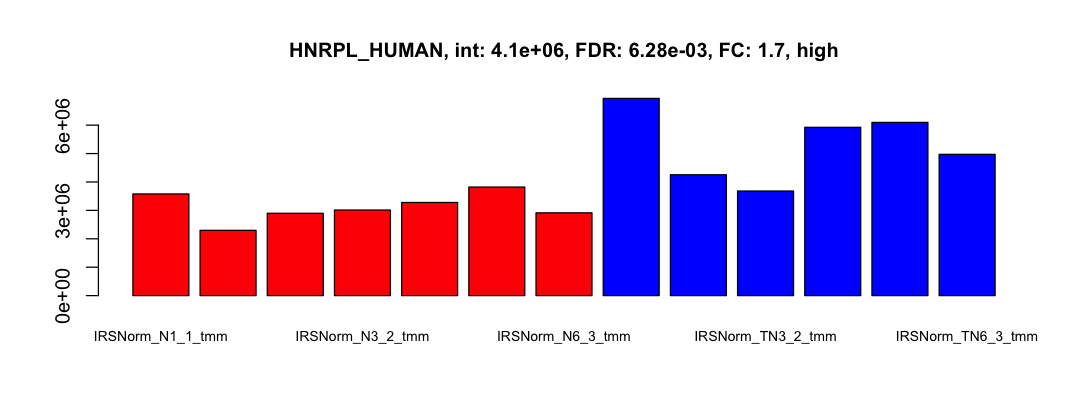

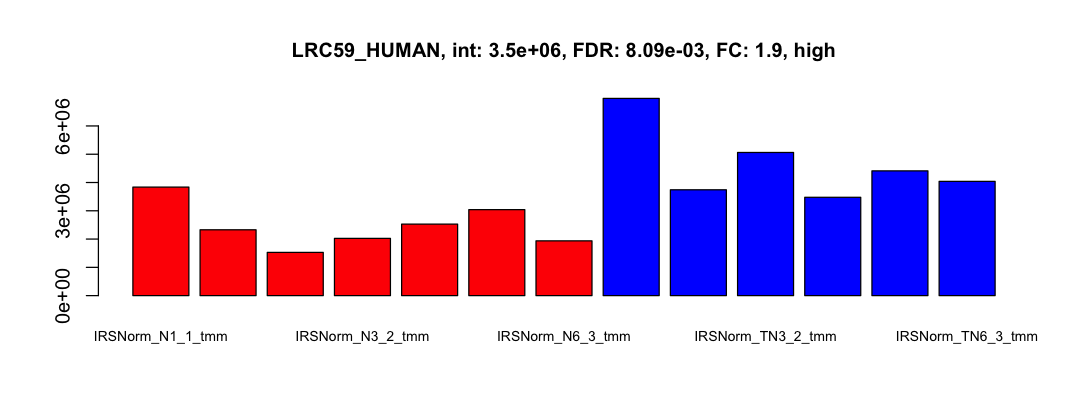

In [16]:
# look at the top 20 candidates in each direction (up in TN, then down in TN)
set_plot_dimensions(9, 3.5)
plot_top_tags(results, 7, 6, 20)
set_plot_dimensions(9, 9)

## <a name="N_MBC"></a> (2) Normal versus Metaplastic

We will do the same testing to compare normal tissue to metaplastic breast cancer samples.

Contrasts
Levels N - MP
    N   1    
    TN  0    
    MP -1

       N - MP
Down      358
NotSig   3316
Up        458

genes                 logFC      AveExpr  t         P.Value     
1671 sp|O14558|HSPB6_HUMAN  3.2235587 4.922487  8.084986 8.146713e-09
2195 sp|P23946|CMA1_HUMAN   2.9432712 4.613247  7.858342 1.429087e-08
1398 sp|Q969G5|CAVN3_HUMAN  2.4083081 6.207097  7.698105 2.134733e-08
1720 sp|P15088|CBPA3_HUMAN  2.6969867 5.390333  7.616709 2.620686e-08
2340 sp|O95810|CAVN2_HUMAN  2.5522141 3.860631  7.416605 4.354229e-08
428  sp|P46782|RS5_HUMAN   -0.9968950 8.562667 -7.265367 6.411704e-08
2061 sp|P42330|AK1C3_HUMAN  2.7207451 4.793372  7.208468 7.421831e-08
779  sp|P21399|ACOC_HUMAN   1.3089181 7.752598  7.144567 8.751139e-08
971  sp|Q13642|FHL1_HUMAN   2.9044082 6.863765  7.096752 9.902431e-08
175  sp|P36578|RL4_HUMAN   -0.9469987 9.971506 -7.022418 1.200655e-07
     adj.P.Val    B        
1671 2.707168e-05 10.248792
2195 2.707168e-05  9.712102
1398 2.707168e-05  9.342879
1720 2.707168e-05  9.143927
2340 3.598335e-05  8.644789
428  4.381001e-05  8.293298
2061 4.381001e-05  8.145198
779  4.519964e-05  7.995589
971  4.546316e-05  7.875872
175  4.597244e-05  7.689013

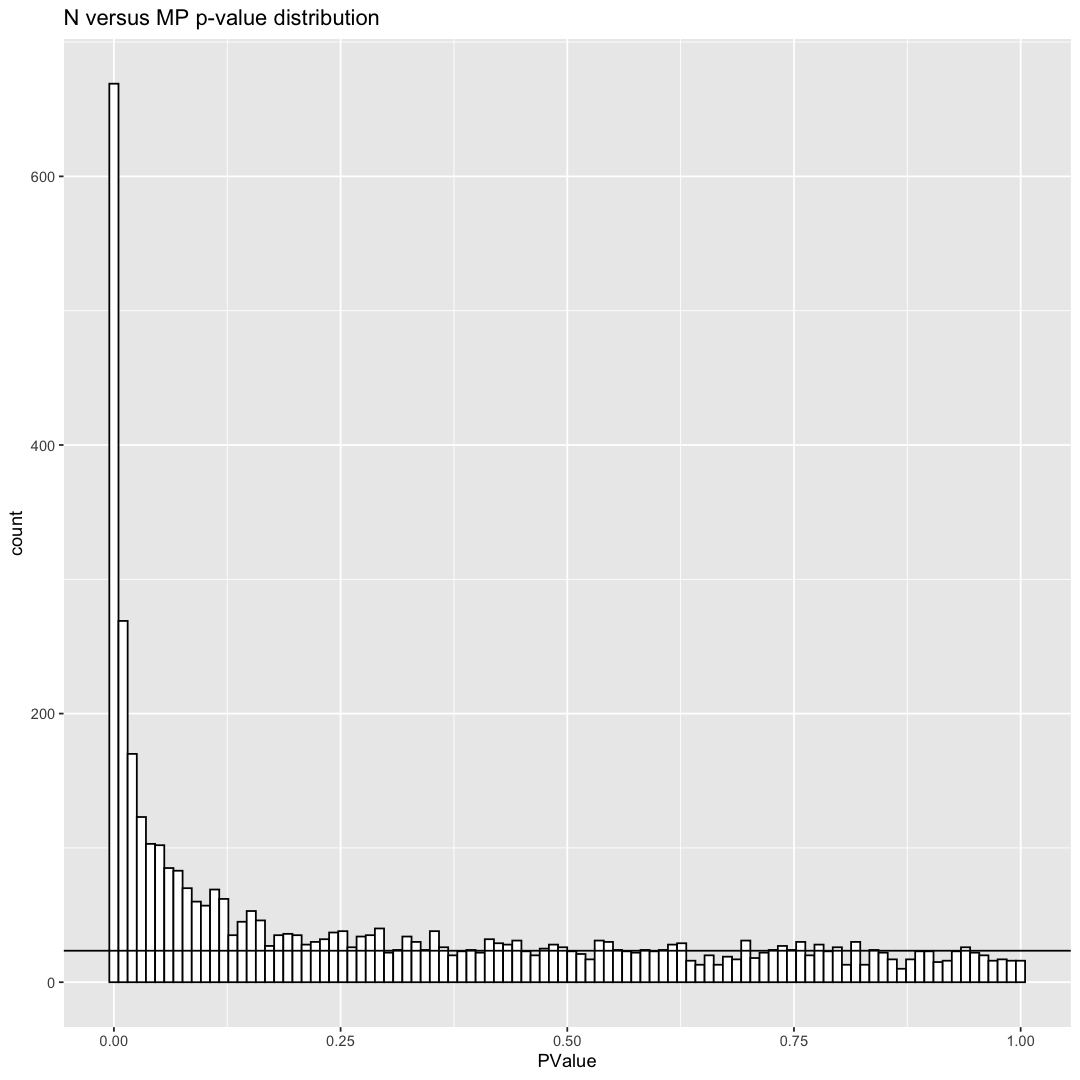

In [17]:
# make the contrast
contrast <- makeContrasts(N-MP, levels = design)
contrast

# get the fit for the contrast of interest
vfit2 <- contrasts.fit(vfit, contrast)

# do the empirical Bayes moderation of the test statistic (with trended variance)
efit2 <- eBayes(vfit2)

# grab the information in topTable so we can get the data to plot candidates
# the coef parameter has to do with the contrast of interest
# specify no sorting of results and a number that is longer than the data table
tt_limma <- topTable(efit2, coef = 1, sort.by = "none", number = Inf)

# let's see how many up and down candidates, and the top tags
summary(decideTests(efit2, p.value = 0.05))
topTable(efit2)

# get the results summary
results <- collect_results_limma(tmt_tmm, tt_limma, N, "N", MP, "MP", accessions)

# check the p-value distribution
ggplot(results, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(results$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("N versus MP p-value distribution") # check the p-value distribution

### We have more candidates

We have 816 candidates in this comparison. The p-value distribution looks better. 


## Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data) and also accumulate all of the three comparisons into `all_results`.

In [18]:
# make column names unique by adding comparison
results_temp  <- results
colnames(results_temp) <- str_c(colnames(results), "_N_MP")

# accumulate the testing results
all_results <- cbind(all_results, results_temp)

### Count candidates and look at fold-change distributions

candidate n   
1 high       411
2 med        405
3 low        320
4 no        2996

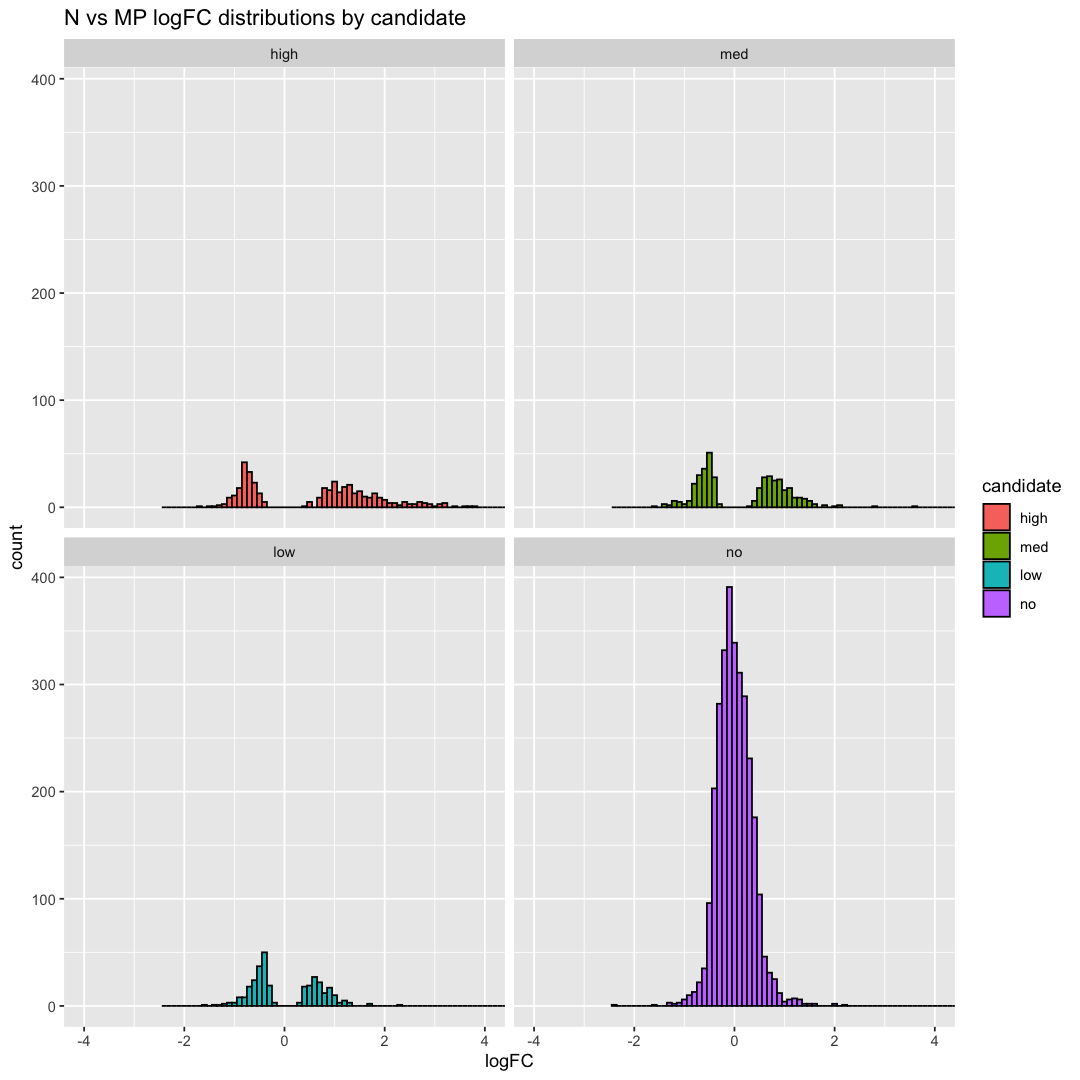

In [19]:
# see how many candidates by category
results %>% count(candidate)

# plot log2 fold-changes by category
ggplot(results, aes(x = logFC, fill = candidate)) +
  geom_histogram(binwidth=0.1, color = "black") +
  facet_wrap(~candidate) +
  coord_cartesian(xlim = c(-4, 4)) +
  ggtitle("N vs MP logFC distributions by candidate")

### MA plots

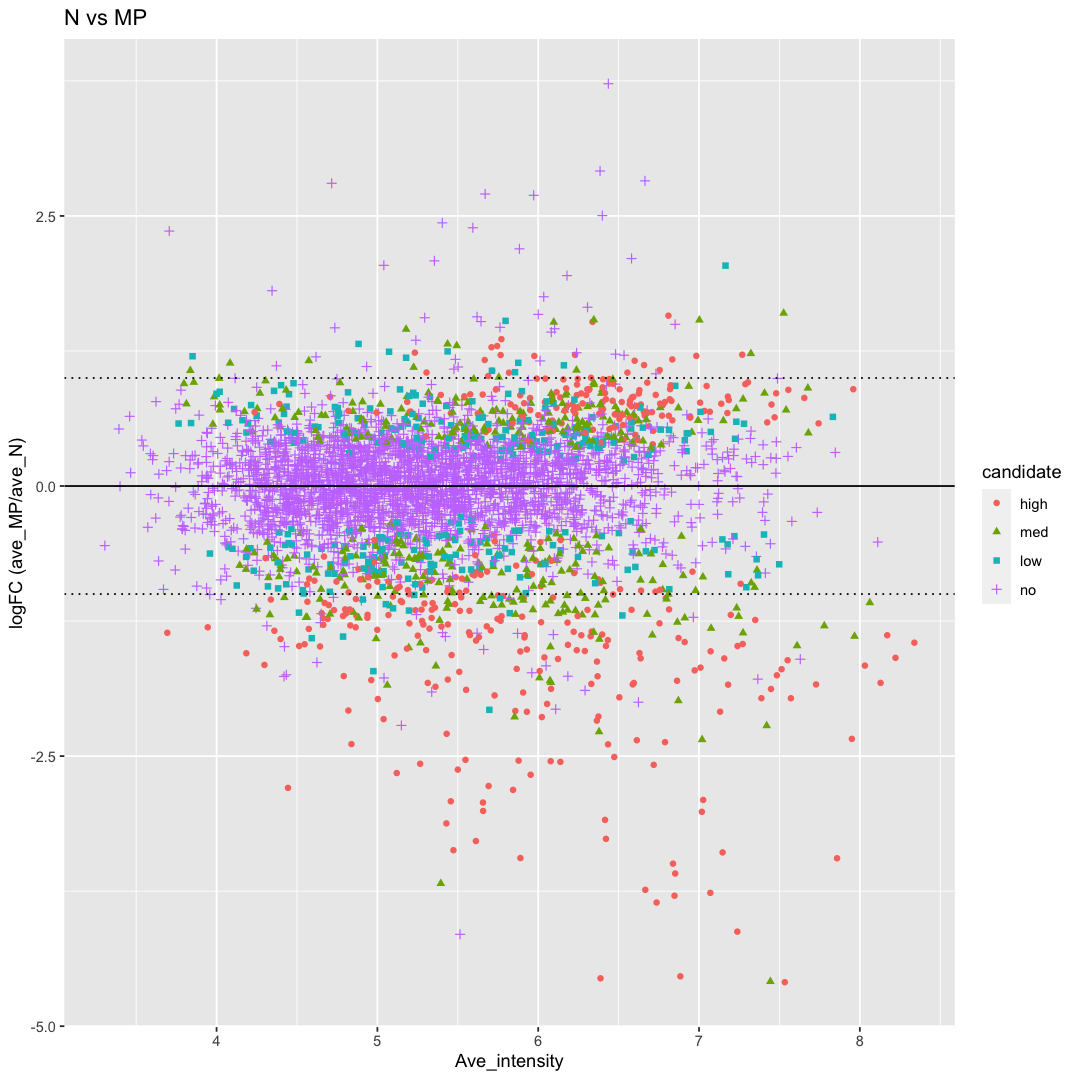

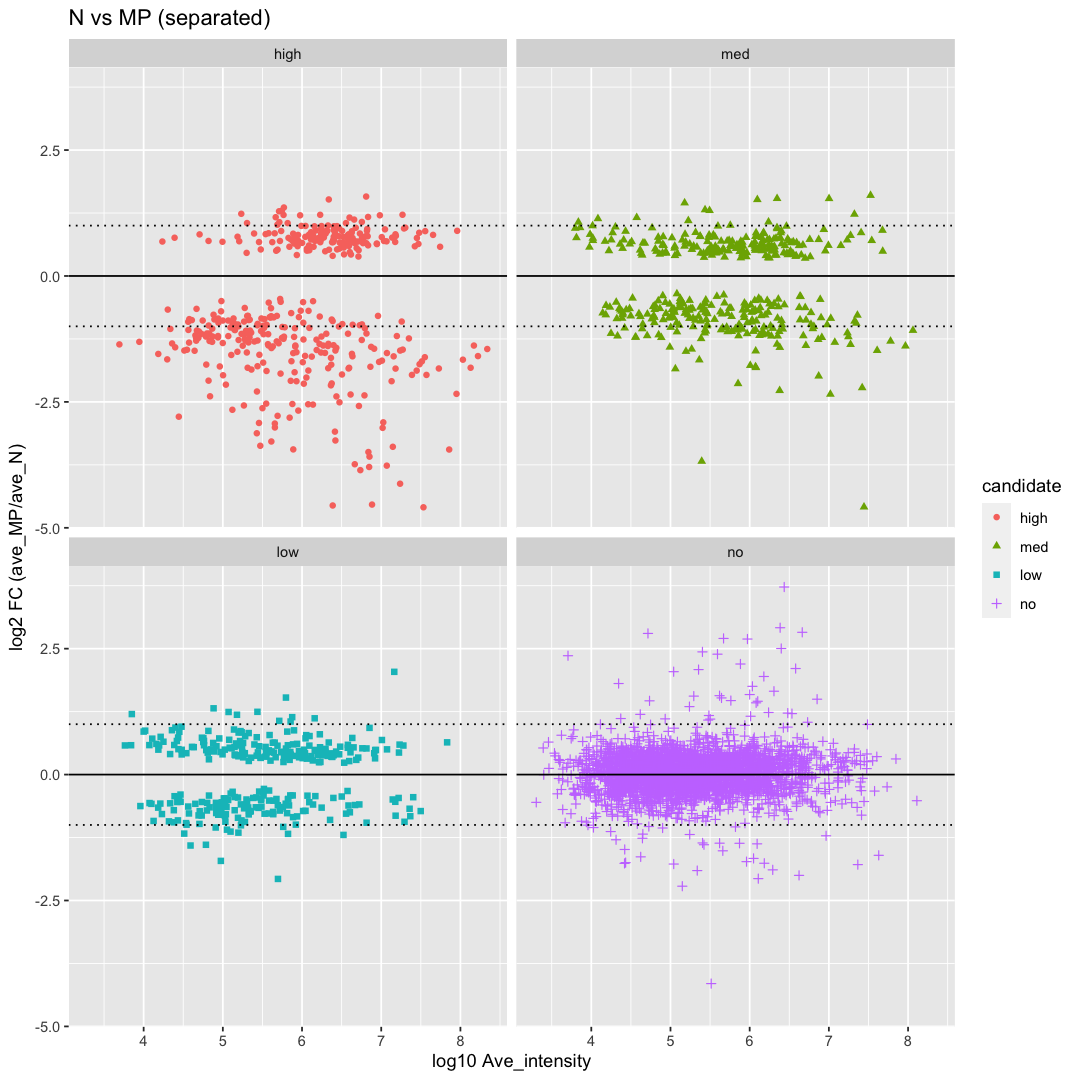

In [20]:
# make MA plots
MA_plots(results, "ave_N", "ave_MP", "N vs MP")

### Scatter plots

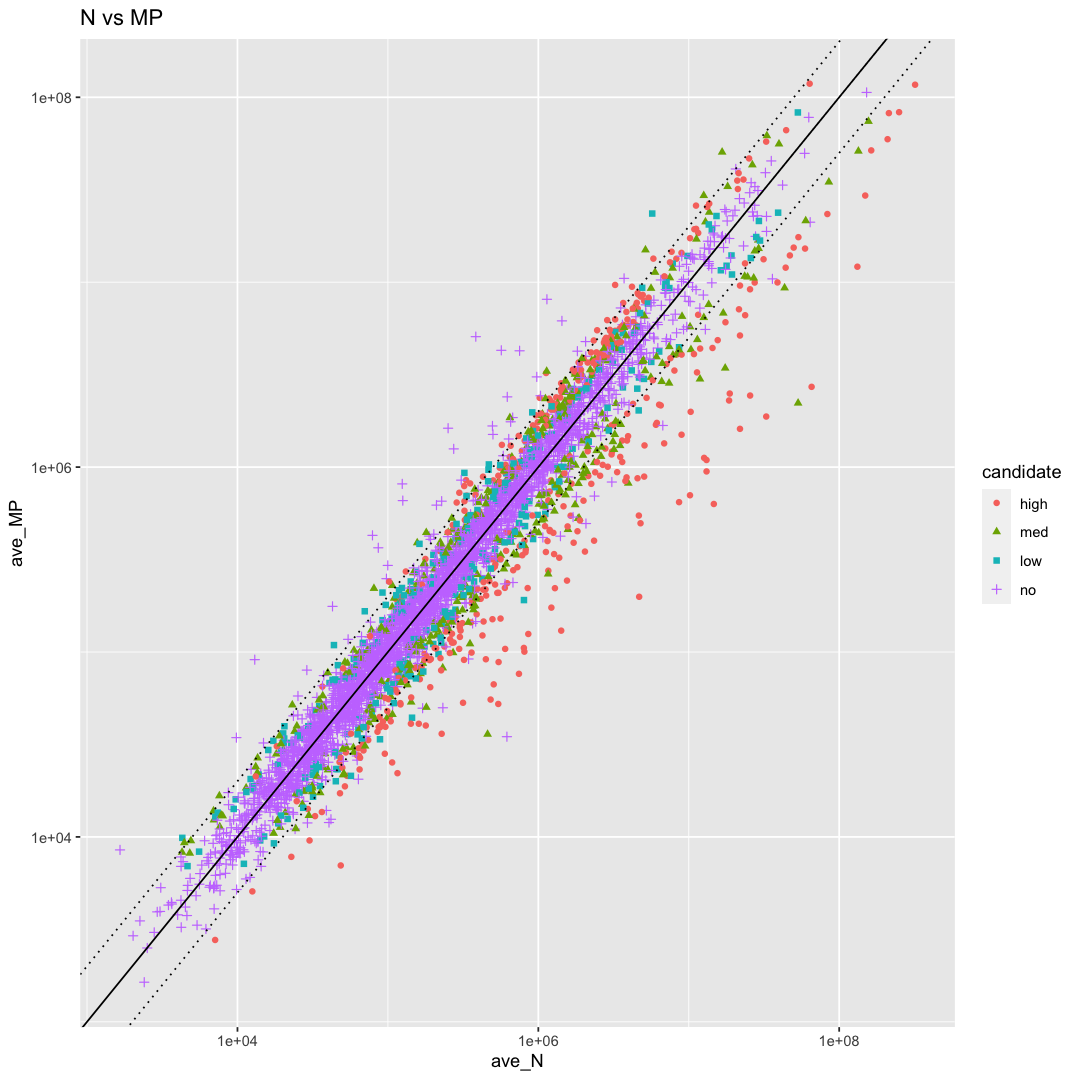

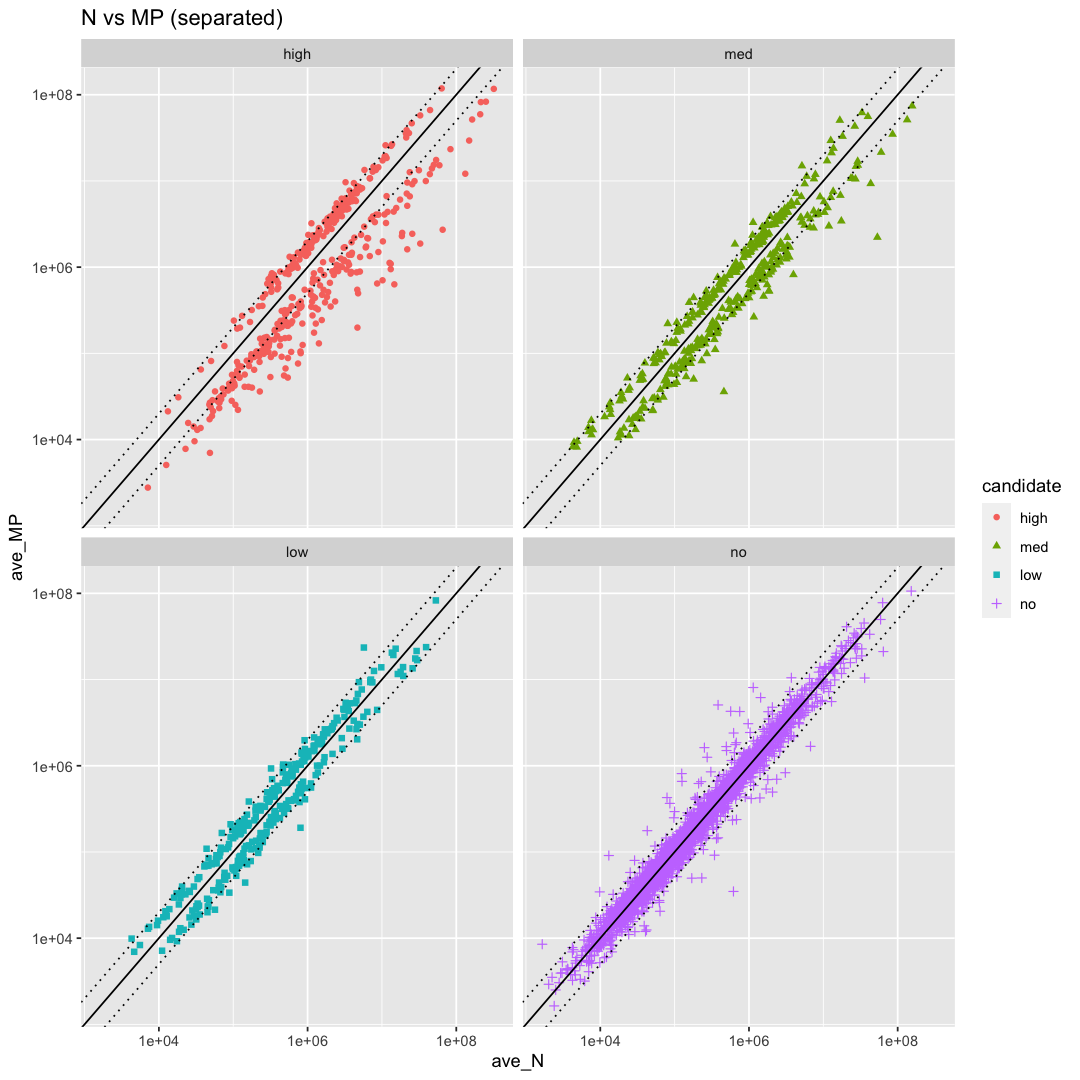

In [21]:
# make scatter plots
scatter_plots(results,  "ave_N", "ave_MP", "N vs MP")

### Volcano plot

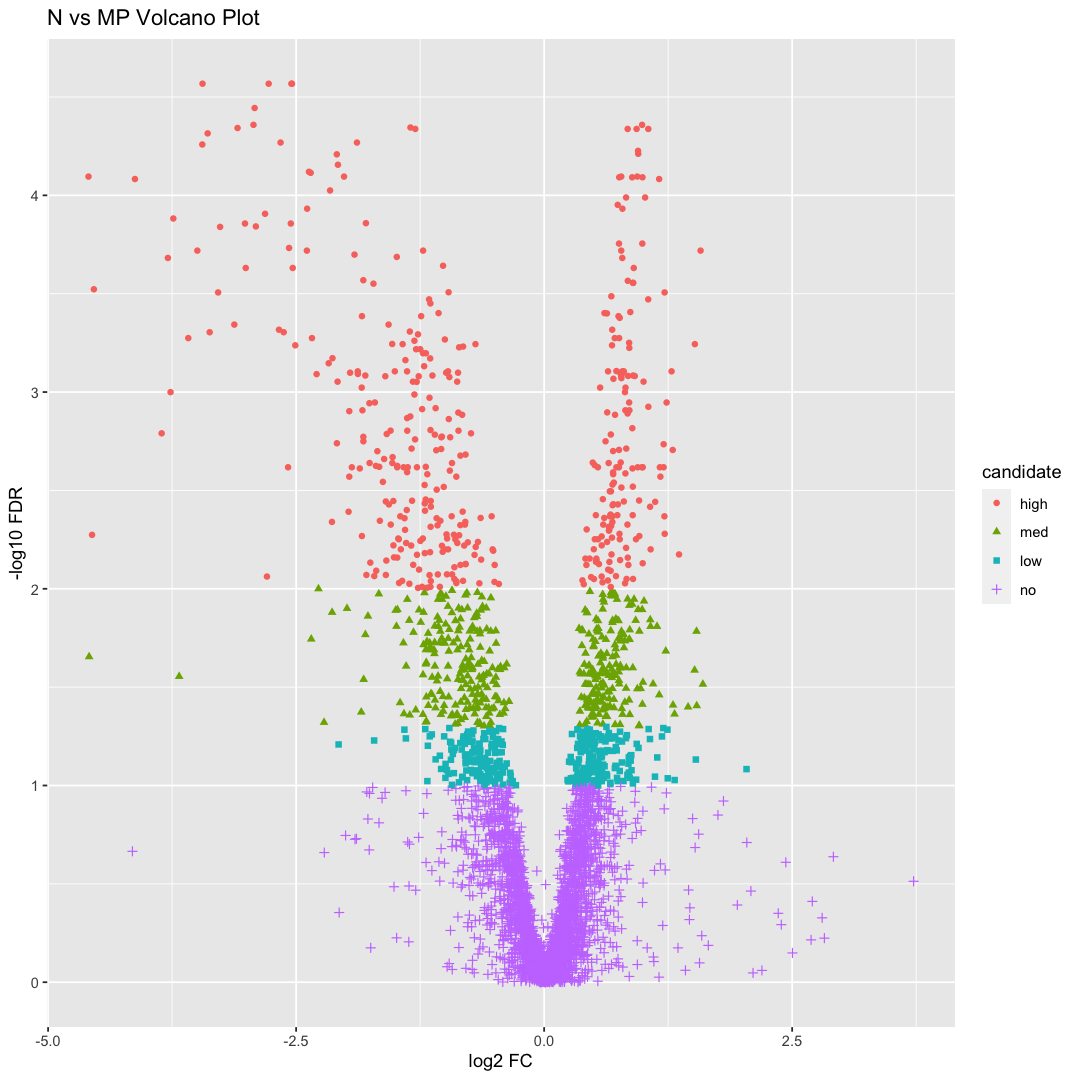

In [22]:
# make a volcano plot
volcano_plot(results,  "ave_N", "ave_MP", "N vs MP")

### The down-regulated candidates look better

We have robust down-regulation in breast cancer compared to normal tissue. We may have more DE candidates compared to the first comparison because we have 14 MBC samples compared to 6 for triple negative. Generally, we should have more statistical power with larger replicate numbers (all things being equal). Up-regulated candidates are not as distinct compared to non-DE candidates as are the down-regulated proteins. 

### Check some individual protein expression

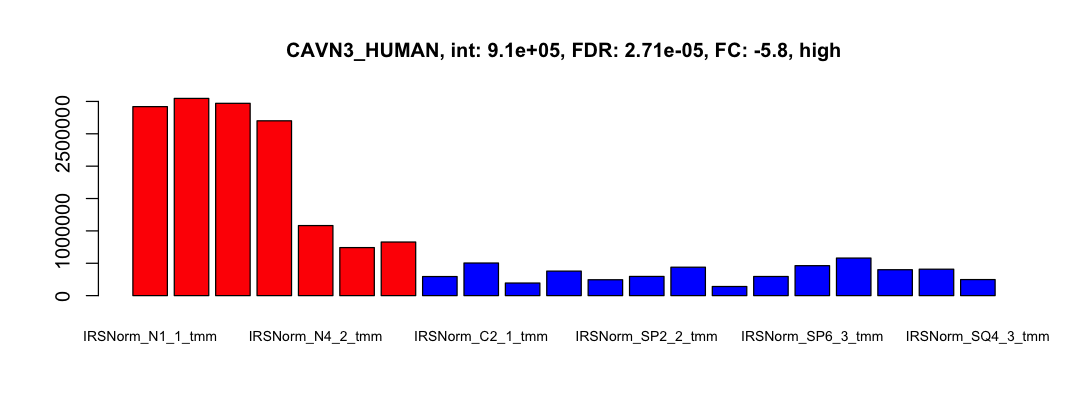

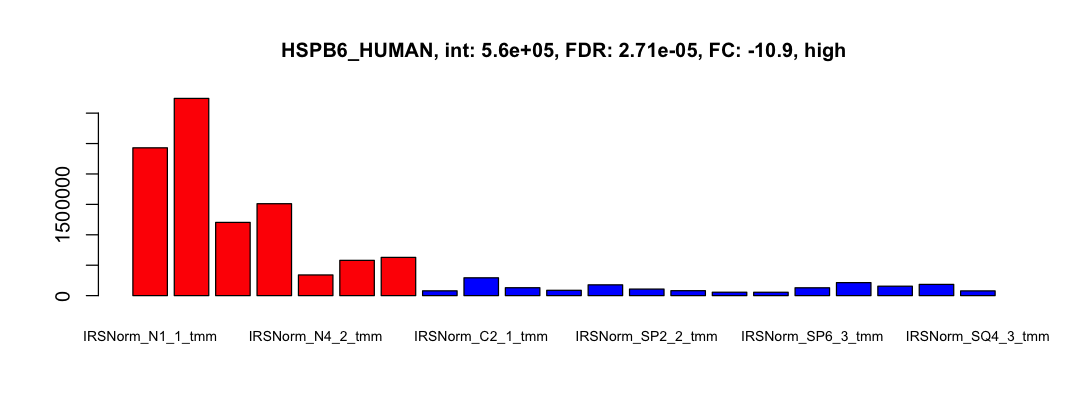

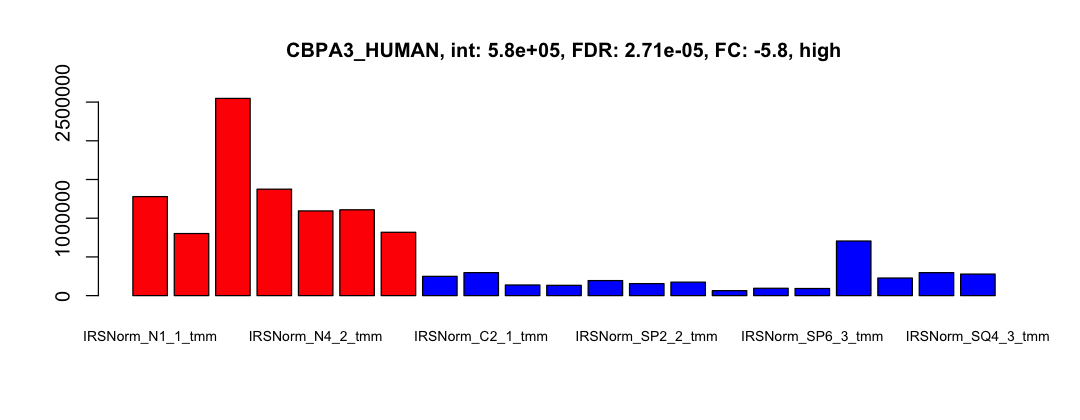

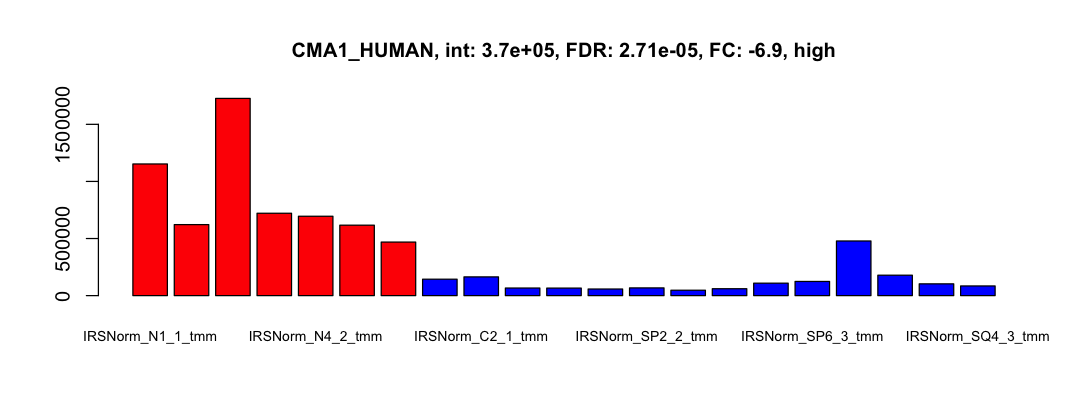

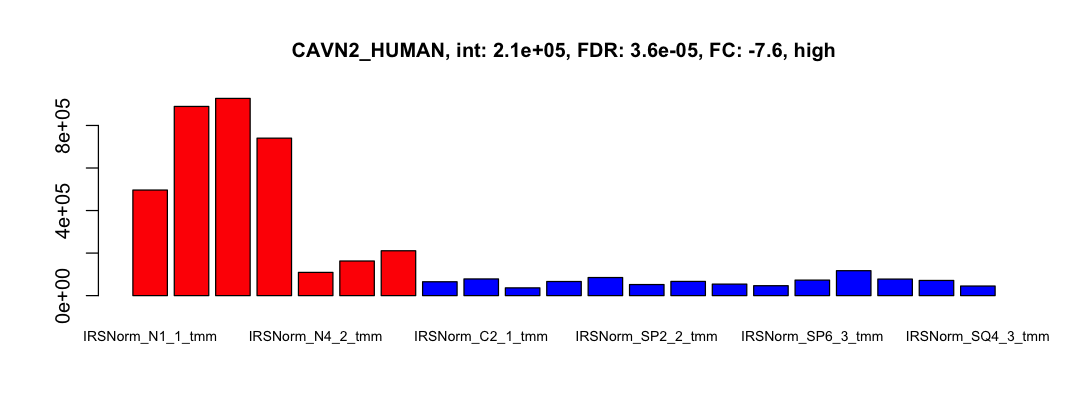

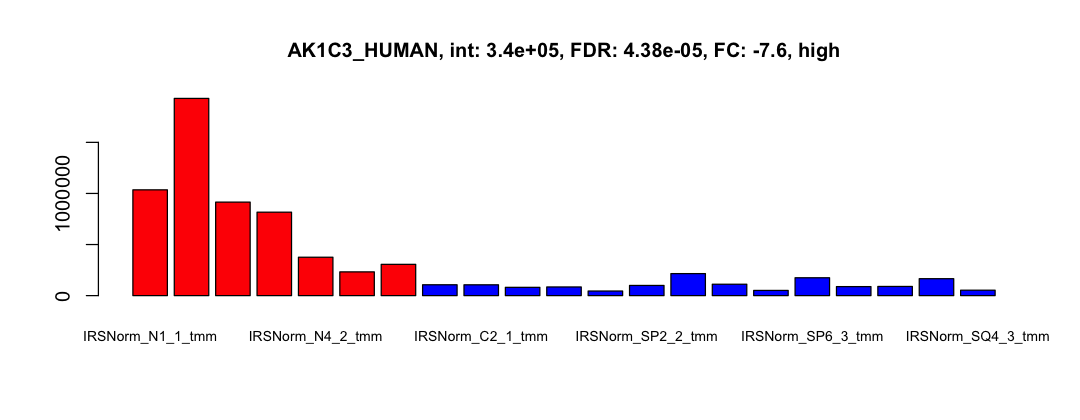

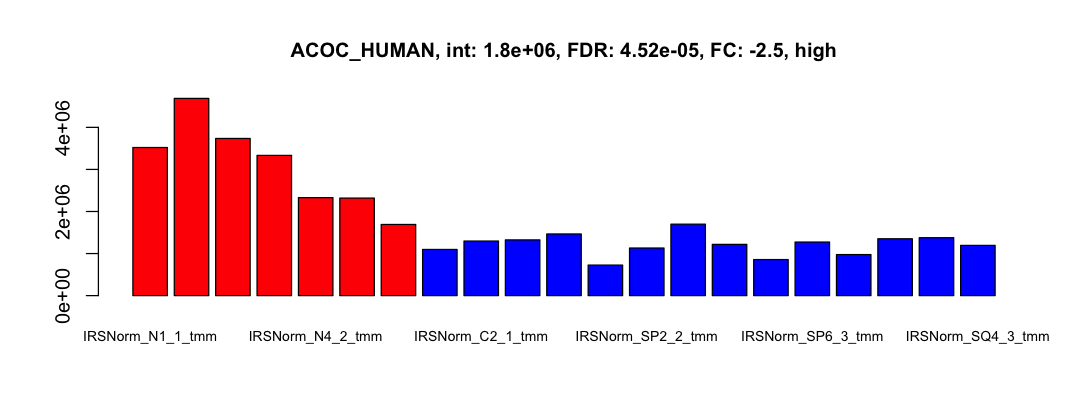

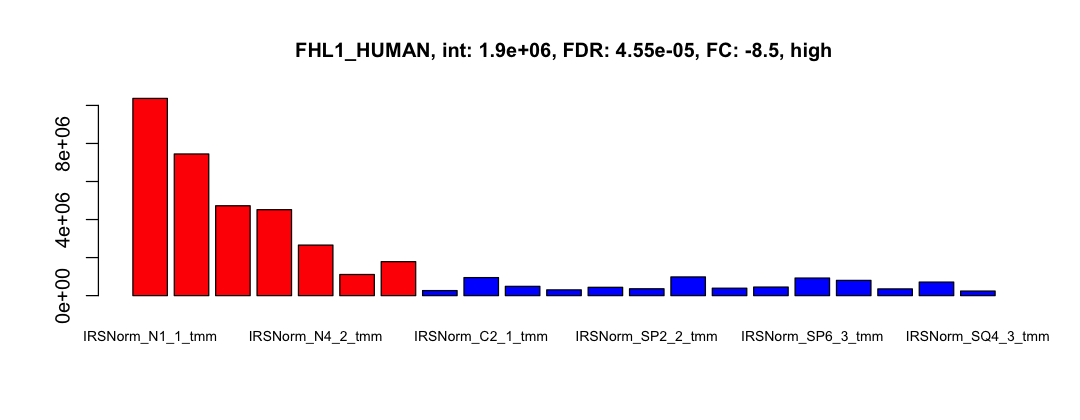

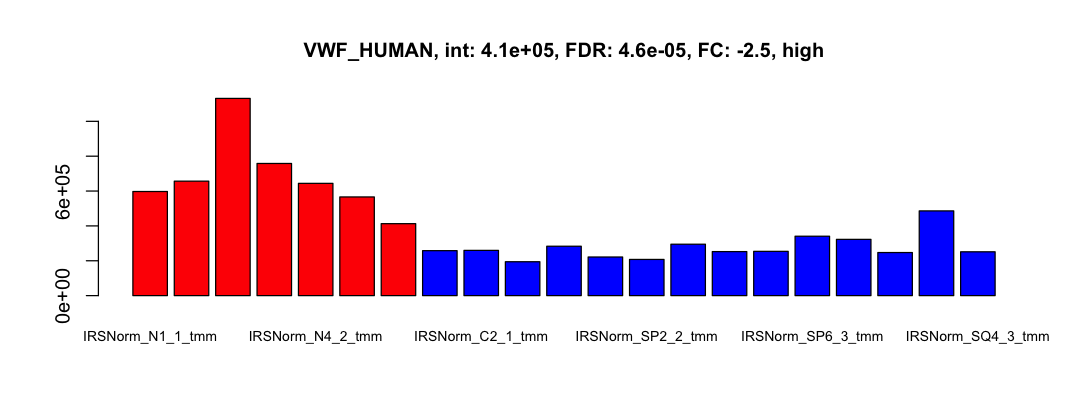

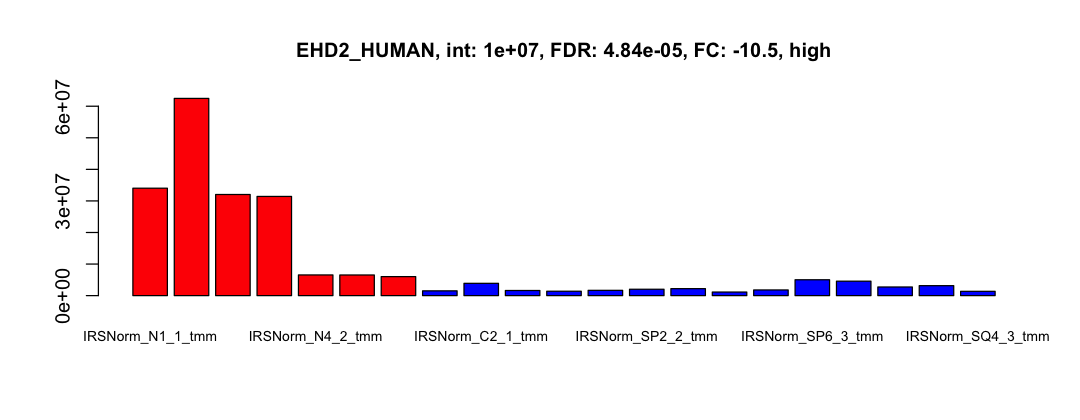

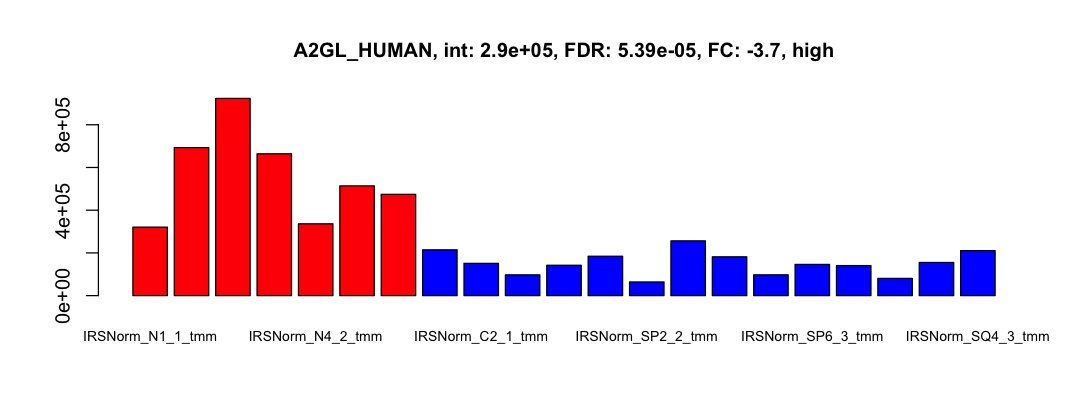

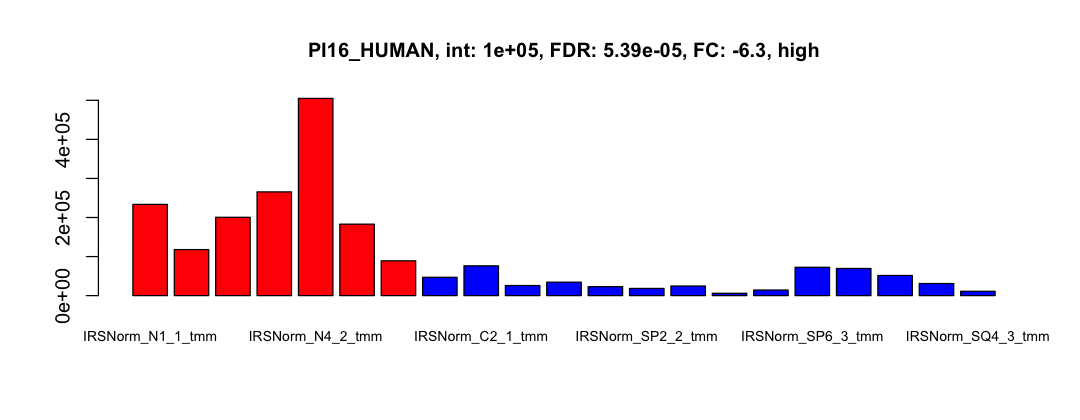

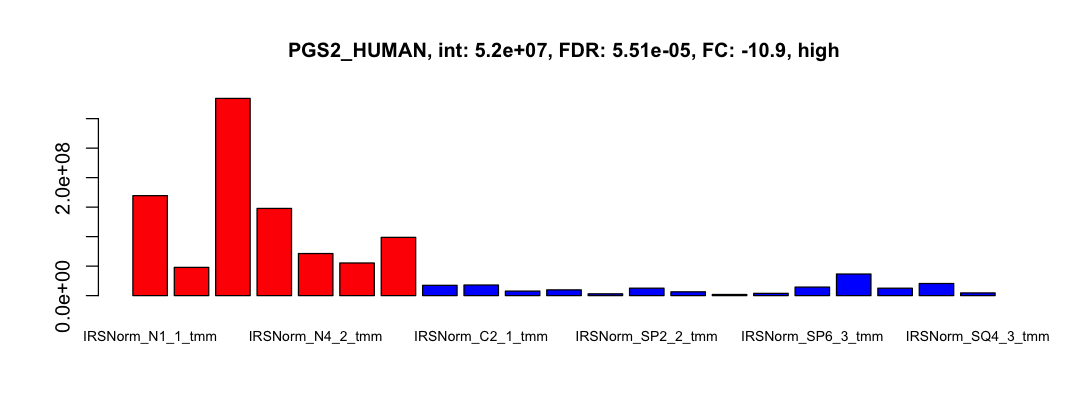

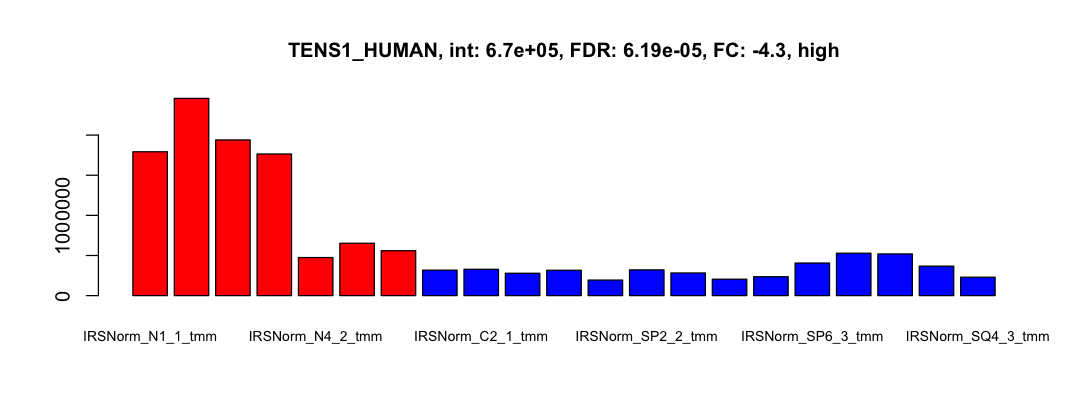

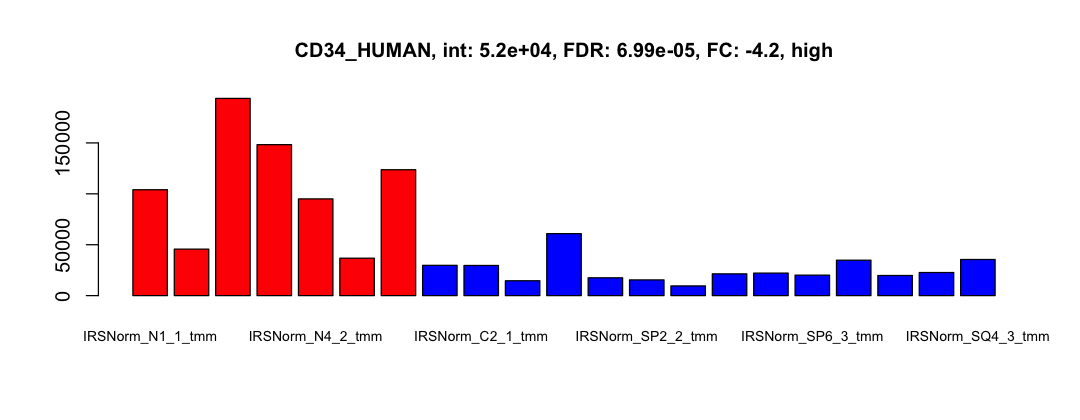

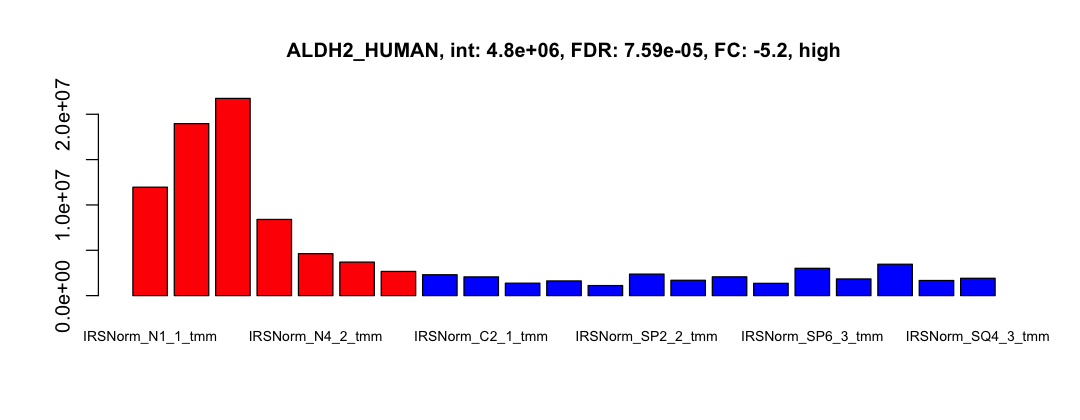

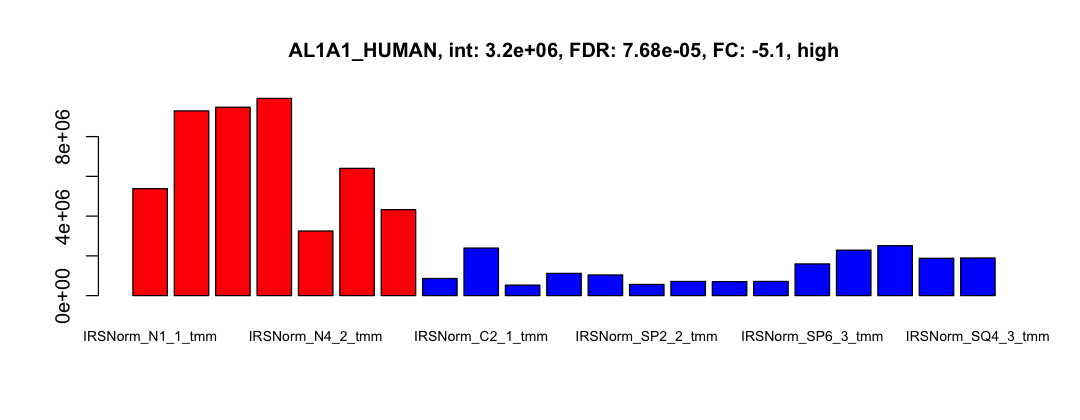

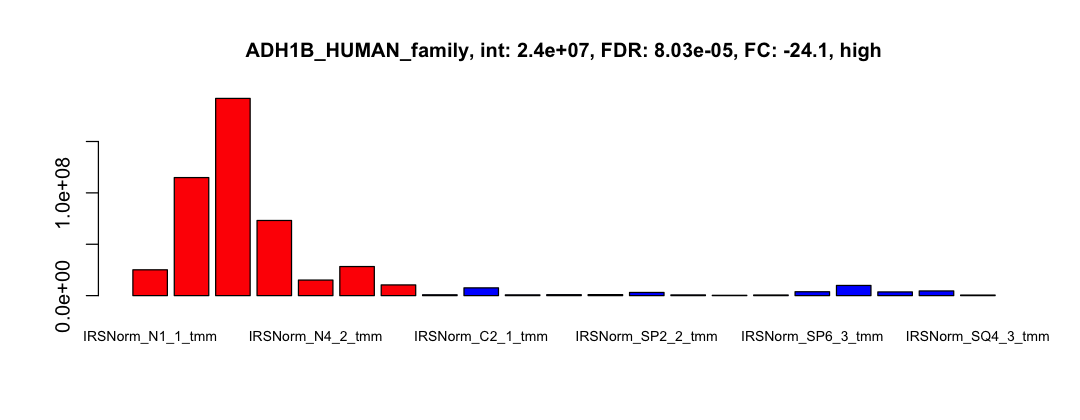

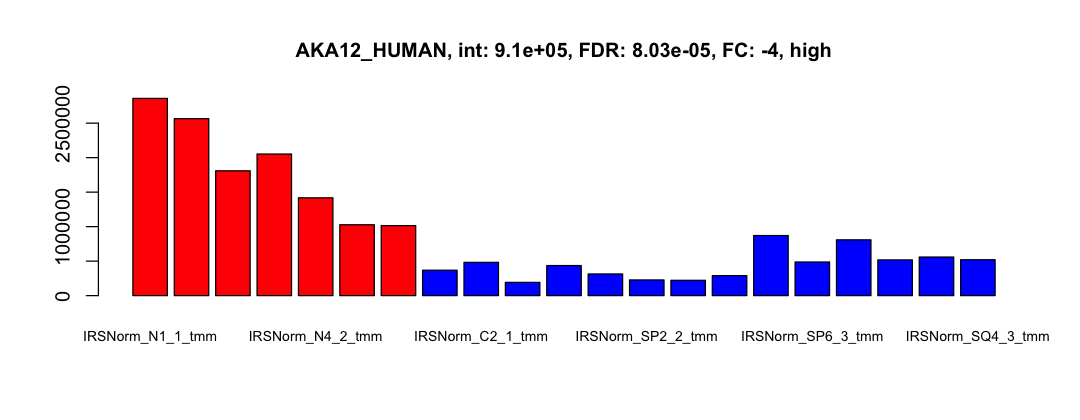

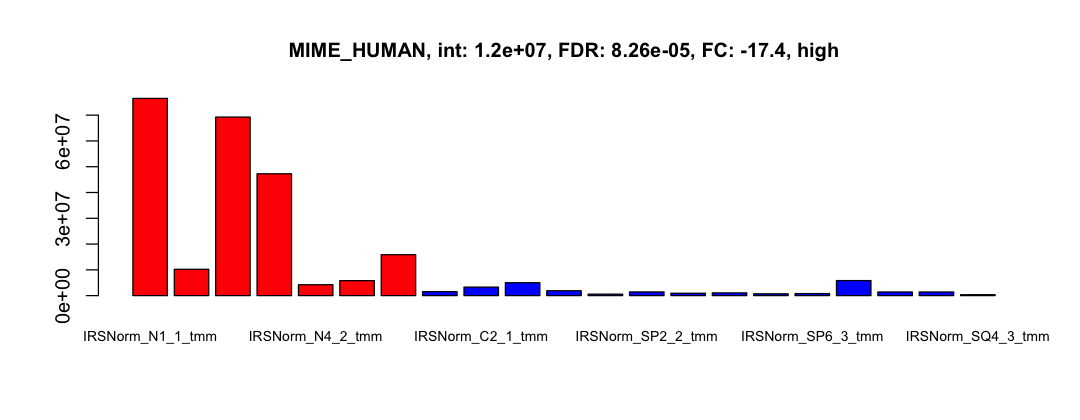

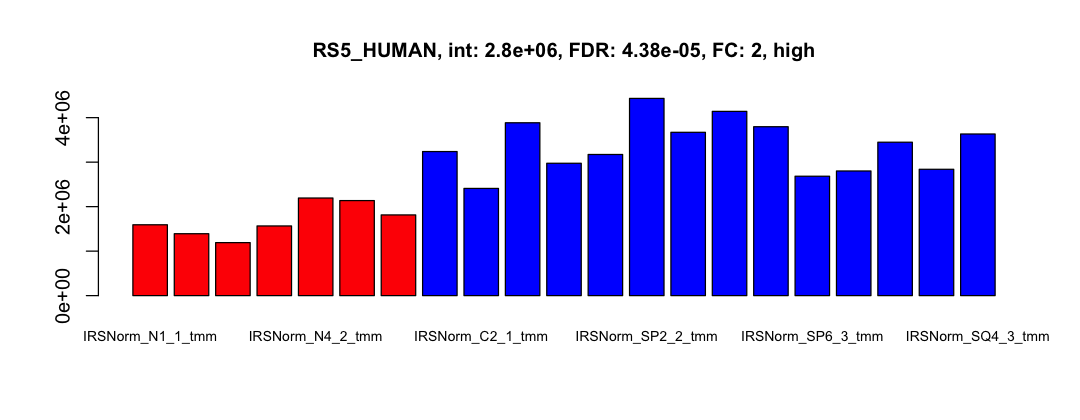

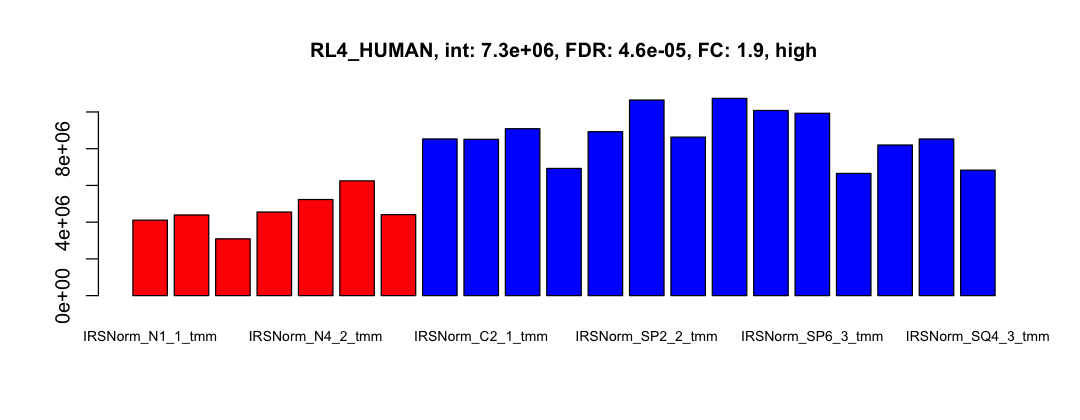

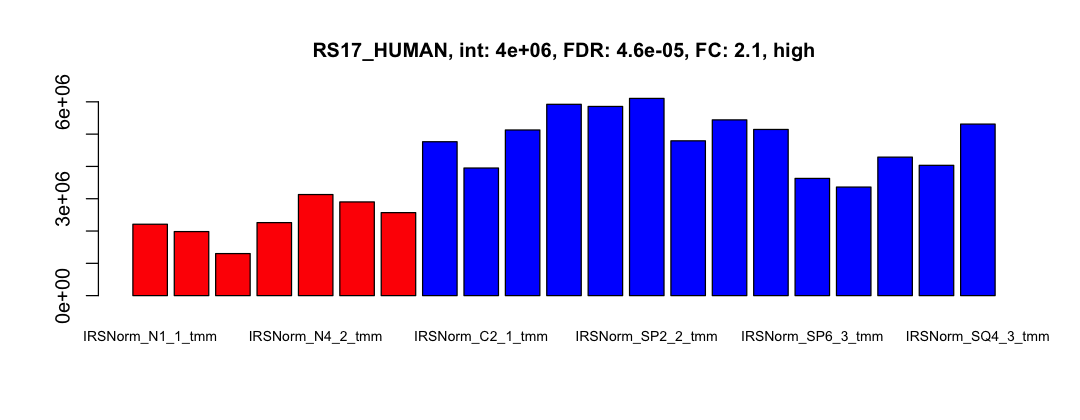

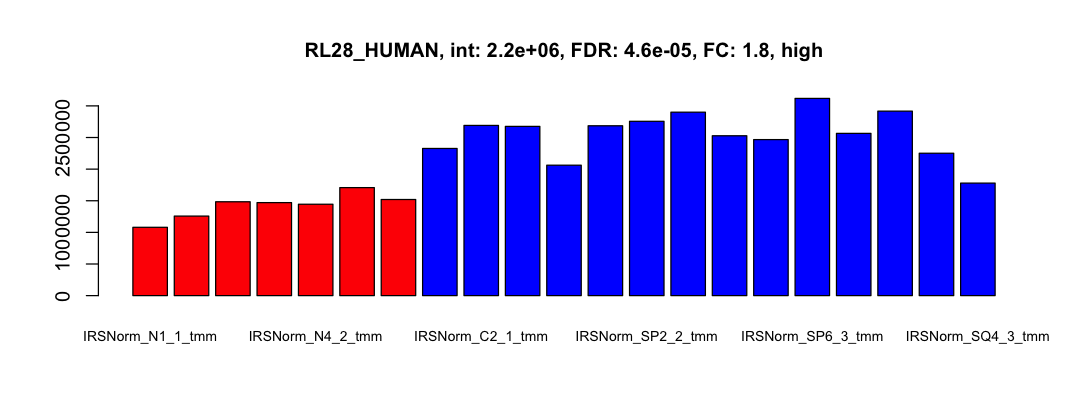

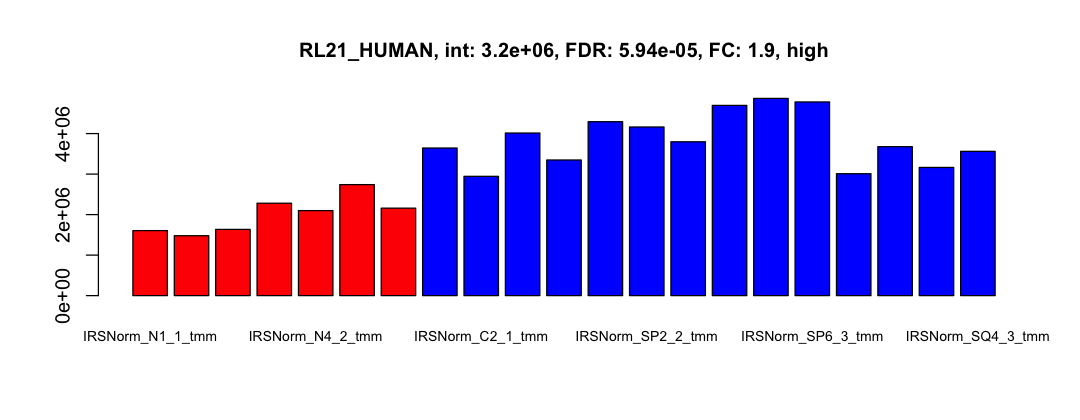

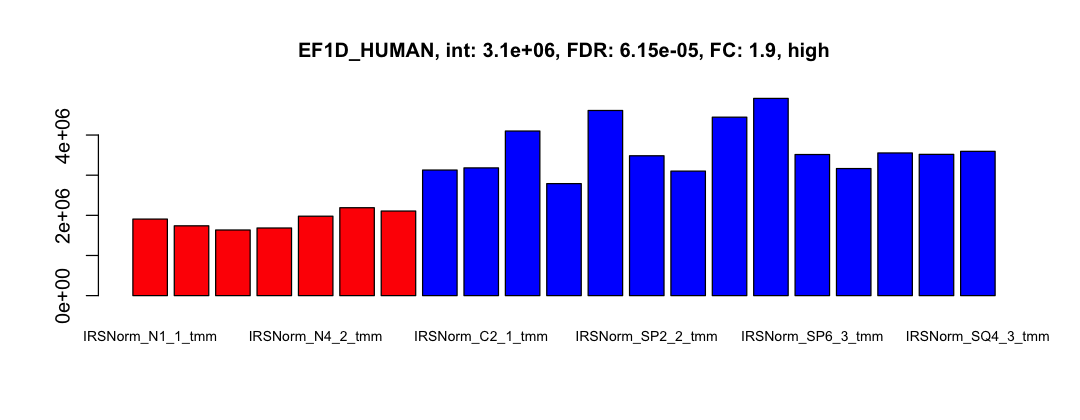

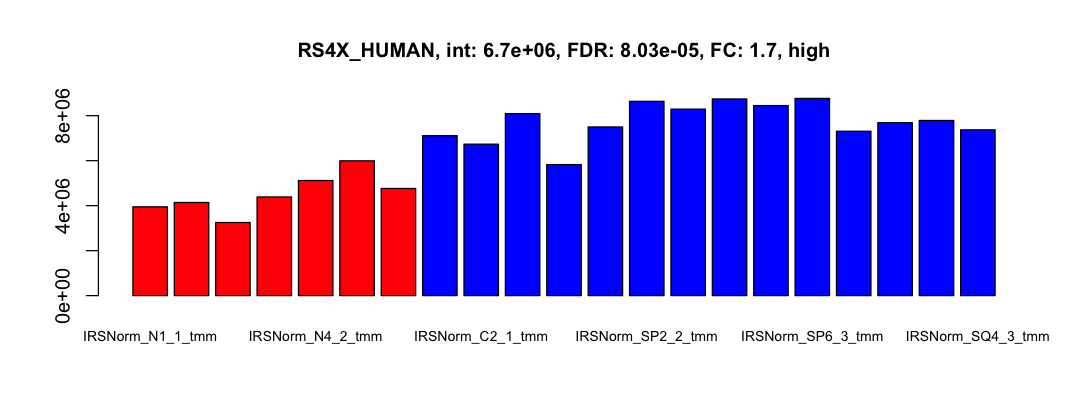

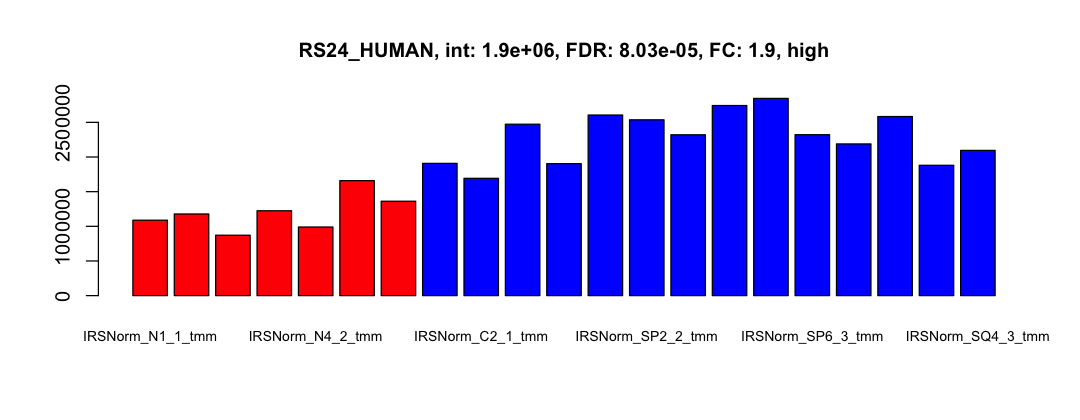

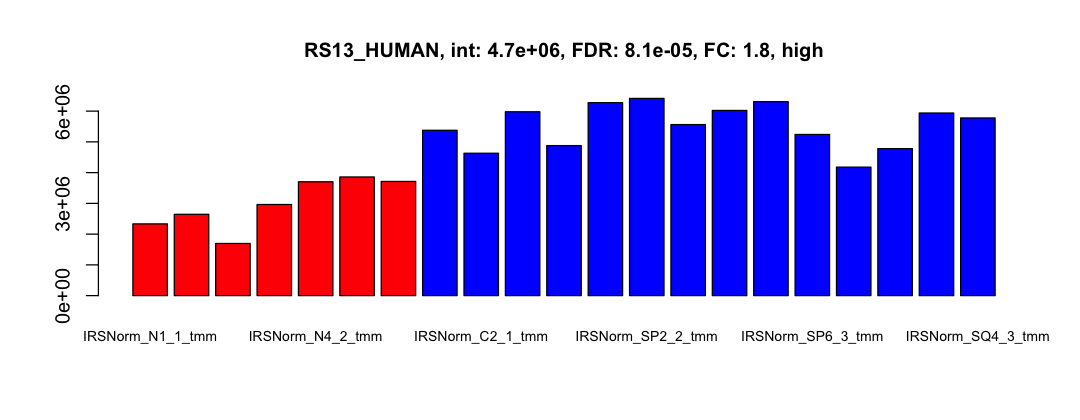

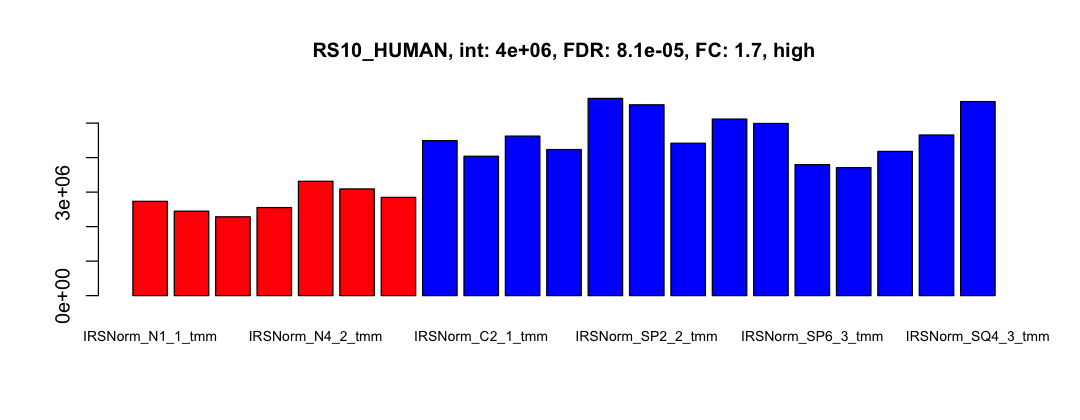

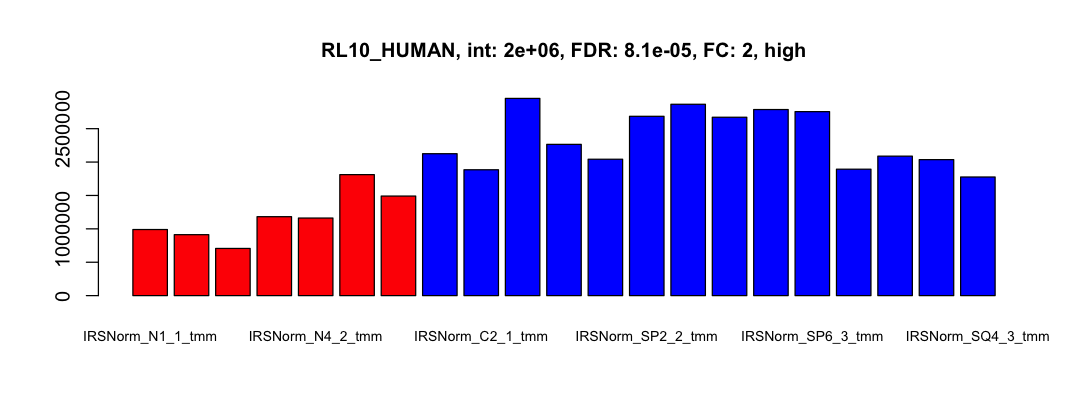

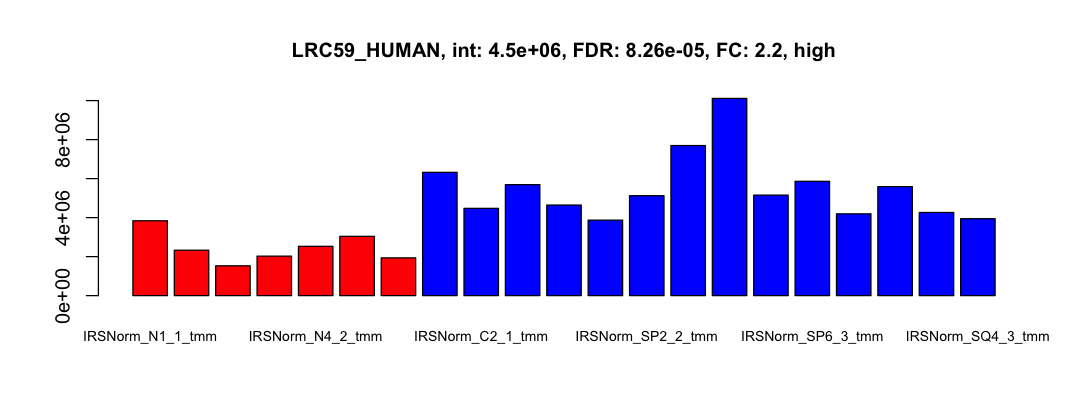

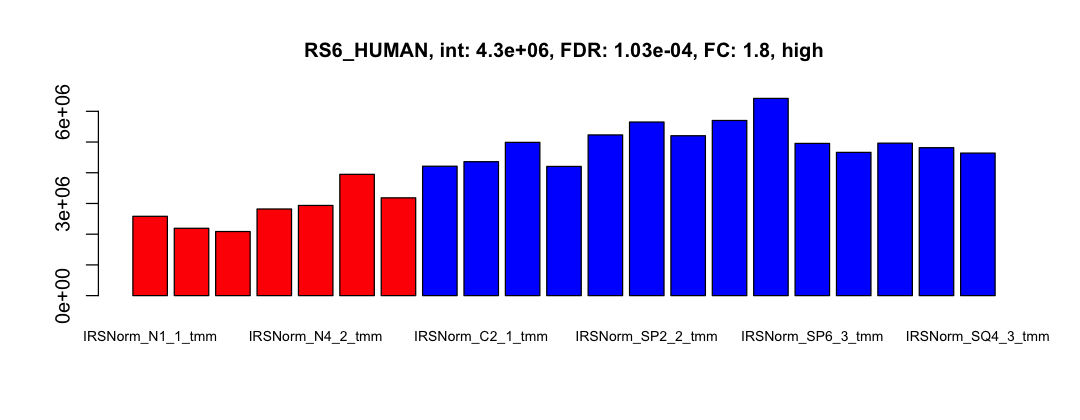

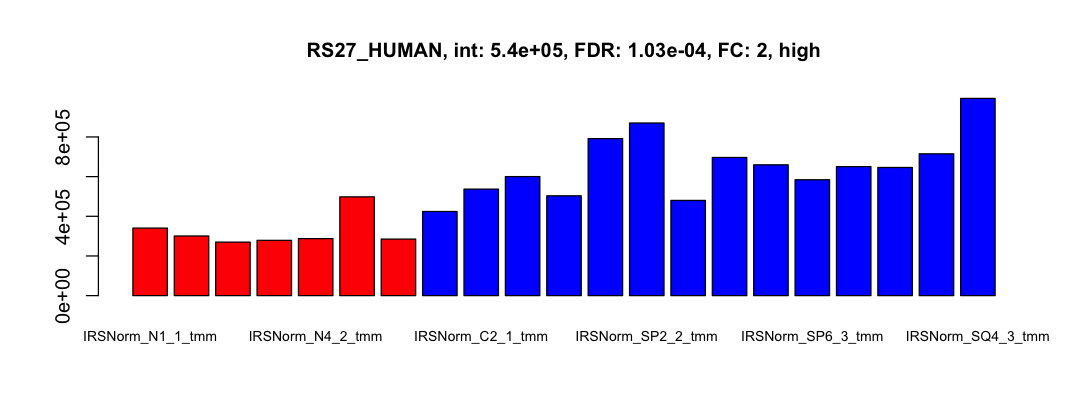

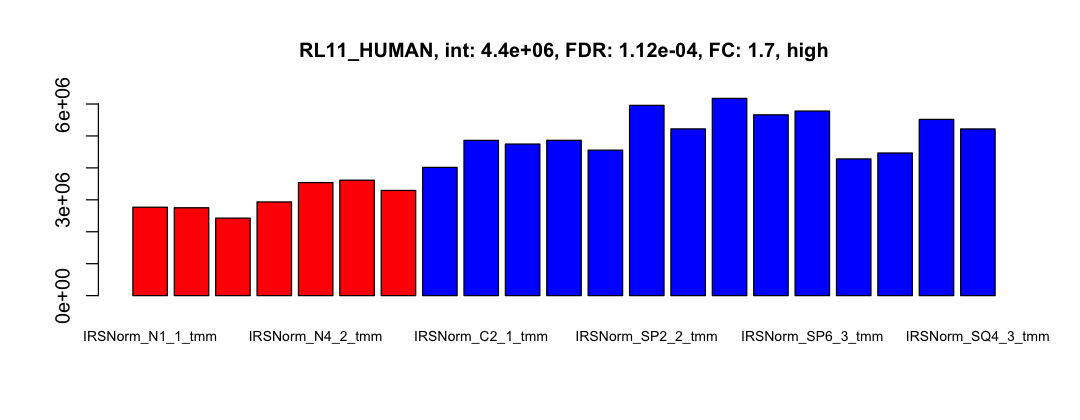

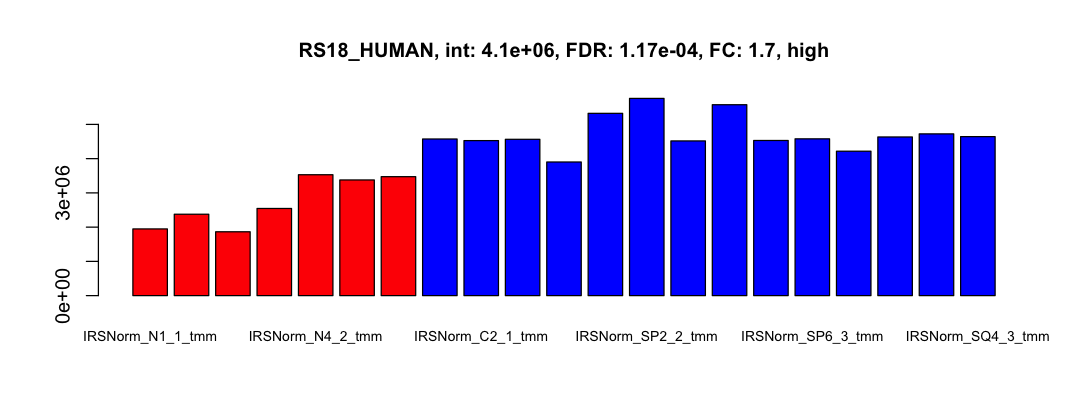

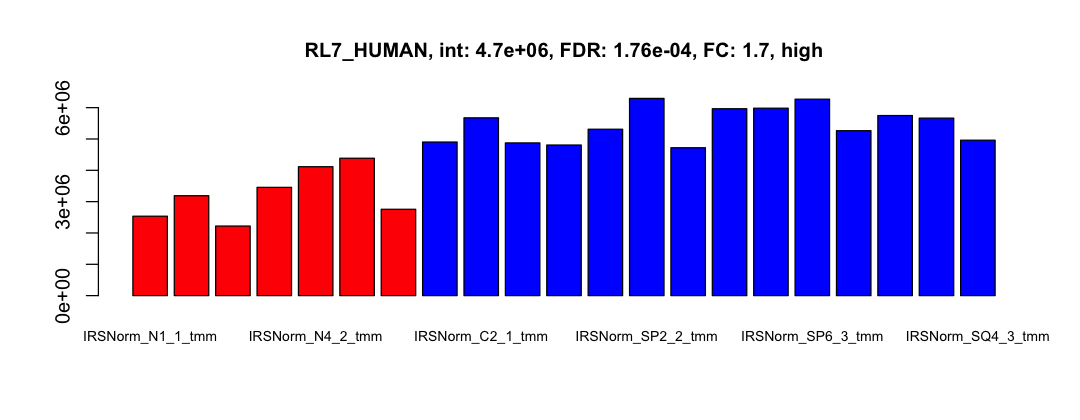

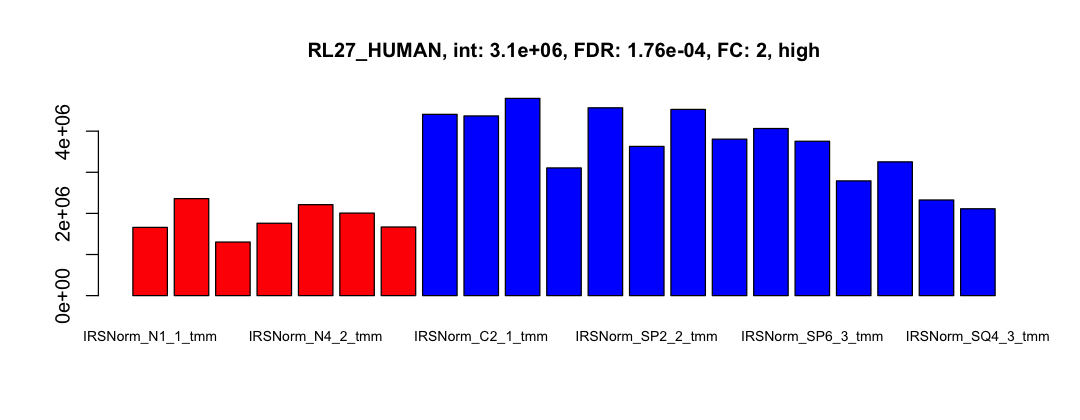

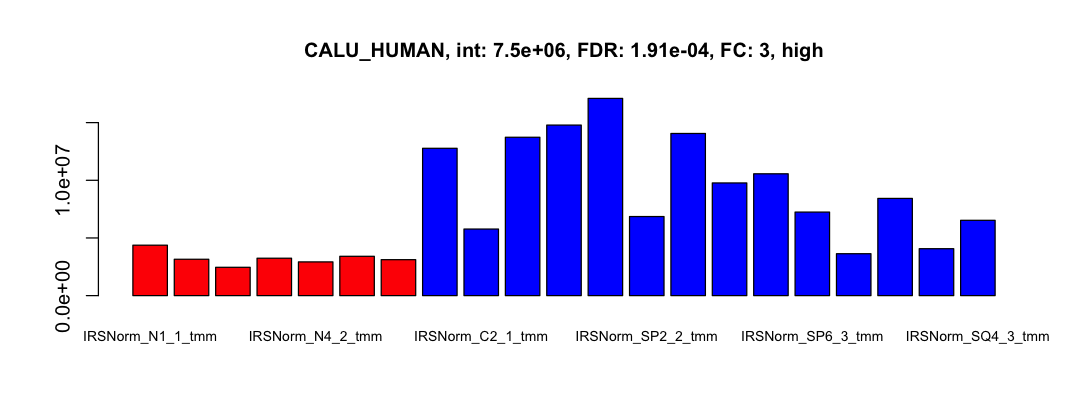

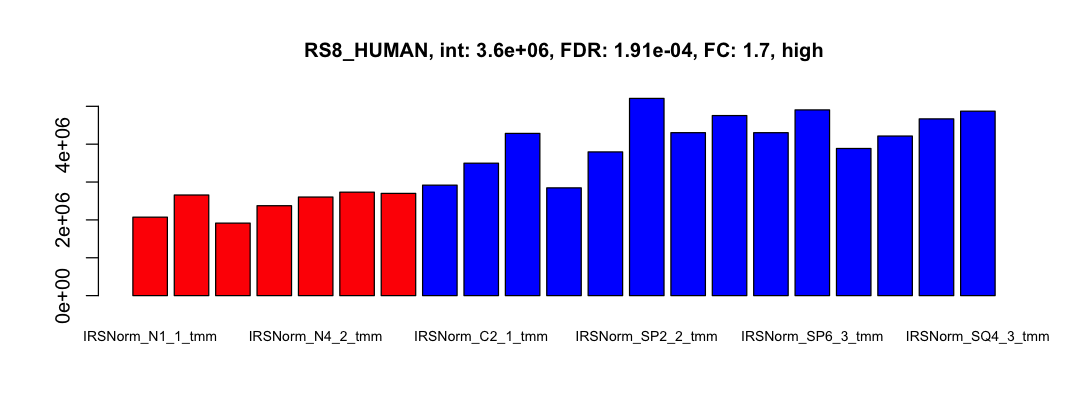

In [23]:
# look at the top 20 candidates (up in MP, then down in MP)
set_plot_dimensions(9, 3.5)
plot_top_tags(results, 7, 14, 20)
set_plot_dimensions(9, 9)

### The top DE candidates look more convincing

There are some sample to sample variations in line with what one expects for human subjects. However, we do have clear differences in expression levels.

----

## <a name="TN_MBC"></a> (3) Triple Negative versus Metaplastic

We can compare the non-metaplastic breast cancer samples to the metaplastic samples. These samples were not very distinct from each other in the cluster plots.

Contrasts
Levels TN - MP
    N   0     
    TN  1     
    MP -1

       TN - MP
Down         0
NotSig    4132
Up           0

genes                 logFC      AveExpr  t         P.Value     
1412 sp|P02794|FRIH_HUMAN  -1.0083063 6.210029 -5.198898 1.592830e-05
775  sp|P49773|HINT1_HUMAN  0.8116259 7.621307  4.534512 9.815057e-05
853  sp|P36776|LONM_HUMAN   0.7689277 7.449483  4.219337 2.313014e-04
1786 sp|Q15102|PA1B3_HUMAN  0.6877338 5.383421  4.152140 2.774072e-04
377  sp|Q14980|NUMA1_HUMAN  0.6045282 8.942720  3.985088 4.349892e-04
3360 sp|Q96I59|SYNM_HUMAN   0.7962371 1.863936  3.963419 4.610156e-04
1608 sp|O75116|ROCK2_HUMAN -0.5516064 5.923446 -3.831554 6.557122e-04
1187 sp|P21283|VATC1_HUMAN -0.5653403 6.650947 -3.807818 6.984551e-04
418  sp|P29692|EF1D_HUMAN  -0.5578853 8.625989 -3.750018 8.142642e-04
1843 sp|P35556|FBN2_HUMAN  -1.5699432 4.793499 -3.732863 8.521094e-04
     adj.P.Val  B          
1412 0.06581575  2.14064389
775  0.20277909  0.86487155
853  0.28656160  0.22429639
1786 0.28656160  0.04354886
377  0.31748610 -0.29300297
3360 0.31748610 -0.59417956
1608 0.34399355 -0.60140955
1187 0.34399355 -0.62037219
418  0.34399355 -0.74366283
1843 0.34399355 -0.86112134

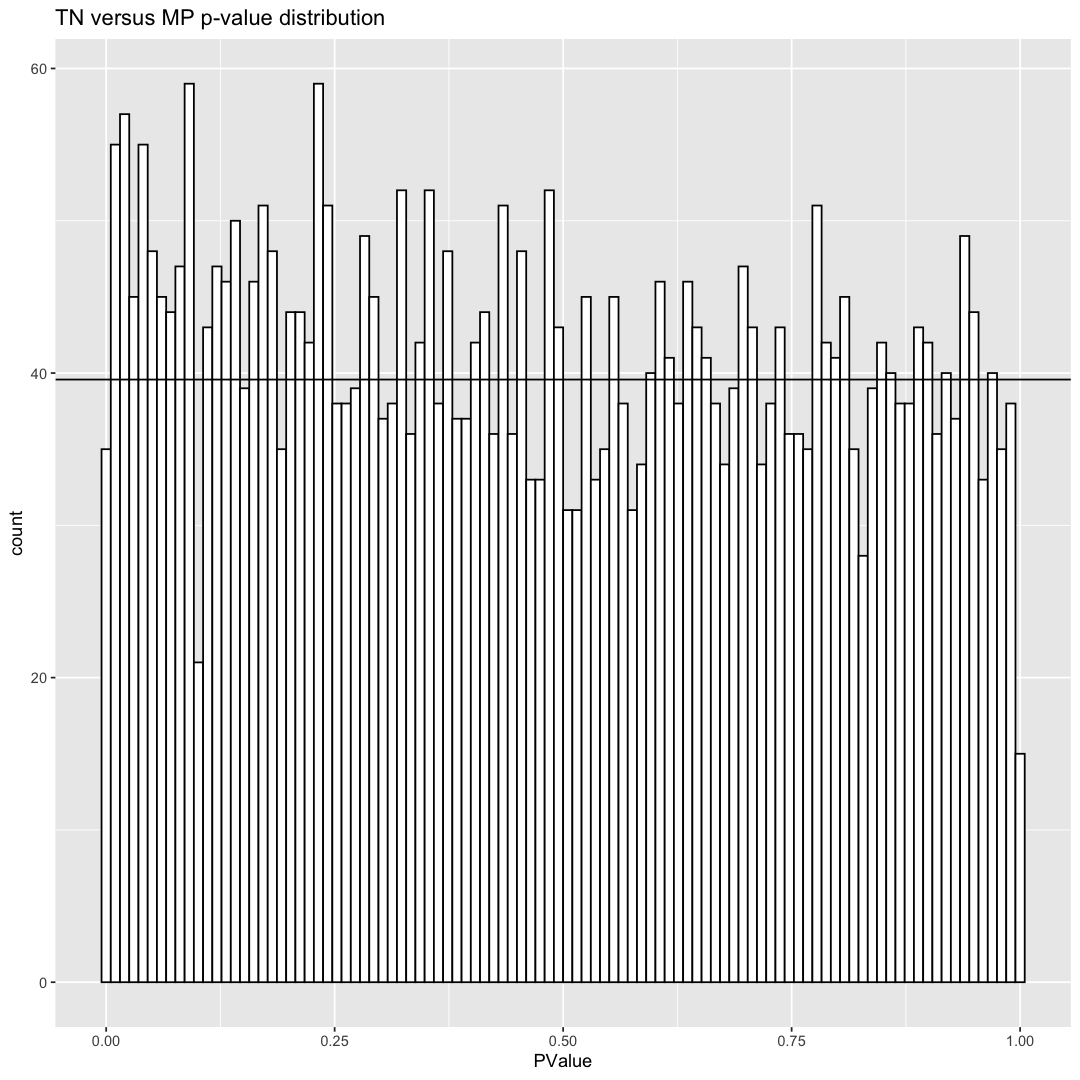

In [24]:
# make the contrast
contrast <- makeContrasts(TN-MP, levels = design)
contrast

# get the fit for the contrast of interest
vfit2 <- contrasts.fit(vfit, contrast)

# do the empirical Bayes moderation of the test statistic (with trended variance)
efit2 <- eBayes(vfit2)

# grab the information in topTable so we can get the data to plot candidates
# the coef parameter has to do with the contrast of interest
# specify no sorting of results and a number that is longer than the data table
tt_limma <- topTable(efit2, coef = 1, sort.by = "none", number = Inf)

# let's see how many up and down candidates, and the top tags
summary(decideTests(efit2, p.value = 0.05))
topTable(efit2)

# get the results summary
results <- collect_results_limma(tmt_tmm, tt_limma, TN, "TN", MP, "MP", accessions)

# check the p-value distribution
ggplot(results, aes(PValue)) + 
  geom_histogram(bins = 100, fill = "white", color = "black") + 
  geom_hline(yintercept = mean(hist(results$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
  ggtitle("TN versus MP p-value distribution") # check the p-value distribution

### We have no candidates

There is no point in plotting things.

In [25]:
# make column names unique by adding comparison
results_temp  <- results
colnames(results_temp) <- str_c(colnames(results), "_TN_MP")

# accumulate the testing results
all_results <- cbind(all_results, results_temp)

### MA plots

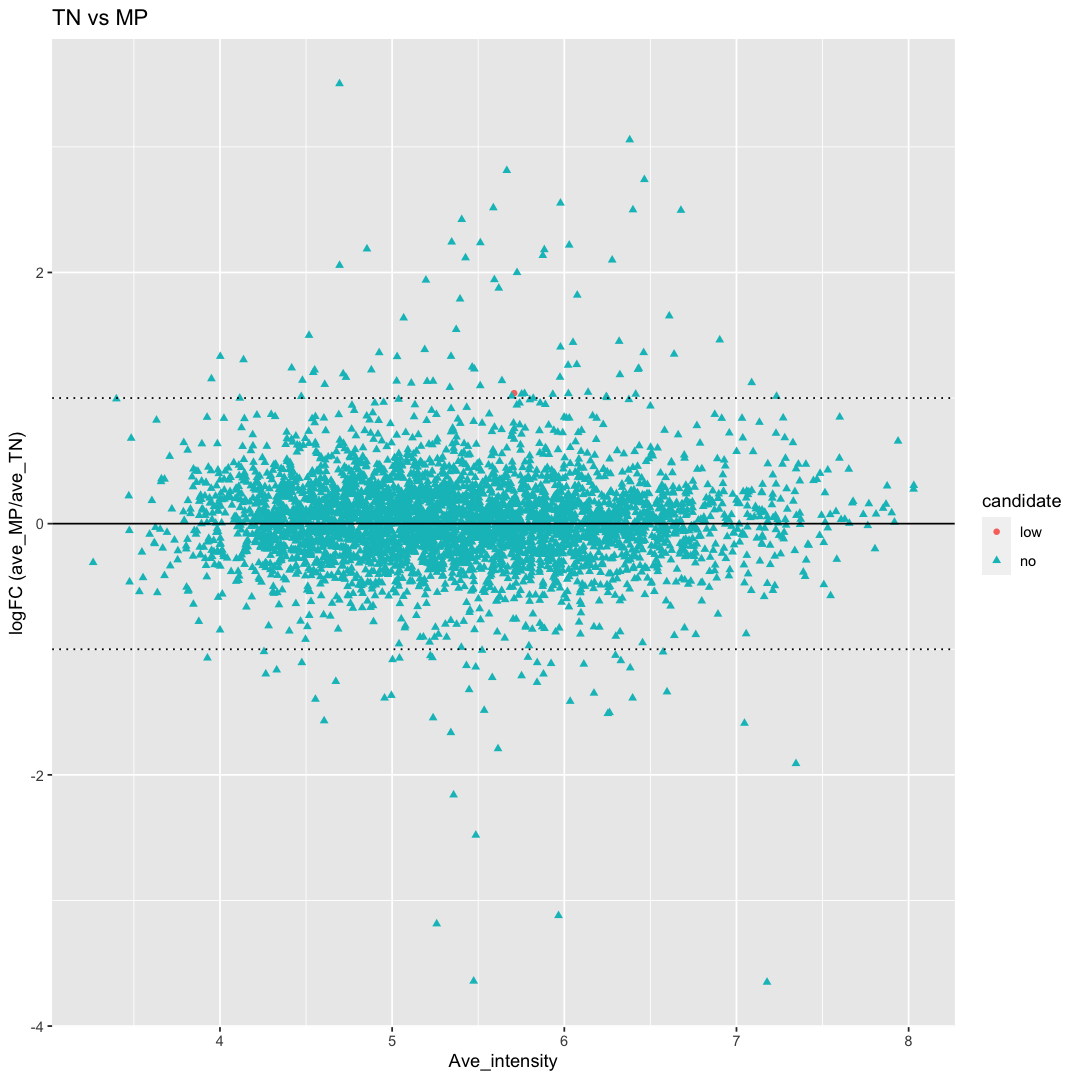

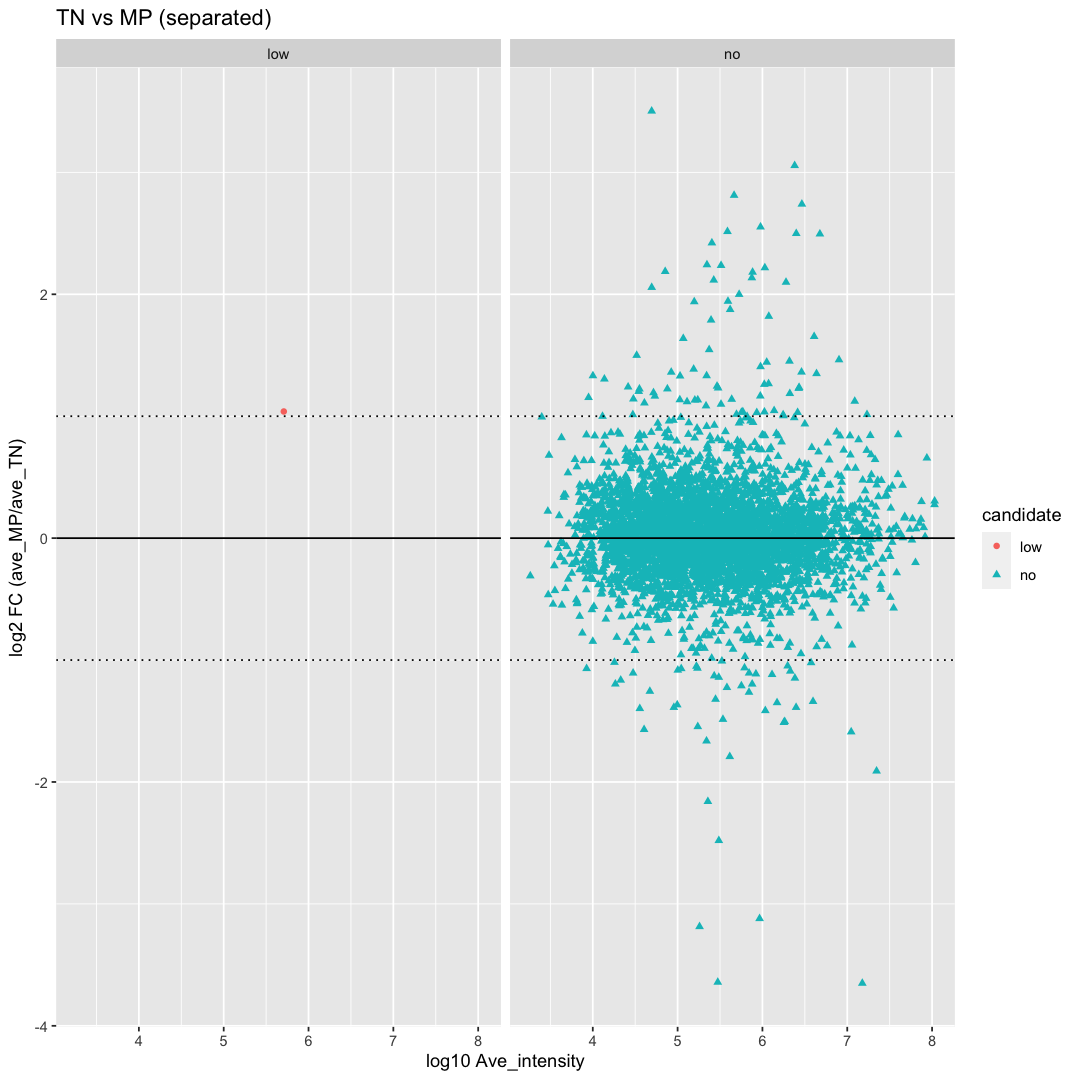

In [26]:
# make MA plots
MA_plots(results, "ave_TN", "ave_MP", "TN vs MP")

### Scatter plots

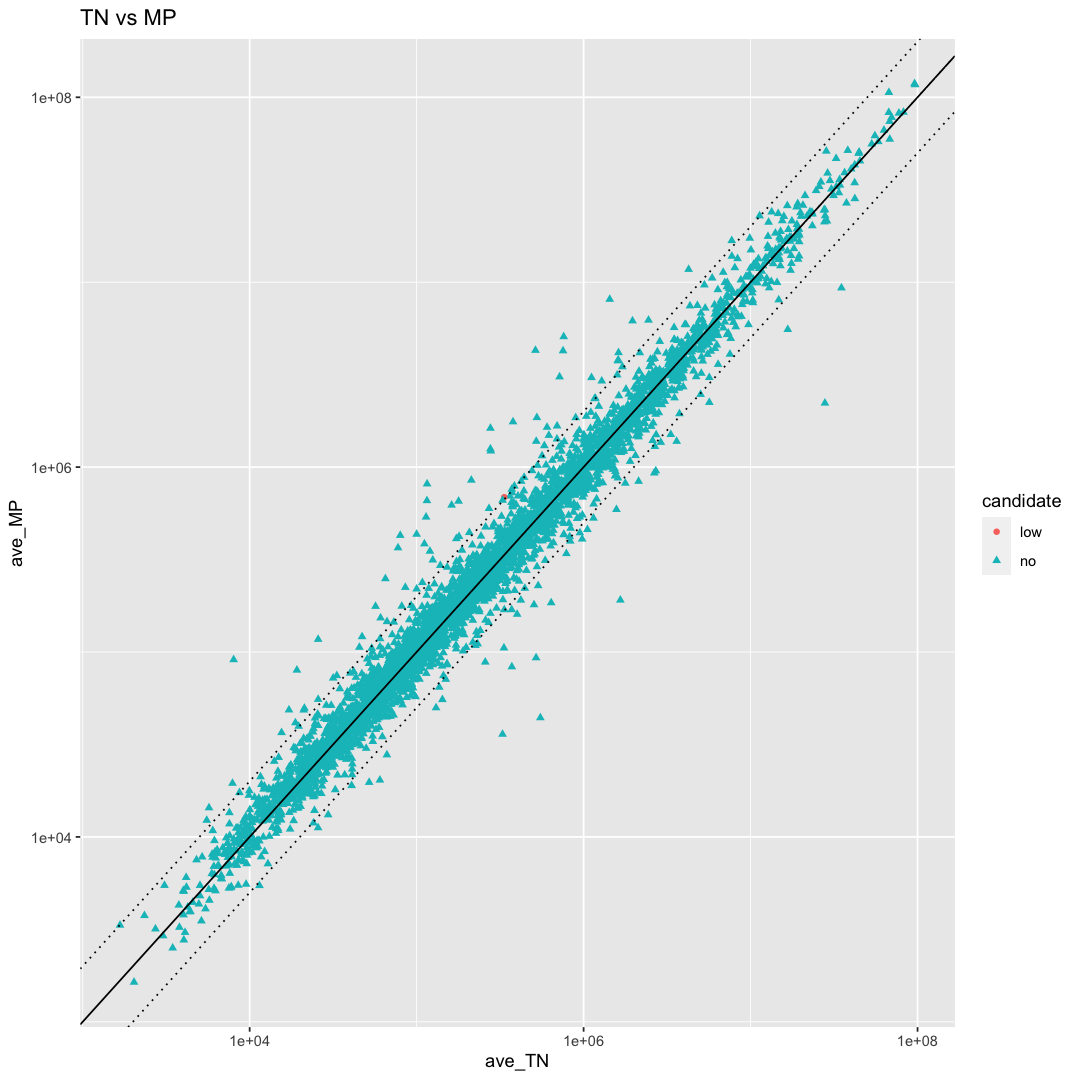

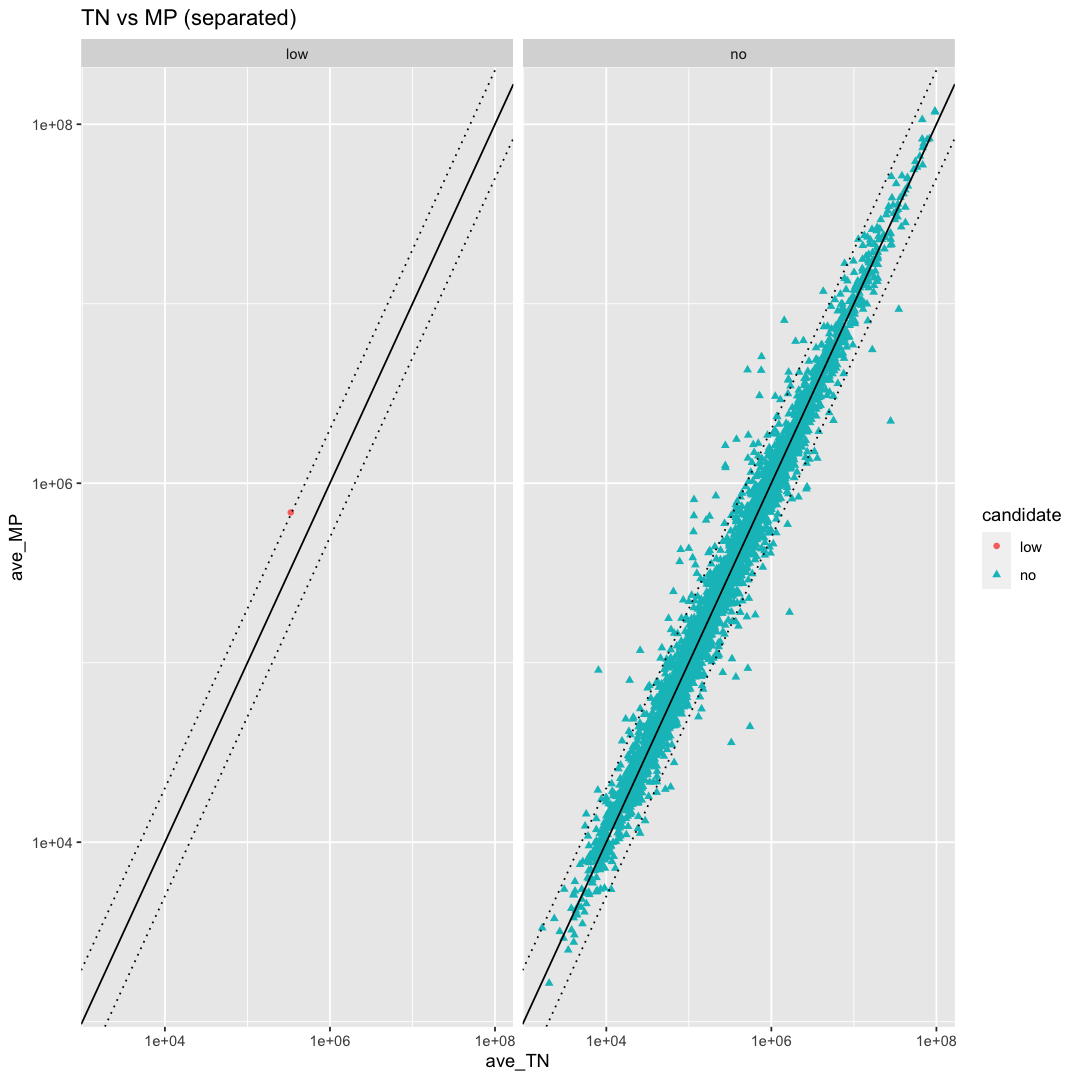

In [27]:
# make scatter plots
scatter_plots(results, "ave_TN", "ave_MP", "TN vs MP")

### Volcano plot

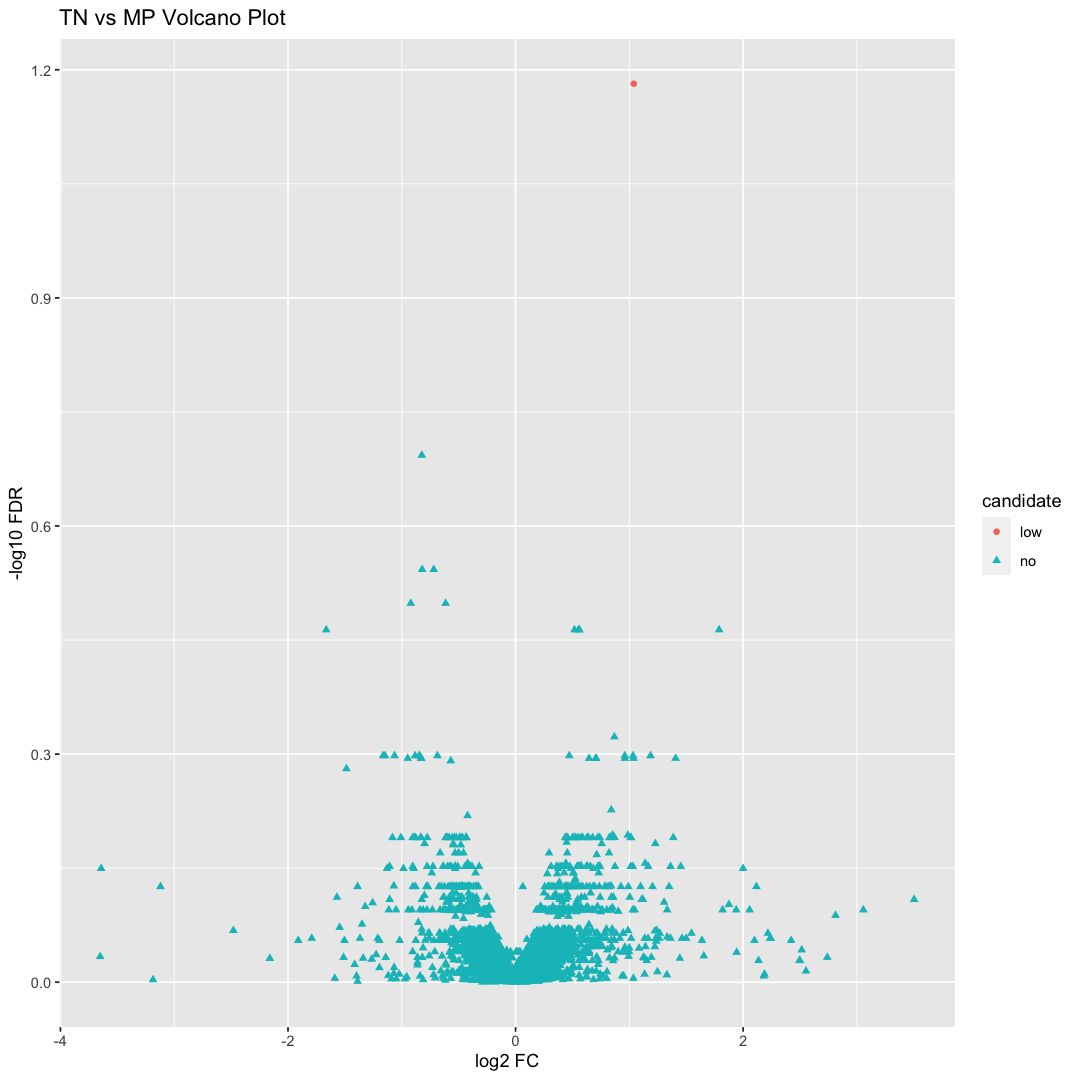

In [28]:
# make a volcano plot
volcano_plot(results, "ave_TN", "ave_MP", "TN vs MP")

### Check individual protein expression

These will all be non-candidates.

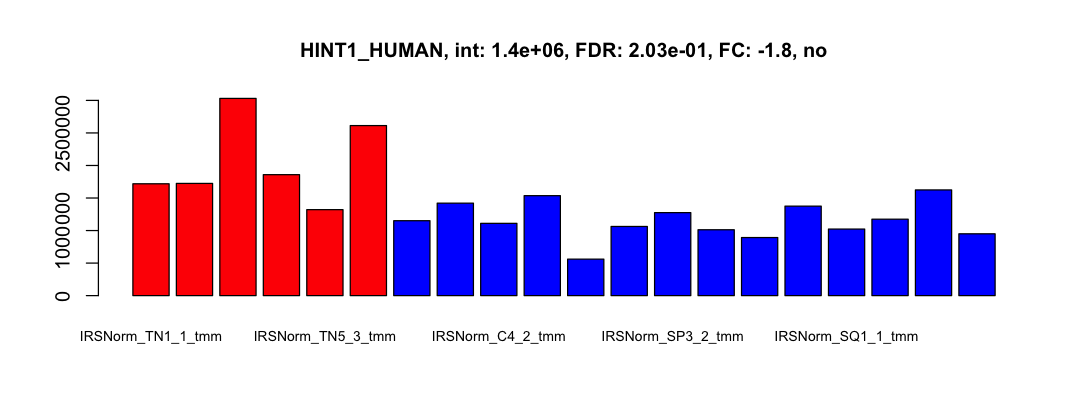

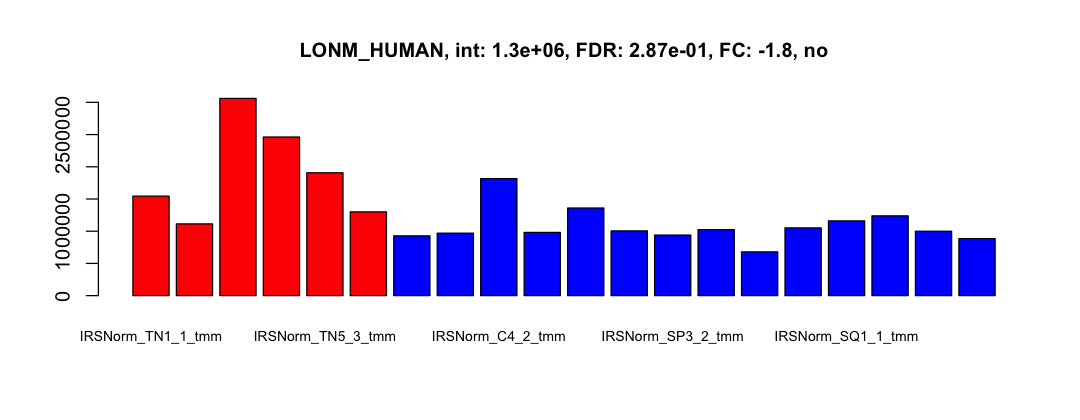

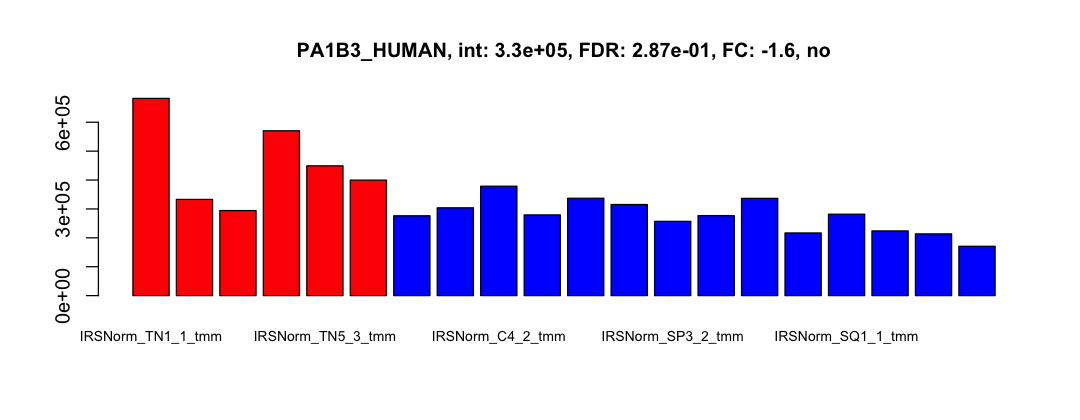

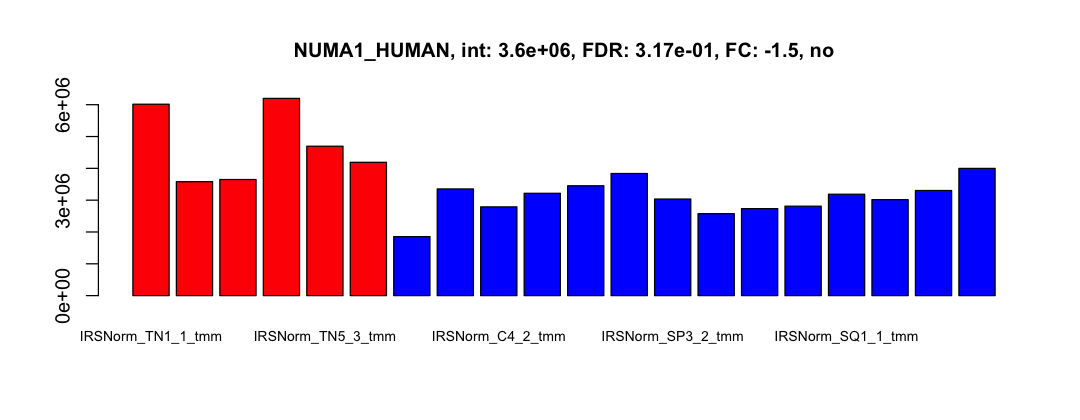

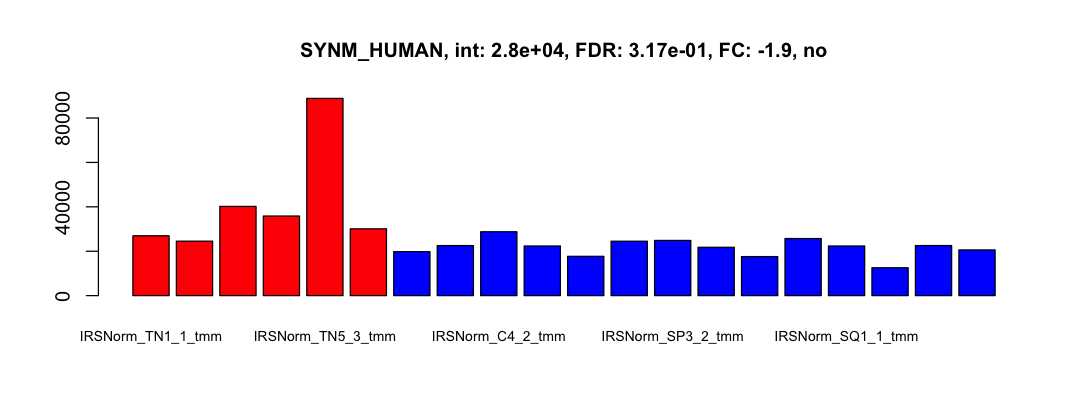

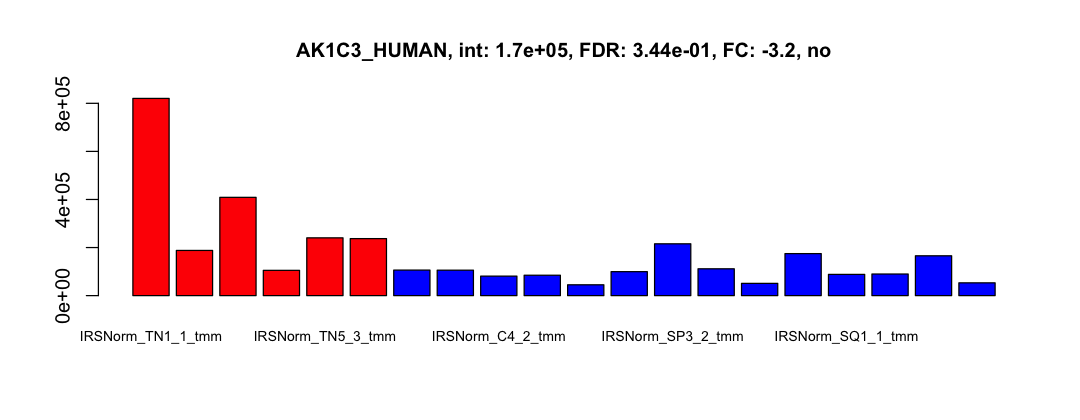

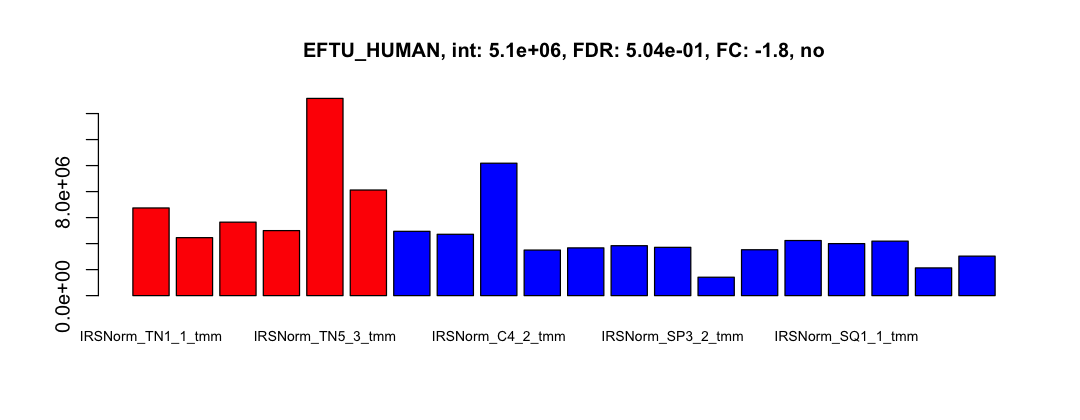

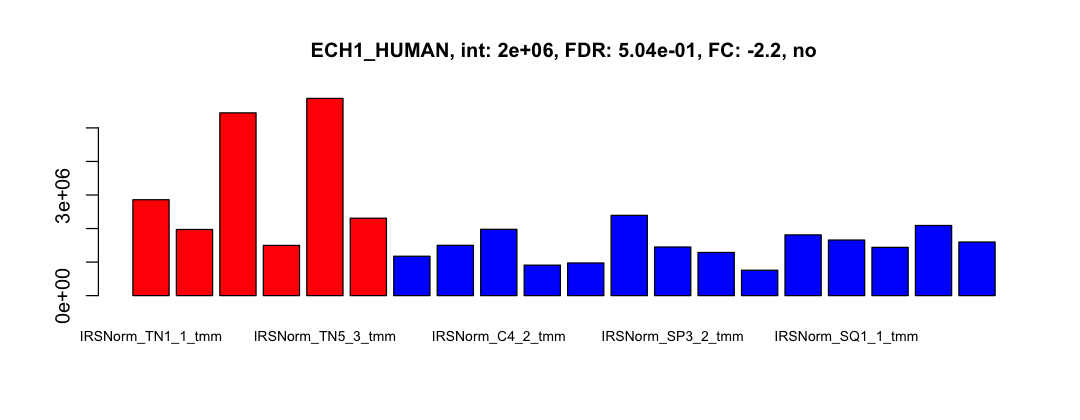

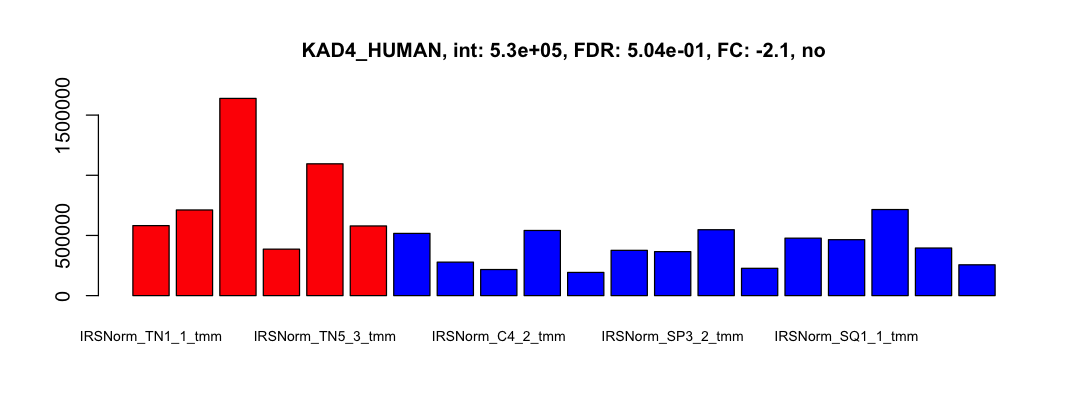

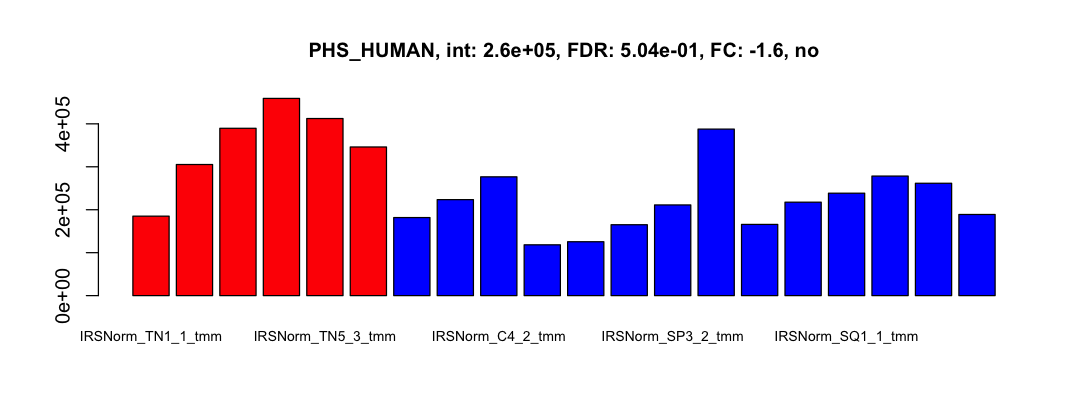

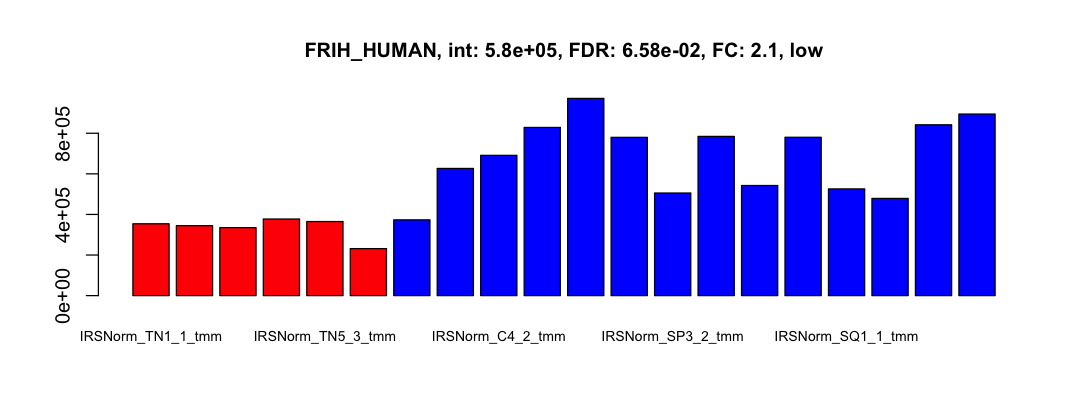

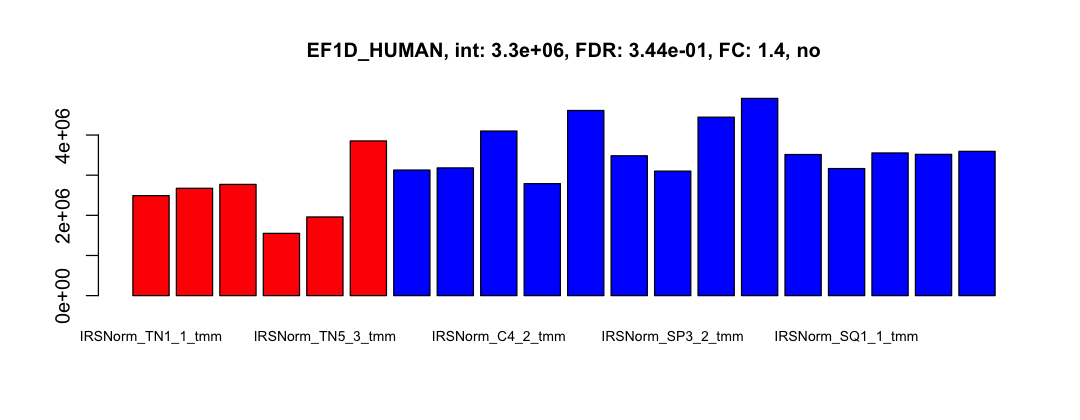

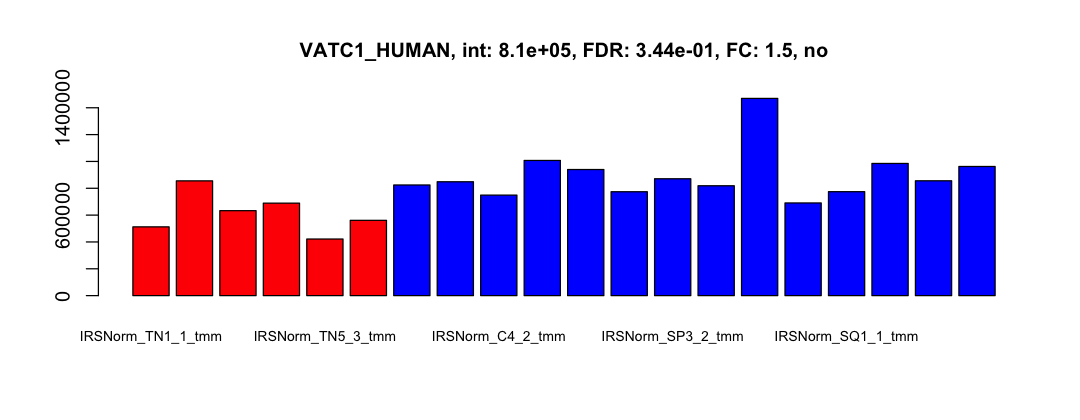

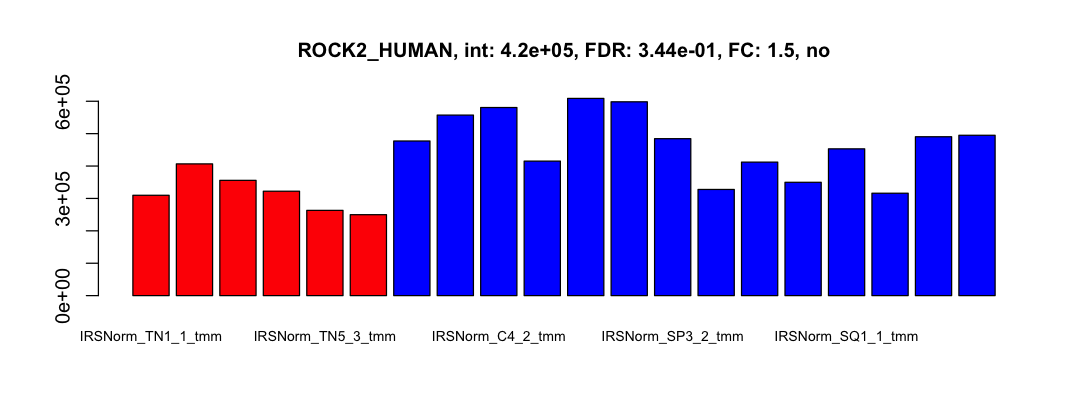

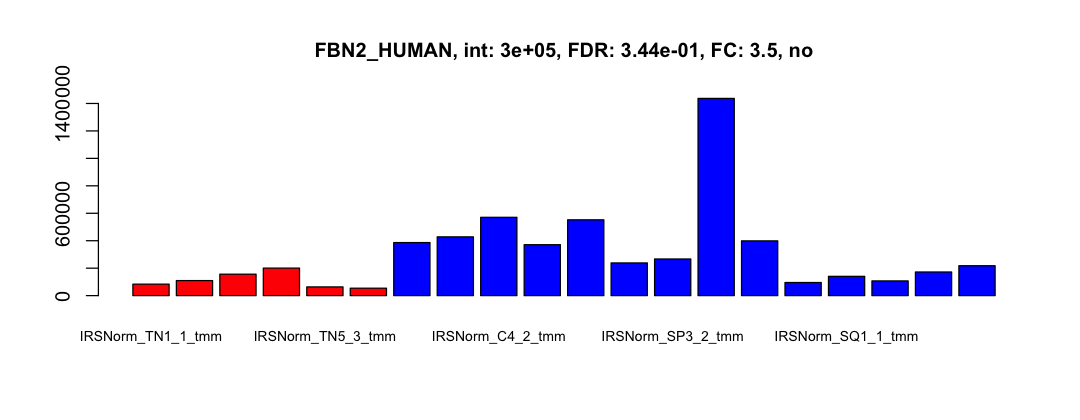

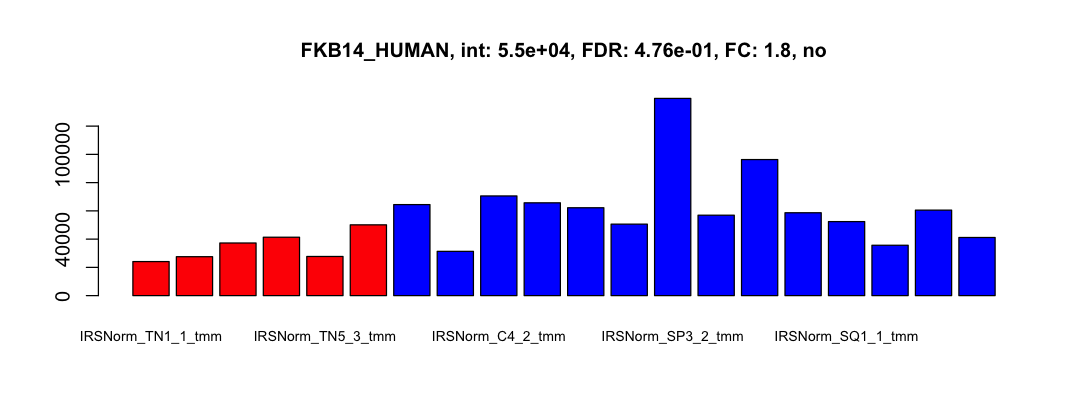

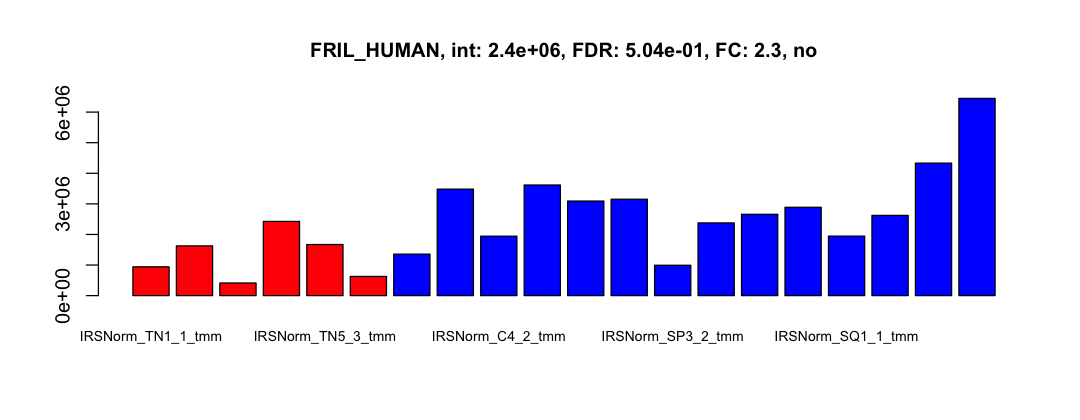

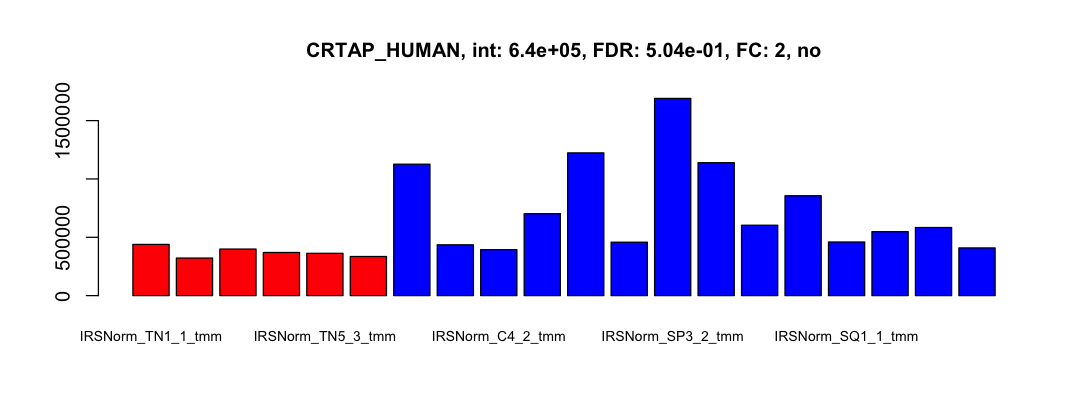

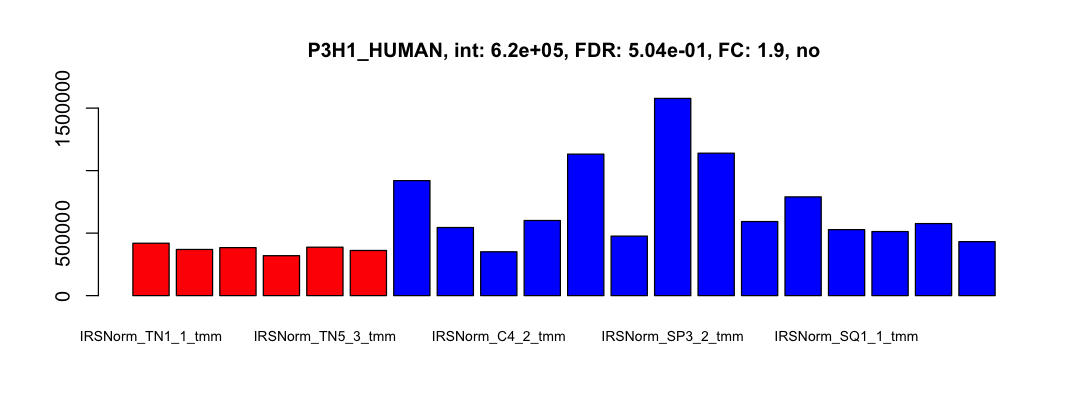

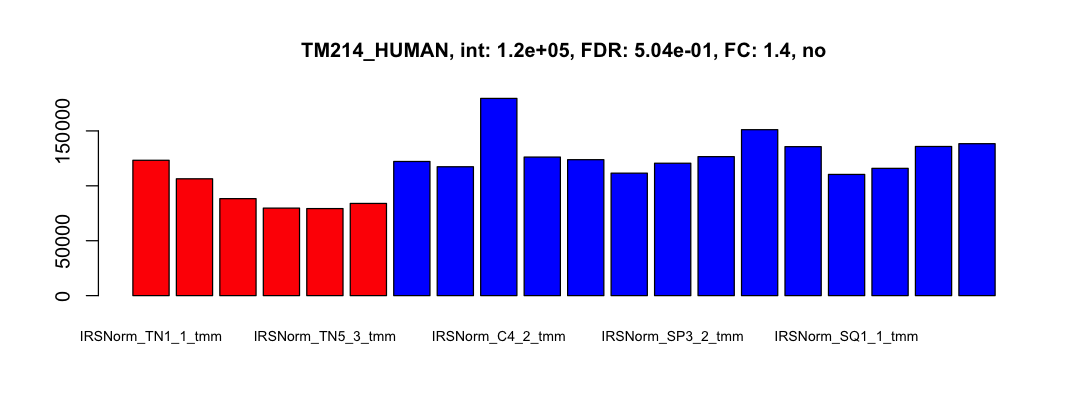

In [29]:
# look at the top 10 candidates (up in MP, then down in MP)
set_plot_dimensions(9, 3.5)
plot_top_tags(results, 6, 14, 10)
set_plot_dimensions(9, 9)

## <a name="summary"></a> Summary

limma testing and voom-limma were very similar. Both were a little more conservative compared to edgeR.

---
## Save the `all_results` frame to TSV file

In [30]:
# write the results to disk
write.table(all_results, "results_voom-limma.txt", sep = "\t",
           row.names = FALSE, na =  " ")

## Log the session information

In [31]:
# log the session details
sessionInfo()

R version 3.5.3 (2019-03-11)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.15.6

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] psych_1.9.12.31 edgeR_3.24.3    limma_3.38.3    scales_1.1.0   
 [5] forcats_0.5.0   stringr_1.4.0   dplyr_0.8.5     purrr_0.3.3    
 [9] readr_1.3.1     tidyr_1.0.2     tibble_2.1.3    ggplot2_3.3.0  
[13] tidyverse_1.3.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.4       locfit_1.5-9.1   lubridate_1.7.4  lattice_0.20-40 
 [5] assertthat_0.2.1 digest_0.6.25    IRdisplay_0.7.0  R6_2.4.1        
 [9] cellranger_1.1.0 repr_1.1.0       backports_1.1.5  reprex_0.3.0    
[13] evaluate